In [1]:
#general libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import warnings
warnings.filterwarnings("ignore")

#torch 
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

#optuna
import optuna
import optuna_dashboard

%matplotlib inline



In [2]:
#building a simple cnn architecture

class SimpleCNN(nn.Module):

    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.dropout2 = nn.Dropout2d(0.25)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = self.dropout1(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = torch.relu(self.conv2(x))
        x = self.dropout2(x)
        x = torch.max_pool2d(x, kernel_size=2, stride=2)
        x = x.view(-1, 32 * 7 * 7)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [3]:
def get_mnist_loaders(train_batch_size, test_batch_size):

    """Get MNIST data loaders"""
    train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=train_batch_size, shuffle=True)
    
    test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=test_batch_size, shuffle=True)

    return train_loader, test_loader

In [4]:
def plot_top_confused_images(confused_images, actual_labels, predicted_labels):
    n_confused_images = min(len(confused_images), 6)
    print(f"Plotting top {n_confused_images} confused images:")

    fig, axes = plt.subplots(2, 3, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < n_confused_images:
            ax.imshow(confused_images[i].squeeze(), cmap='gray')
            ax.set_title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()


In [5]:
def train_model(model, train_loader, optimizer, criterion, log_interval, epoch, device):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))

        loss = criterion(output, target.to(device))
        loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

In [6]:
def validate_model(model, test_loader, criterion, device, entropy_threshold=0.5):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    #confused images, actual labels, predicted labels
    confused_images = []
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)  # Move data and target to device
            output = model(data)
            total_loss += criterion(output, target).item()

            # Model prediction
            _, predicted = torch.max(output, 1)
            correct += (predicted == target).sum().item()  # No need to move predicted to device

            # Calculate entropy
            probabilities = torch.softmax(output, dim=1)
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-8), dim=1)

            # Find indices of confused images
            confused_mask = entropy > entropy_threshold
            confused_images.extend(data[confused_mask].cpu().numpy())

            # Store actual and predicted labels of confused images
            actual_labels.extend(target[confused_mask].cpu().numpy())
            predicted_labels.extend(predicted[confused_mask].cpu().numpy())

    total_loss /= len(test_loader.dataset)
    test_accuracy = 100. * (correct / len(test_loader.dataset))

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        total_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    # Plot the top 9 confused images
    if confused_images:
        plot_top_confused_images(confused_images, actual_labels, predicted_labels)

    return test_accuracy


## Training the model without optuna

In [ ]:
def train_mnist_model():

    cfg = {
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'log_interval': 100,
        'seed': 0,
        'save_model': False,
        'n_epochs': 25,
        'train_batch_size': 64,
        'test_batch_size': 128,
        'lr': 0.001,
        'momentum': 0.5,
        'criterion': nn.CrossEntropyLoss()
    }

    torch.manual_seed(cfg['seed'])
    train_loader, test_loader = get_mnist_loaders(cfg['train_batch_size'], cfg['test_batch_size'])
    model = SimpleCNN().to(cfg['device'])
    optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])
    for epoch in range(1, cfg['n_epochs']+1):
        train_model(model, train_loader, optimizer, cfg['criterion'], cfg['log_interval'], epoch, cfg['device'])
        test_accuracy = validate_model(model, test_loader, cfg['criterion'], cfg['device'])

    if cfg['save_model']:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    return test_accuracy


In [ ]:
if __name__ == "__main__":
    train_mnist_model()

## Optimise the hyper-parameters using Optuna

In [7]:
def objective(trial):

    cfg = {
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'log_interval': 100,
        'seed': 0,
        'save_model': False,
        'n_epochs': 5,
        'train_batch_size': 64,
        'test_batch_size': 512,
        'lr': trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        'momentum': trial.suggest_float("momentum", 0.4, 0.9, step=0.1),
        'criterion': nn.CrossEntropyLoss()
    }

    torch.manual_seed(cfg['seed'])
    train_loader, test_loader = get_mnist_loaders(cfg['train_batch_size'], cfg['test_batch_size'])
    model = SimpleCNN().to(cfg['device'])
    optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])
    for epoch in range(1, cfg['n_epochs']+1):
        train_model(model, train_loader, optimizer, cfg['criterion'], cfg['log_interval'], epoch, cfg['device'])
        test_accuracy = validate_model(model, test_loader, cfg['criterion'], cfg['device'])

    if cfg['save_model']:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    return test_accuracy


__Creting the study with optuna__

[I 2024-03-23 06:50:21,056] A new study created in RDB with name: mnist_classification


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.153194
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.637062
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.668911
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.683883
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.543877
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.588411
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.402417
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.358155
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.534166

Test set: Average loss: 0.0005, Accuracy: 9242/10000 (92%)

Plotting top 6 confused images:


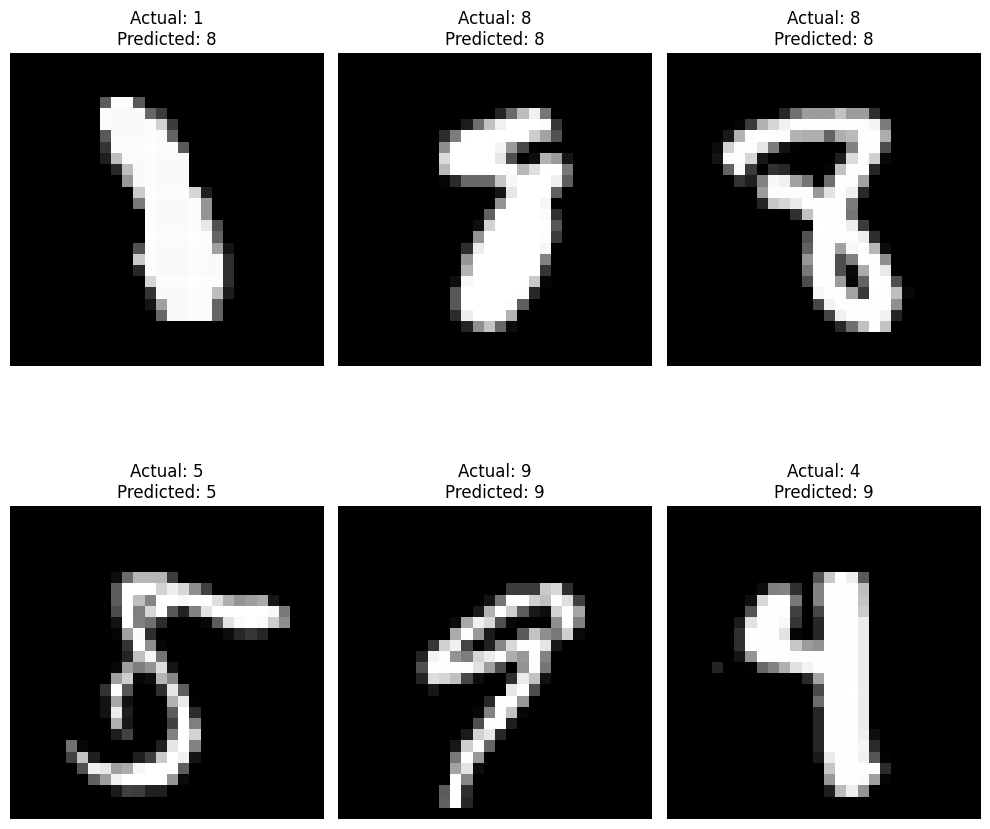

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.183284
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.266757
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.510727
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.147938
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.268125
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.252651
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.148632
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.110497
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.271612
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.152857

Test set: Average loss: 0.0003, Accuracy: 9492/10000 (95%)

Plotting top 6 confused images:


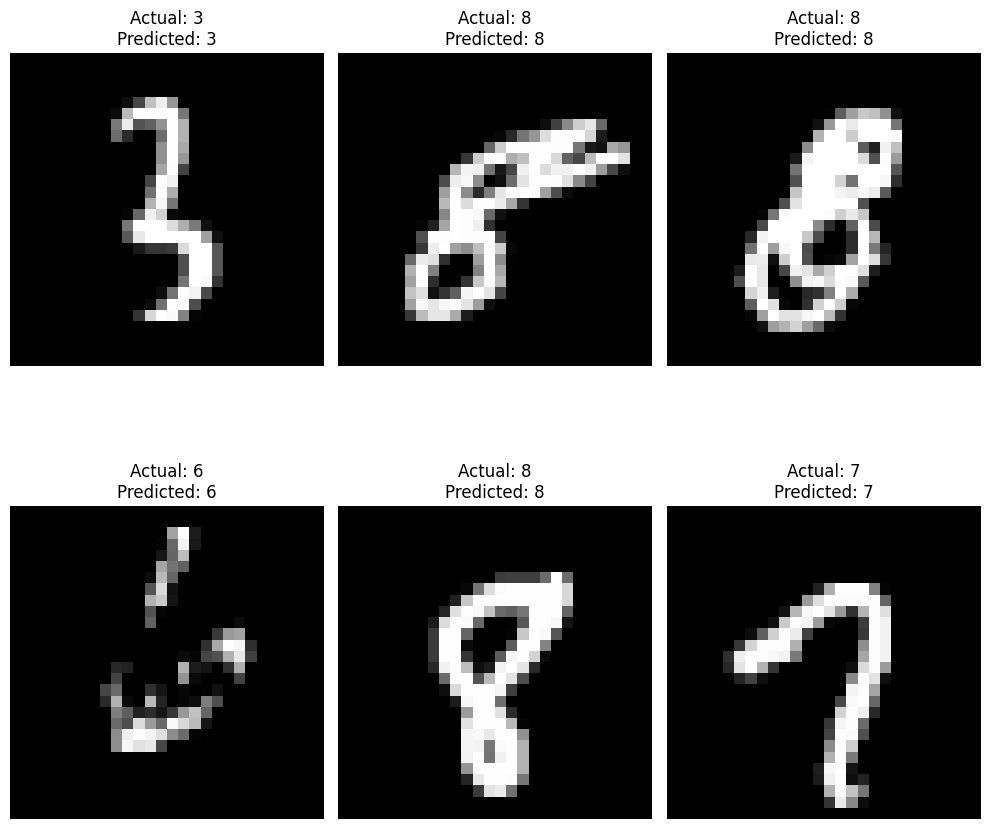

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.368457
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.115290
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.155463
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.074591
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.125390
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.171645
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.190931
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.412832
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.316509
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.223209

Test set: Average loss: 0.0003, Accuracy: 9582/10000 (96%)

Plotting top 6 confused images:


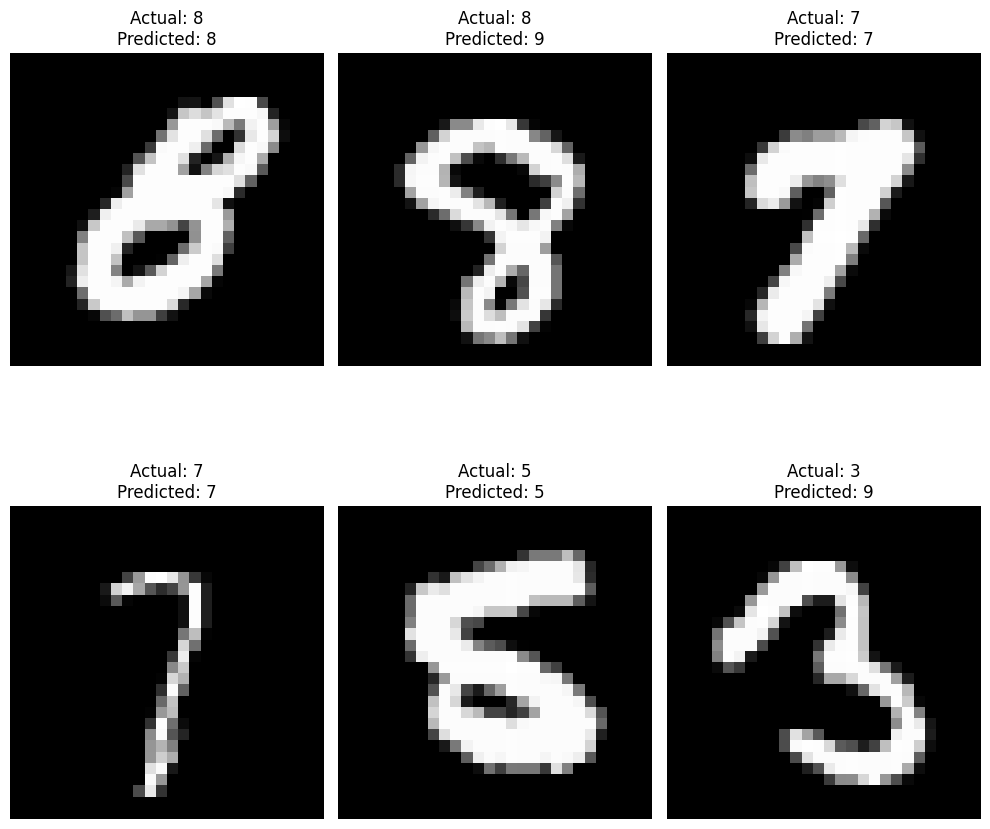

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.134089
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.158077
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.167467
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.286651
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.061680
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.136553
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.101833
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.056078
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.103824
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.174122

Test set: Average loss: 0.0002, Accuracy: 9664/10000 (97%)

Plotting top 6 confused images:


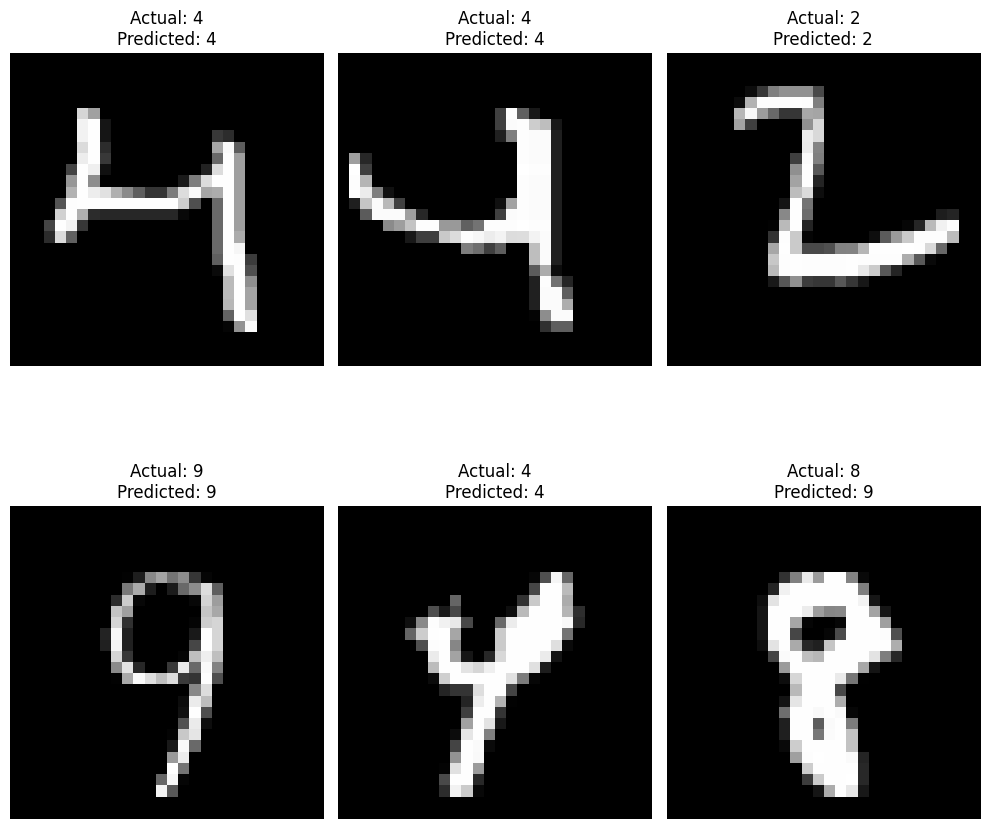

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.240721
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.063812
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.145615
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.133374
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.225300
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.141340
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.087963
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.114232
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.144354
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.328866

Test set: Average loss: 0.0002, Accuracy: 9761/10000 (98%)

Plotting top 6 confused images:


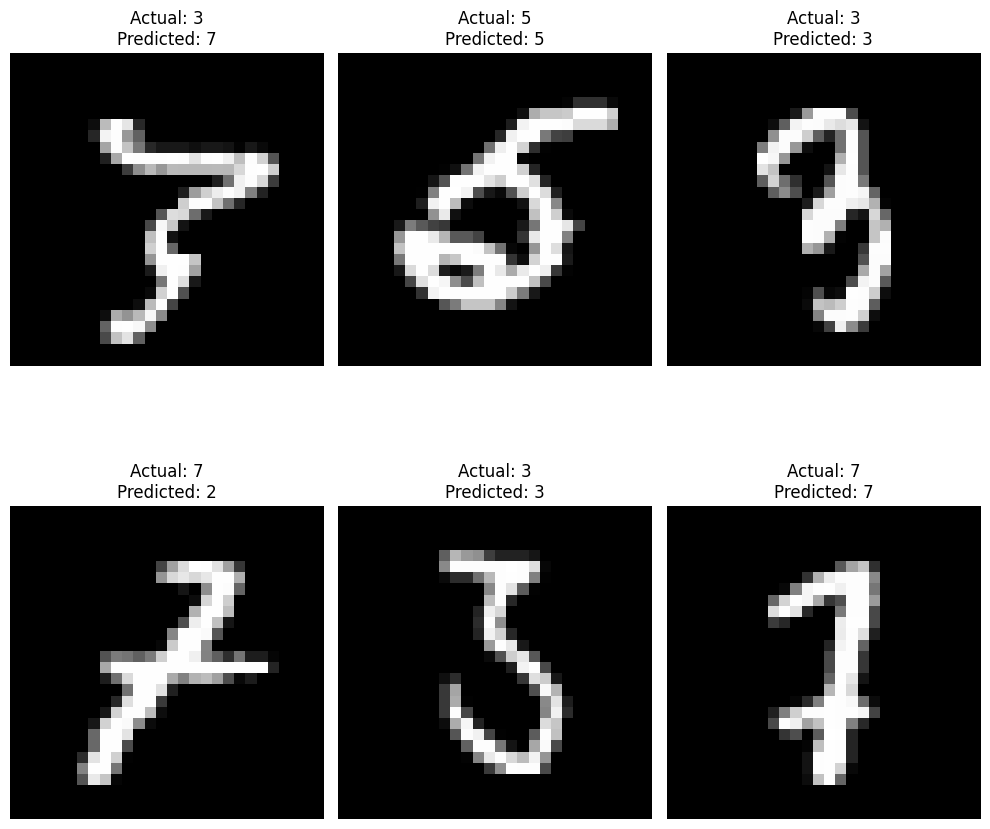

[I 2024-03-23 06:51:32,918] Trial 0 finished with value: 97.61 and parameters: {'lr': 0.0007758705899413018, 'momentum': 0.9}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.281708
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.297347
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.292817
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.287556
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.285777
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.297926
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.279445
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.265131
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.289214

Test set: Average loss: 0.0046, Accuracy: 2678/10000 (27%)

Plotting top 6 confused images:


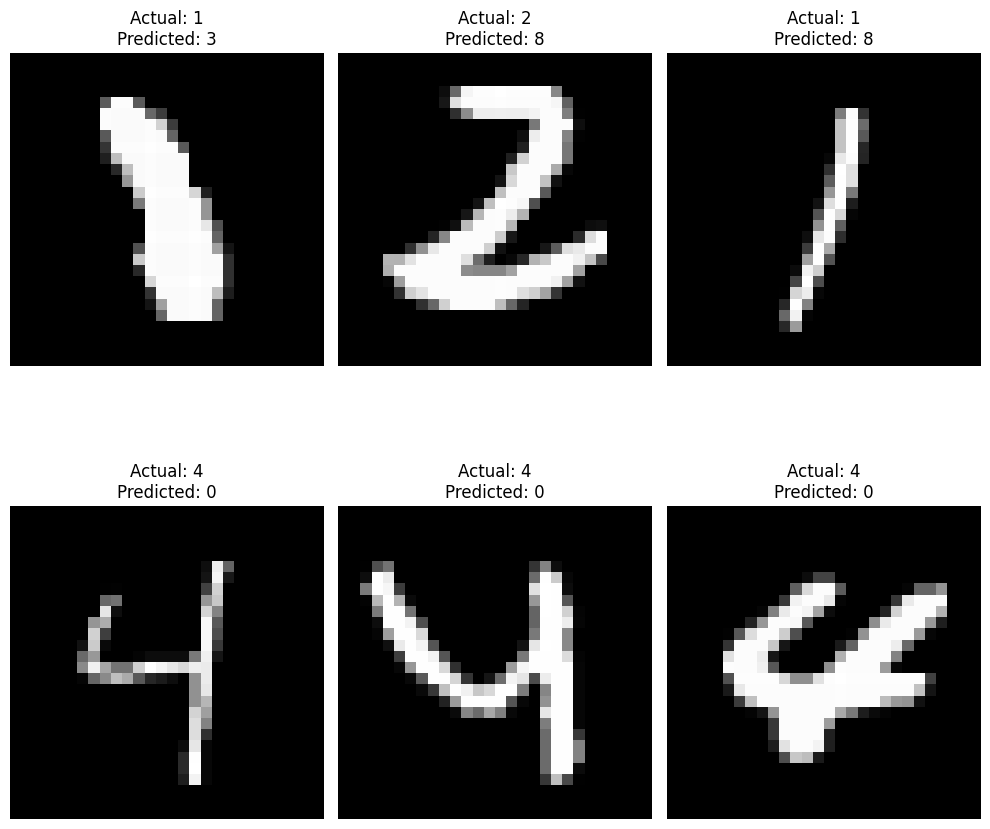

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.265554
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.286139
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.300104
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.274763
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.272113
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.272925
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.274077
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.271171
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.263584
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.254724

Test set: Average loss: 0.0045, Accuracy: 4537/10000 (45%)

Plotting top 6 confused images:


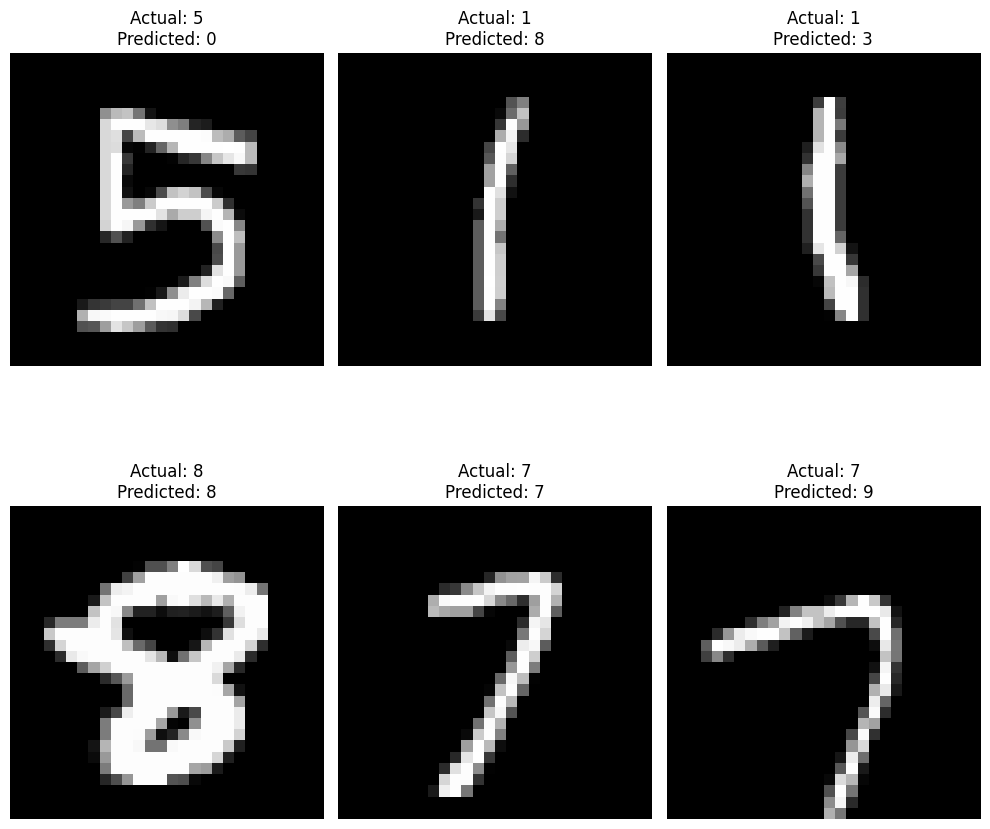

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.259313
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.255637
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.263630
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.260511
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.238678
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.241137
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.241089
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.258879
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.232443
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.243743

Test set: Average loss: 0.0045, Accuracy: 5593/10000 (56%)

Plotting top 6 confused images:


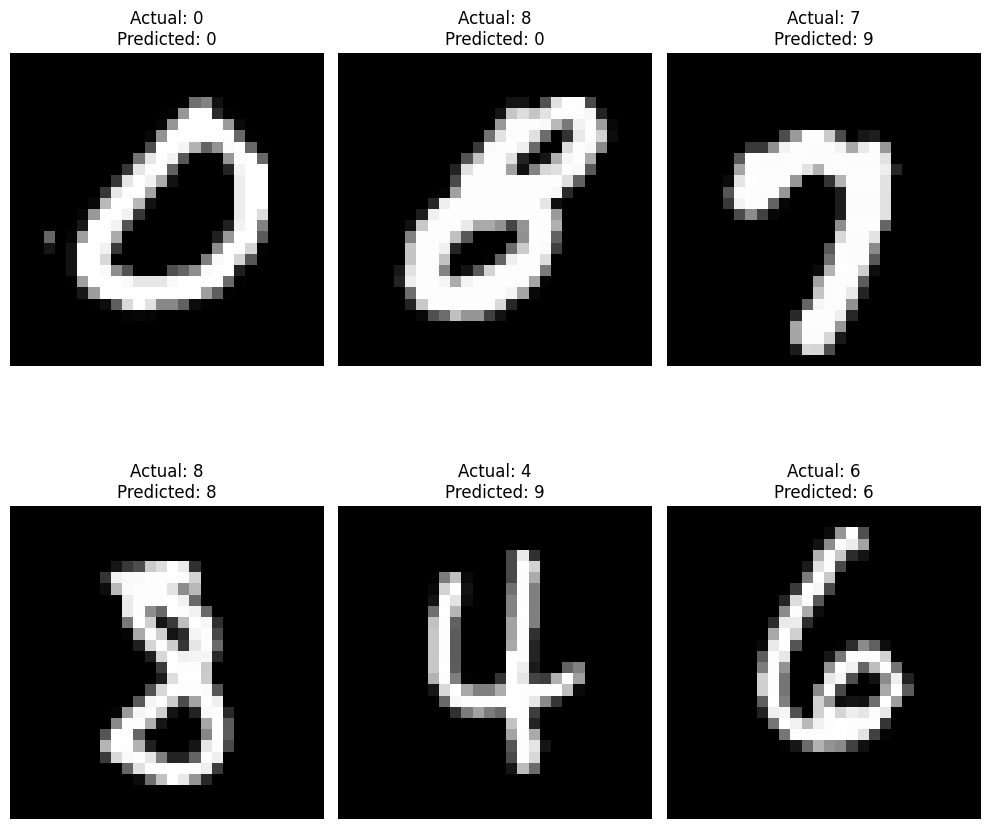

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.241831
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.227277
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.241185
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.242730
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.231726
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.222828
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.218651
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.215511
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.198292
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.216271

Test set: Average loss: 0.0044, Accuracy: 6172/10000 (62%)

Plotting top 6 confused images:


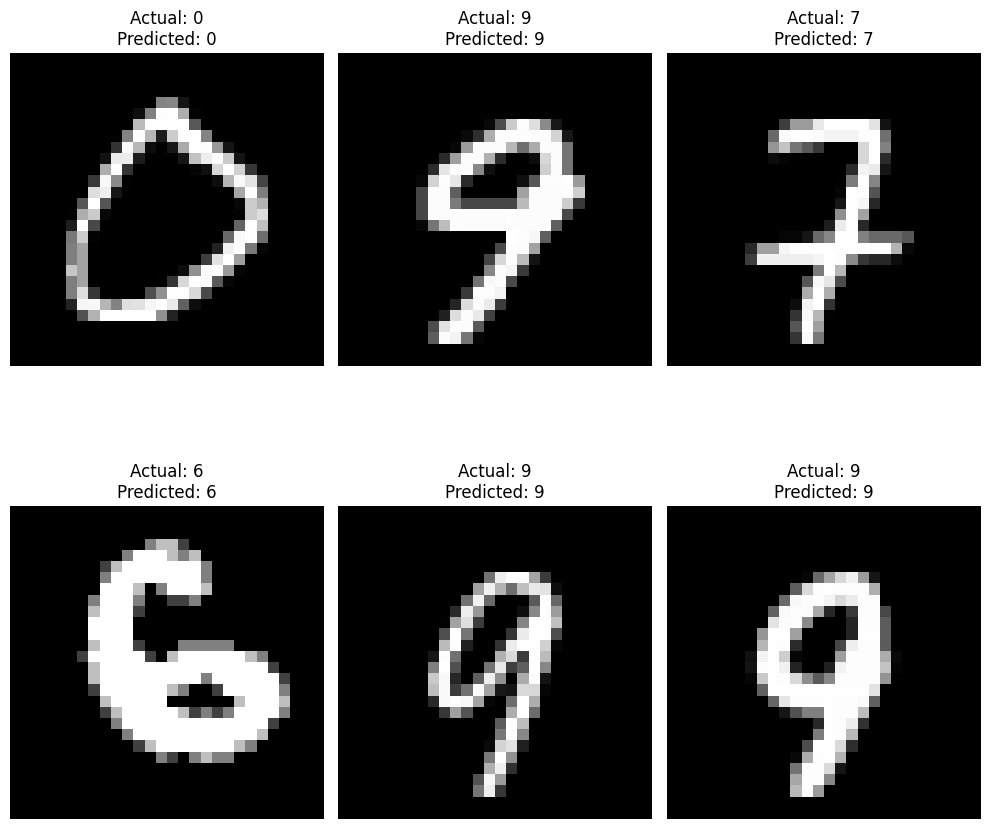

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.196752
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.219255
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.195154
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.182477
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.178820
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.184677
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.170975
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.173181
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.122615
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.153910

Test set: Average loss: 0.0043, Accuracy: 6580/10000 (66%)

Plotting top 6 confused images:


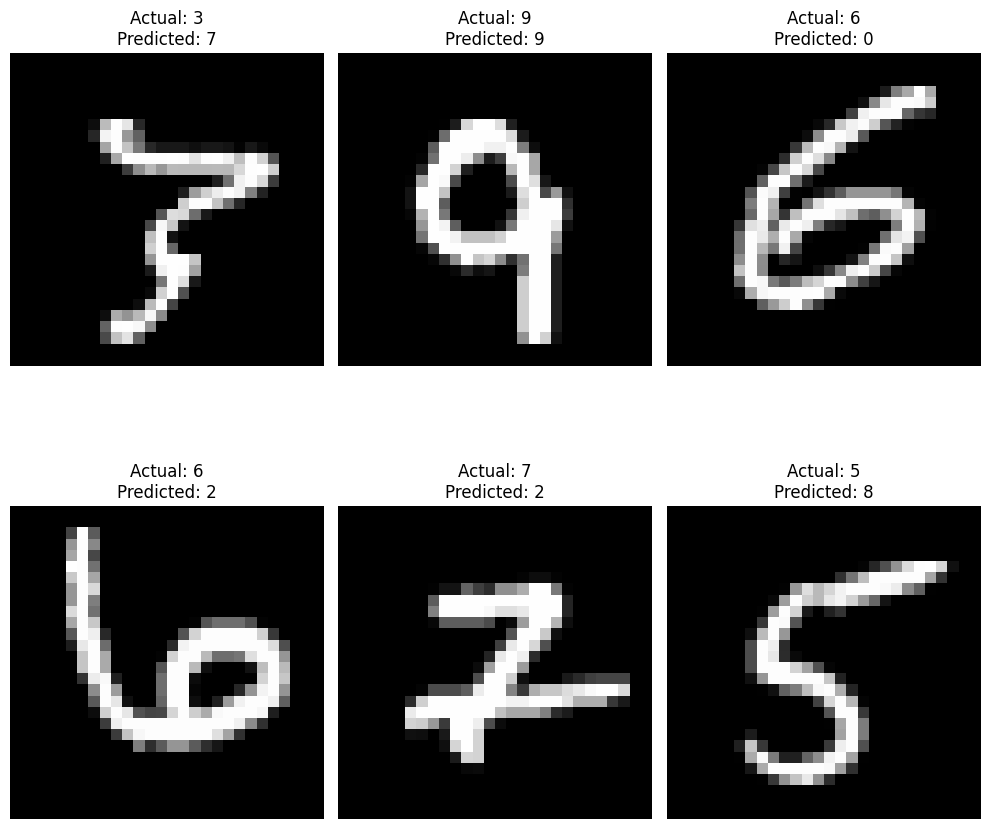

[I 2024-03-23 06:52:39,849] Trial 1 finished with value: 65.8 and parameters: {'lr': 9.292976613146279e-05, 'momentum': 0.4}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.213246
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.089331
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.515108
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.968275
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.715028
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.695884
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.553380
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.405982
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.660465

Test set: Average loss: 0.0007, Accuracy: 8991/10000 (90%)

Plotting top 6 confused images:


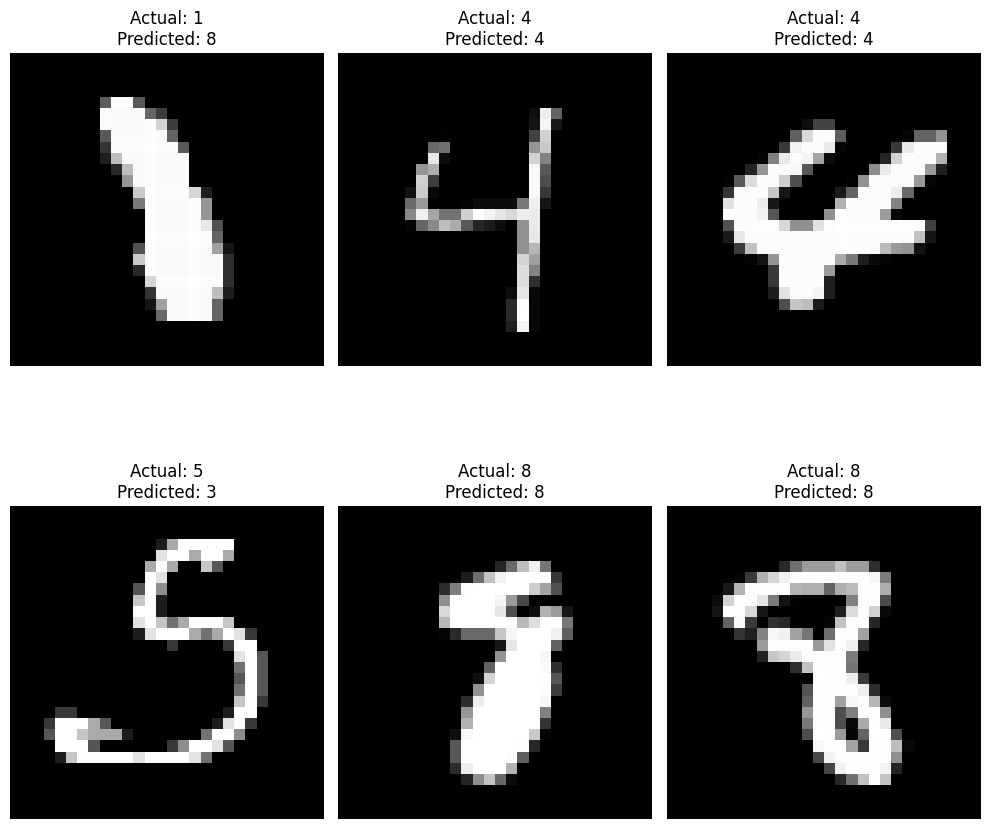

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.282146
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.380654
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.670315
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.237495
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.329767
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.340883
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.206385
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.172310
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.343791
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.156659

Test set: Average loss: 0.0005, Accuracy: 9258/10000 (93%)

Plotting top 6 confused images:


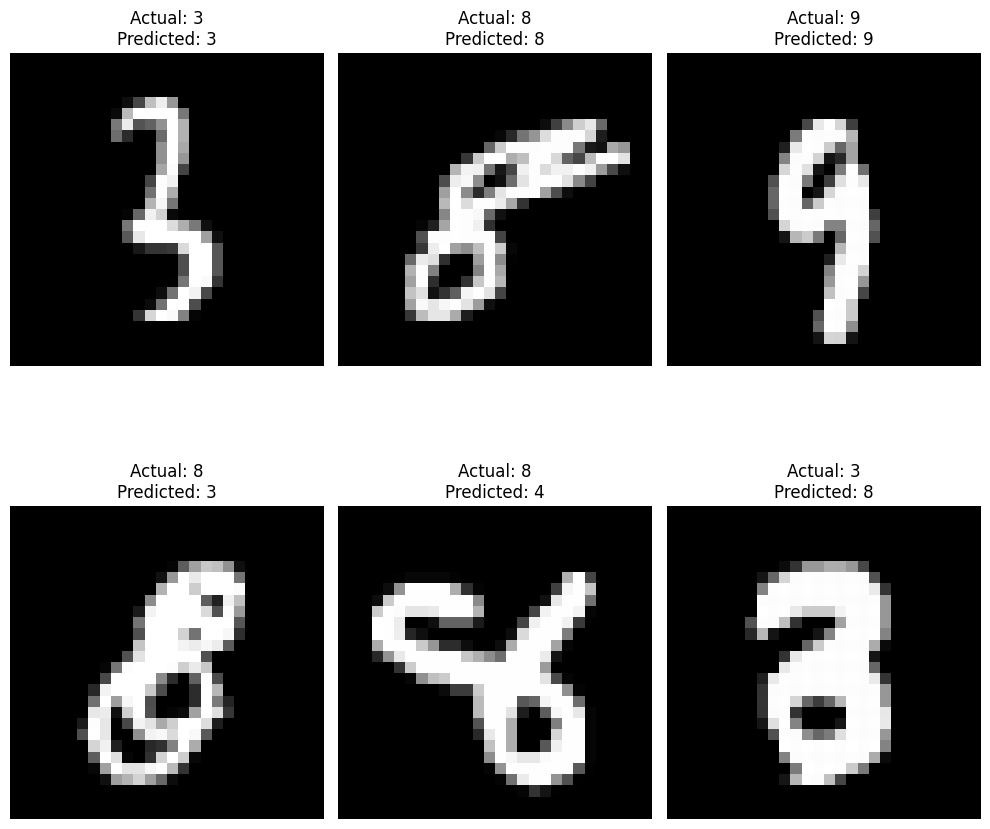

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.420547
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.231690
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.199905
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.125176
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.168473
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.220189
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.267279
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.547947
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.381713
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.361372

Test set: Average loss: 0.0004, Accuracy: 9393/10000 (94%)

Plotting top 6 confused images:


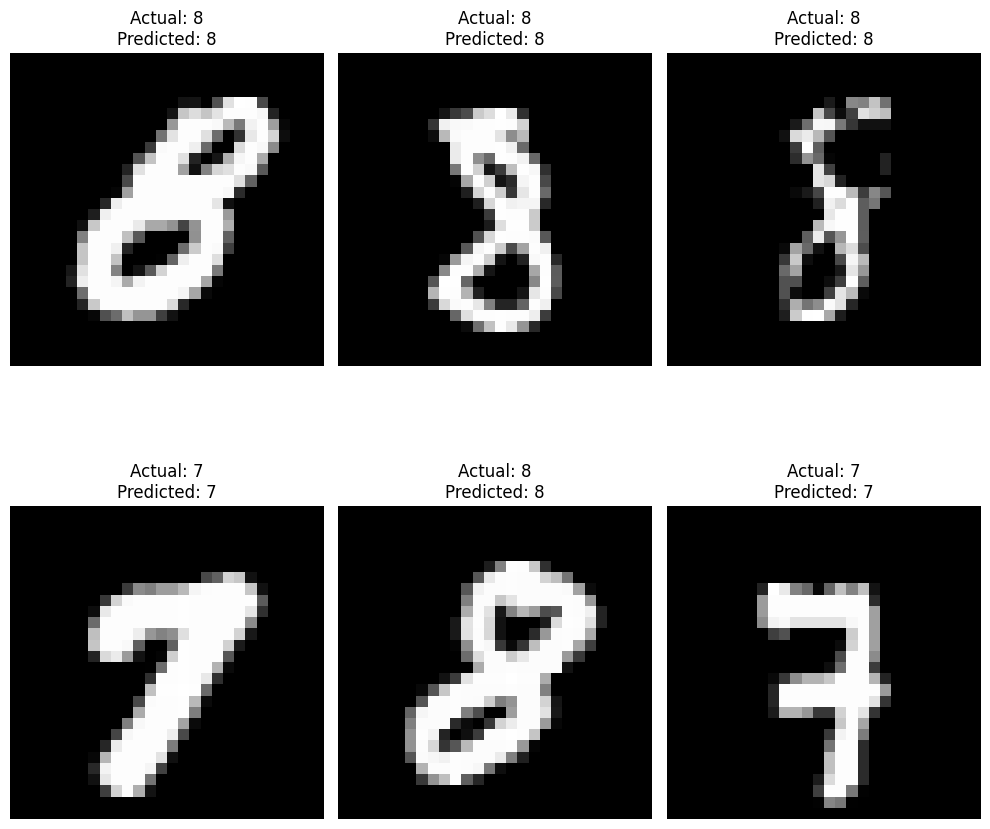

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.197061
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.208506
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.284489
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.303232
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.123174
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.191696
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.177819
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.086301
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.133743
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.185183

Test set: Average loss: 0.0003, Accuracy: 9511/10000 (95%)

Plotting top 6 confused images:


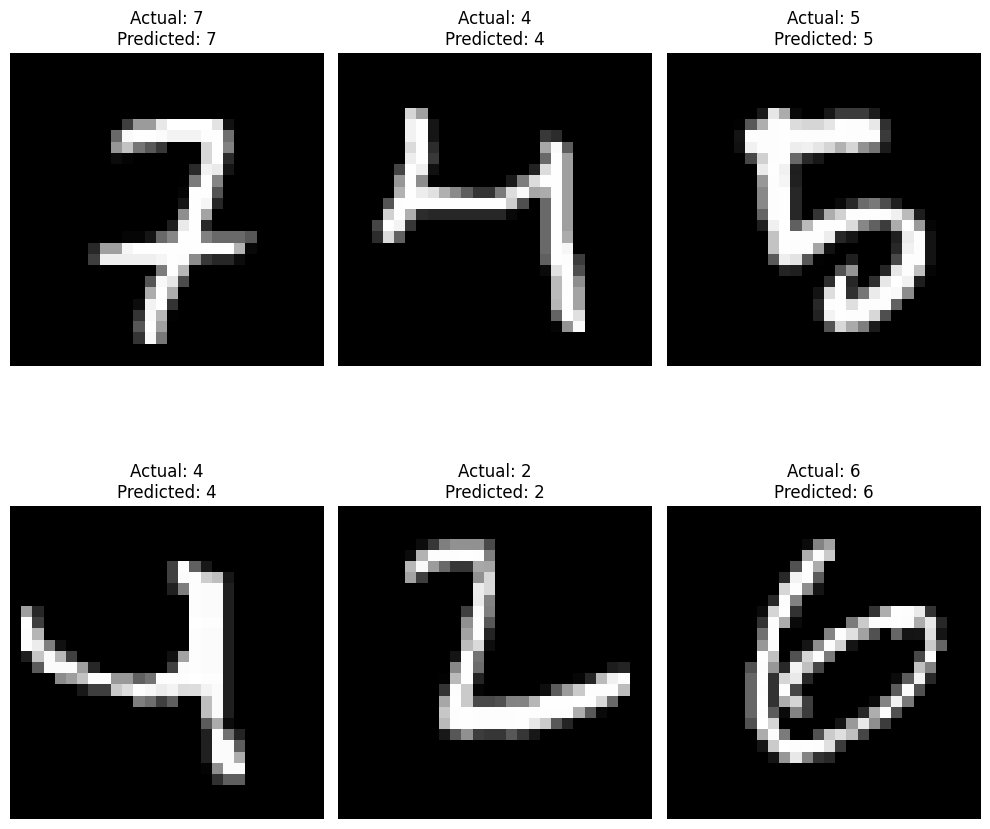

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.260717
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.119009
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.214054
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.158752
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.261411
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.191528
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.132823
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.149341
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.207799
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.364203

Test set: Average loss: 0.0002, Accuracy: 9652/10000 (97%)

Plotting top 6 confused images:


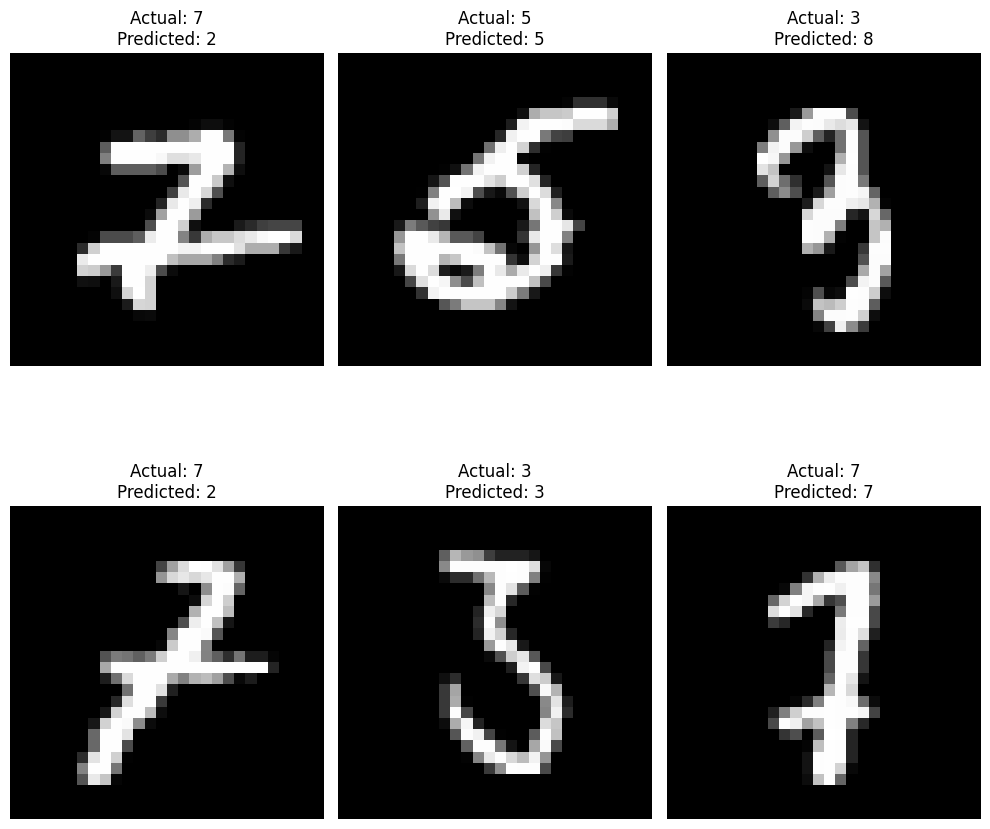

[I 2024-03-23 06:53:47,807] Trial 2 finished with value: 96.52 and parameters: {'lr': 0.0009436471070739716, 'momentum': 0.8}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.269843
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.275443
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.259124
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.239904
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.209936
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.187097
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.138930
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.062207
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.042410

Test set: Average loss: 0.0039, Accuracy: 7203/10000 (72%)

Plotting top 6 confused images:


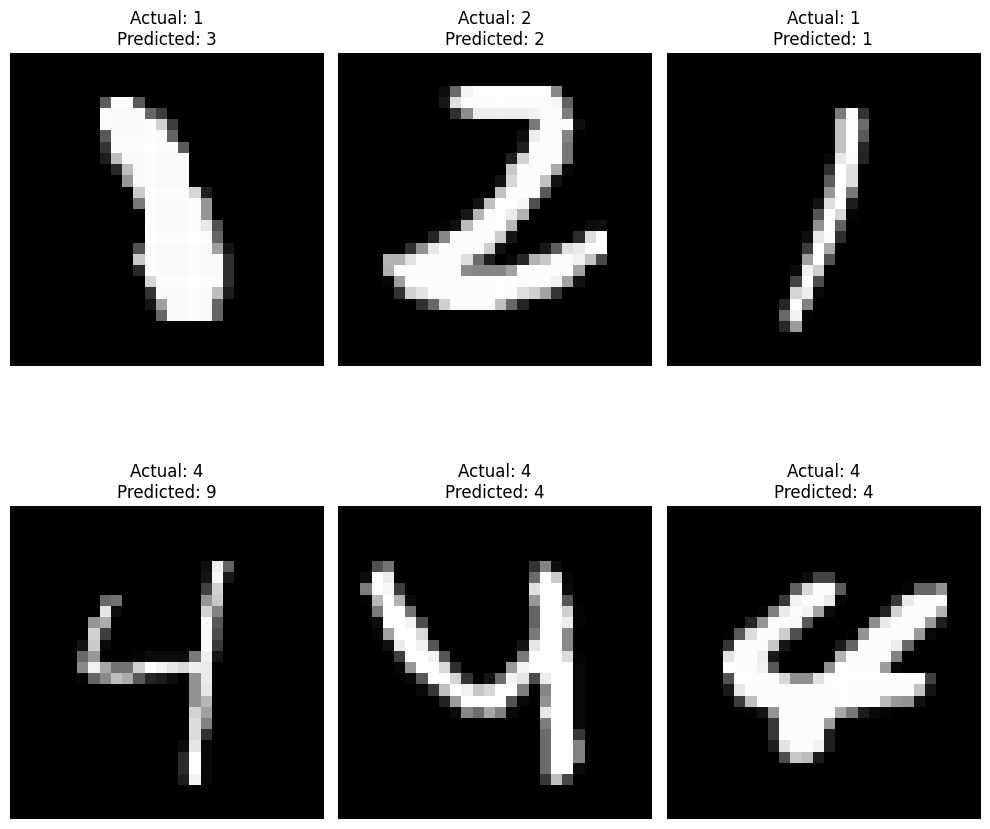

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.938914
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.883888
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.817598
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.529374
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.325272
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.213036
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.949957
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.788977
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.872362
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.646899

Test set: Average loss: 0.0013, Accuracy: 8408/10000 (84%)

Plotting top 6 confused images:


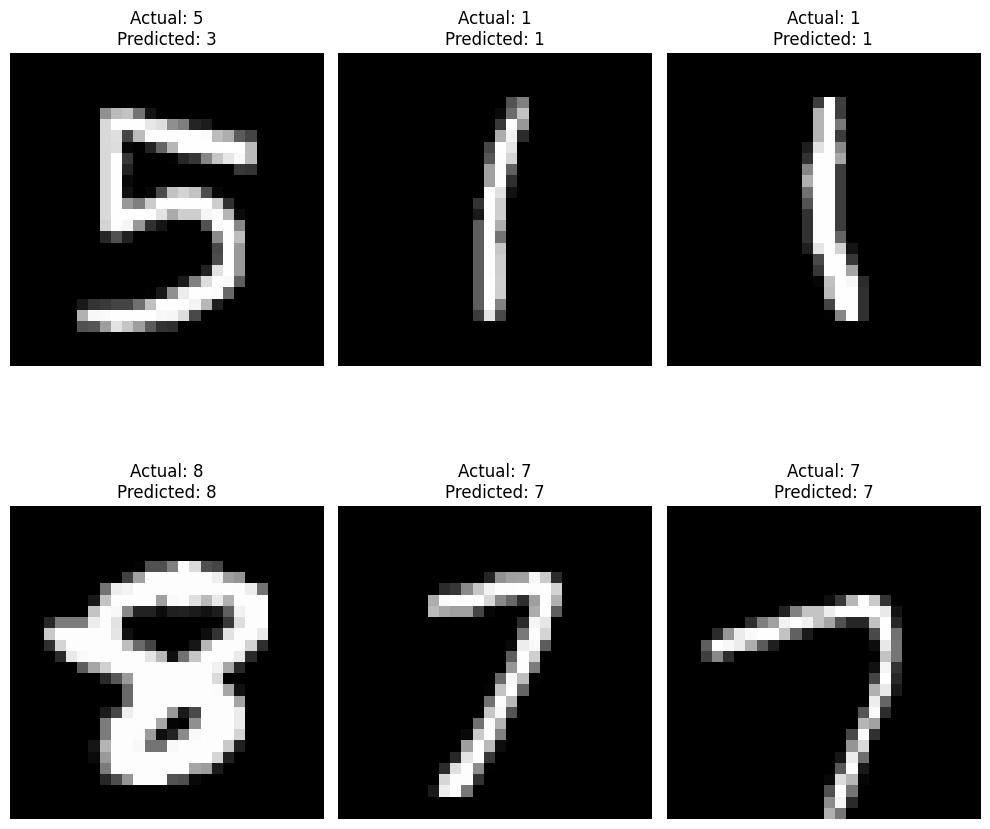

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.815373
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.706967
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.649421
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.627257
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.453994
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.482474
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.611746
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.672280
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.612384
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.657616

Test set: Average loss: 0.0008, Accuracy: 8841/10000 (88%)

Plotting top 6 confused images:


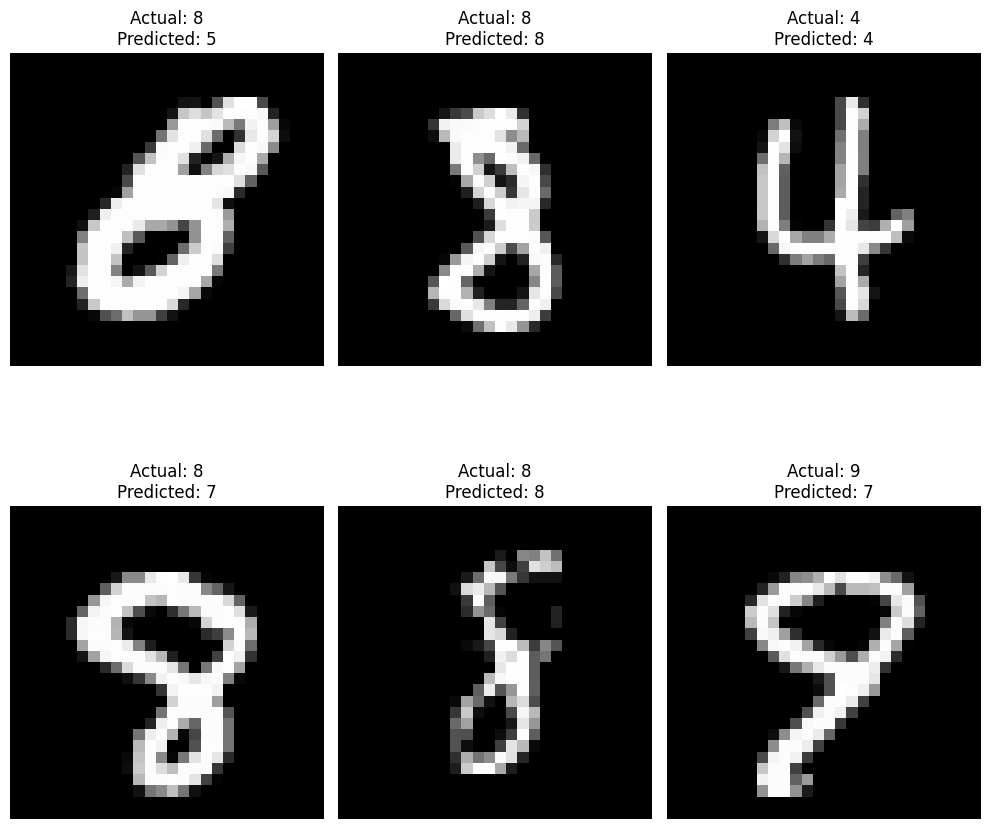

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.466894
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.462382
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.570715
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.717382
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.449190
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.498665
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.404068
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.264779
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.350055
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.458256

Test set: Average loss: 0.0007, Accuracy: 9024/10000 (90%)

Plotting top 6 confused images:


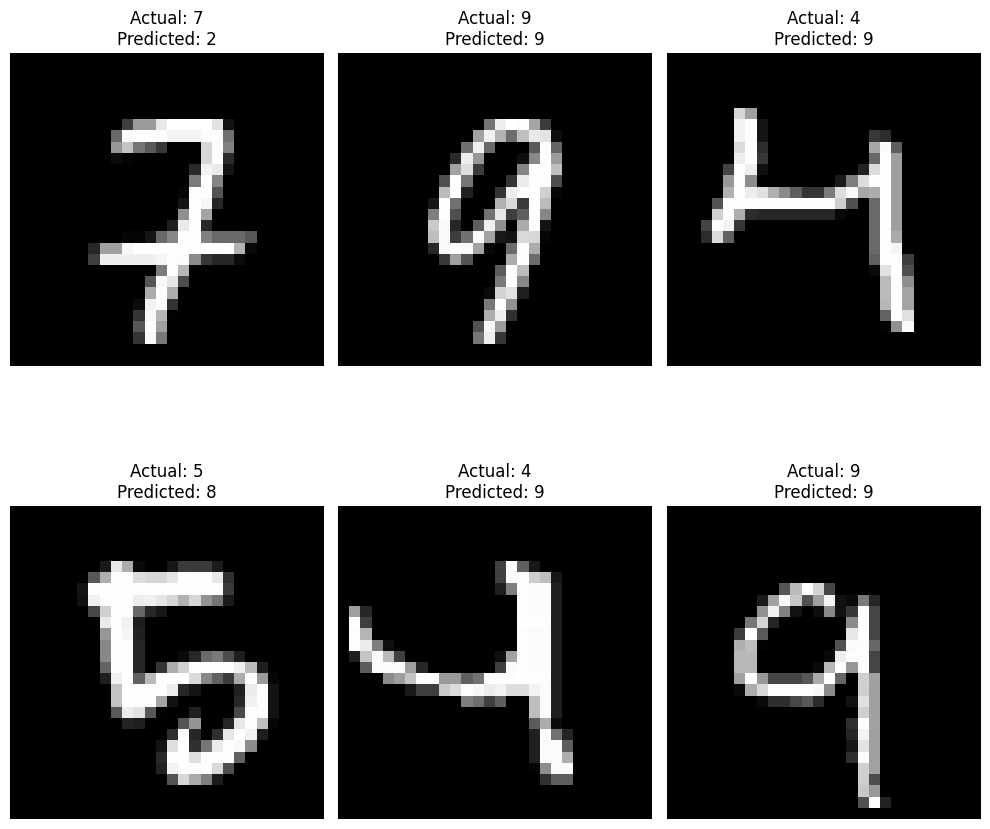

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.466506
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.366475
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.412131
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.312564
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.508704
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.359968
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.339578
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.436639
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.467559
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.551245

Test set: Average loss: 0.0006, Accuracy: 9109/10000 (91%)

Plotting top 6 confused images:


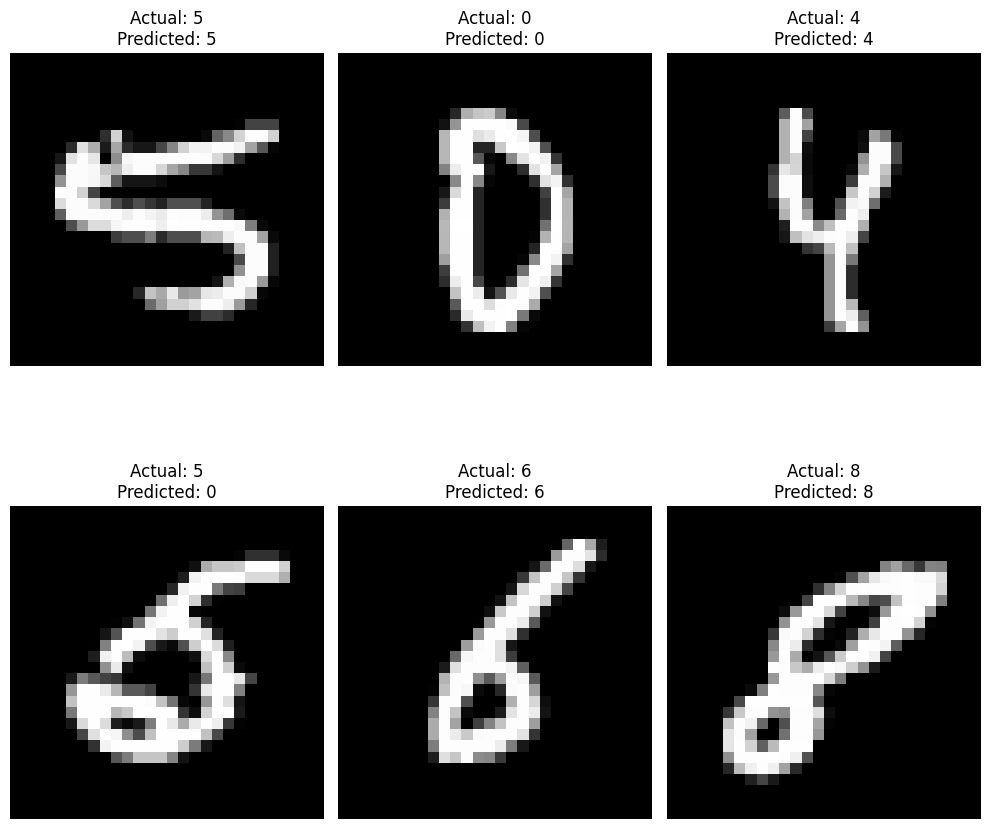

[I 2024-03-23 06:54:56,120] Trial 3 finished with value: 91.09 and parameters: {'lr': 0.0005464909125322812, 'momentum': 0.5}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282283
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.298355
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.294125
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.289097
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.288079
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.301597
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.282566
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.269085
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.293390

Test set: Average loss: 0.0046, Accuracy: 2187/10000 (22%)

Plotting top 6 confused images:


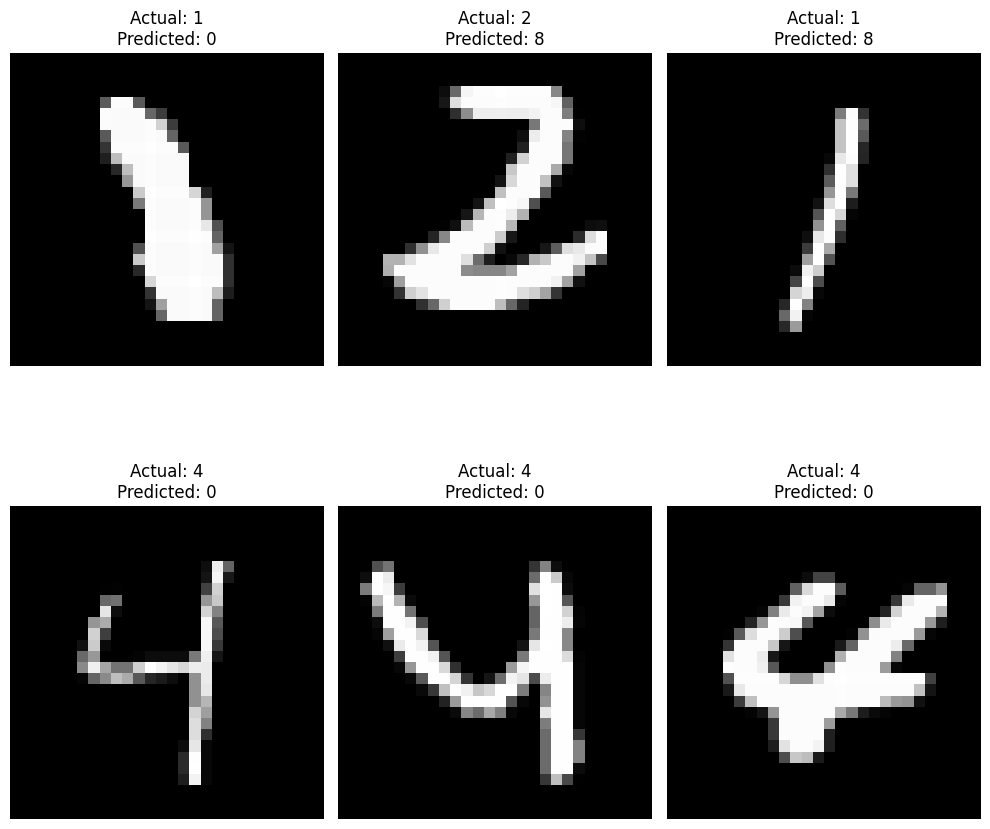

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.270658
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.291456
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.305463
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.281354
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.279892
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.280636
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.283862
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.281152
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.272710
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.267246

Test set: Average loss: 0.0045, Accuracy: 3531/10000 (35%)

Plotting top 6 confused images:


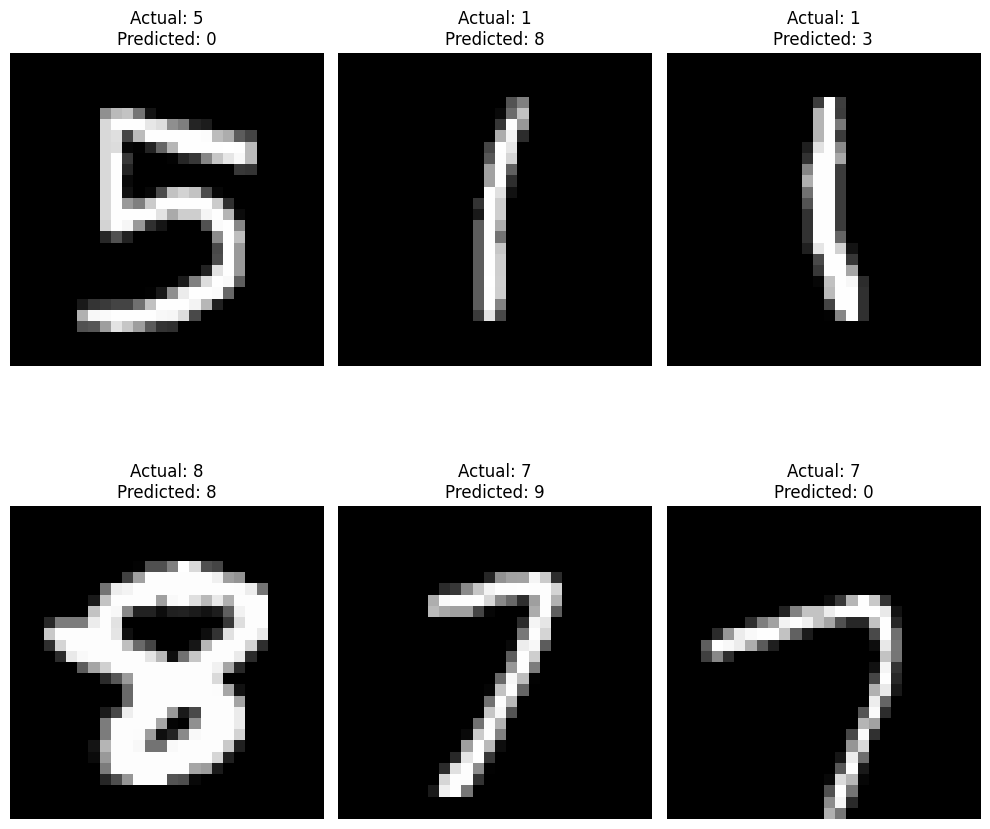

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.270633
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.269192
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.278533
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.273770
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.254149
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.259154
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.259644
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.277385
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.250813
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.262059

Test set: Average loss: 0.0045, Accuracy: 4733/10000 (47%)

Plotting top 6 confused images:


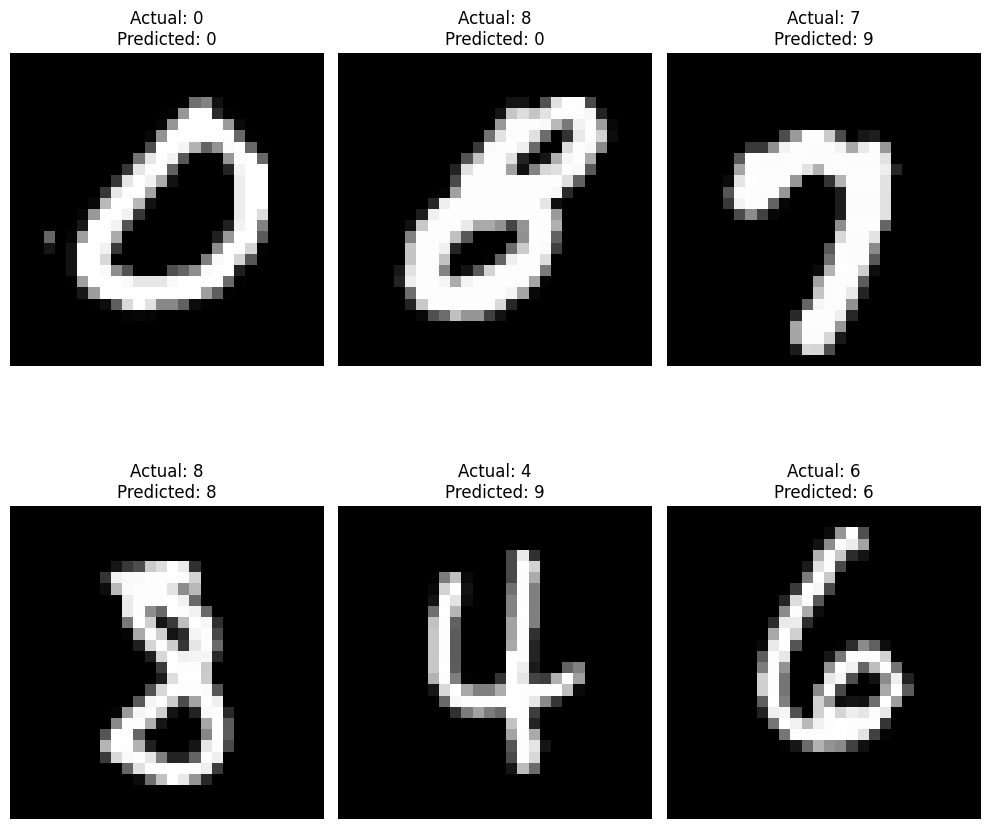

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.264739
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.251284
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.264824
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.267617
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.259708
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.253659
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.249077
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.247573
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.237002
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.252225

Test set: Average loss: 0.0045, Accuracy: 5471/10000 (55%)

Plotting top 6 confused images:


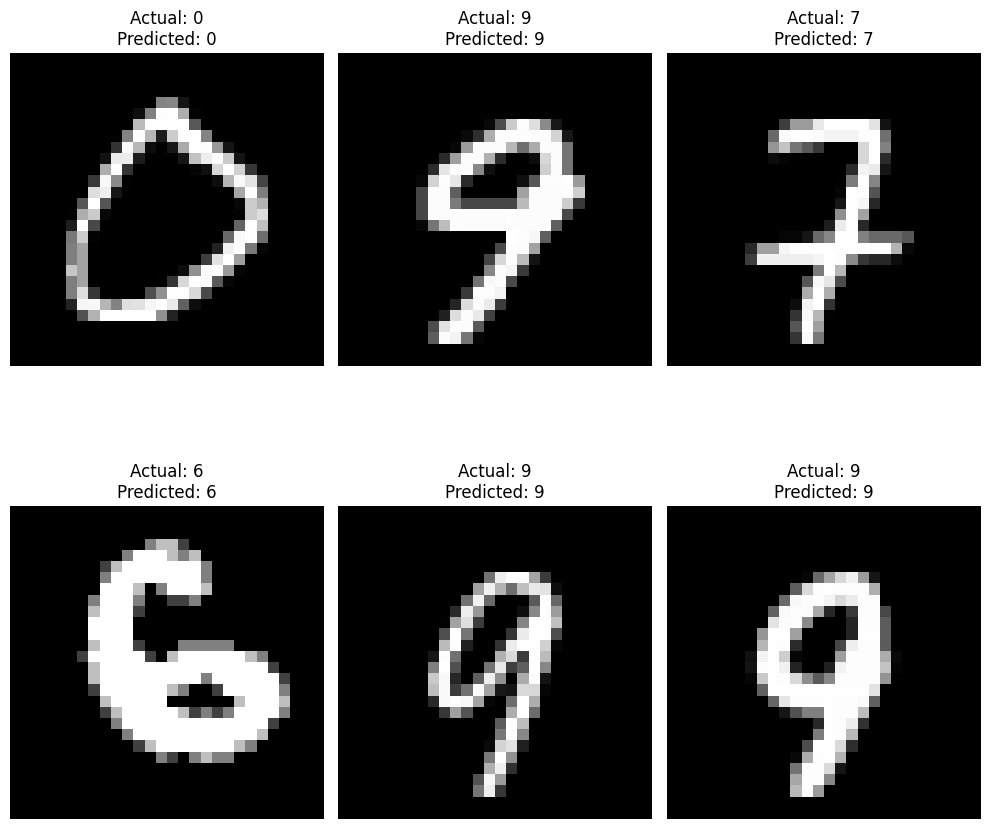

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.237321
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.255318
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.237775
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.233417
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.228499
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.236667
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.226619
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.229620
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.191104
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.222177

Test set: Average loss: 0.0044, Accuracy: 5930/10000 (59%)

Plotting top 6 confused images:


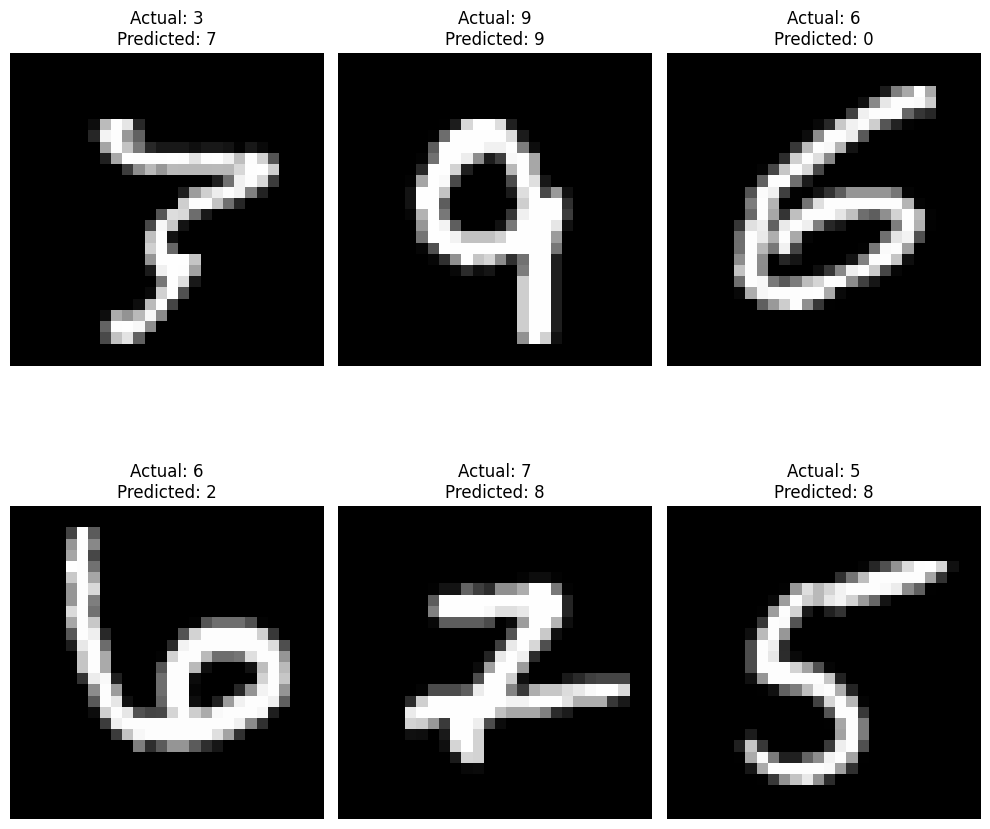

[I 2024-03-23 06:56:06,352] Trial 4 finished with value: 59.3 and parameters: {'lr': 3.300503893414251e-05, 'momentum': 0.7000000000000001}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.278146
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.290597
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.283398
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.275293
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.267777
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.270206
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.251421
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.228279
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.250087

Test set: Average loss: 0.0044, Accuracy: 5611/10000 (56%)

Plotting top 6 confused images:


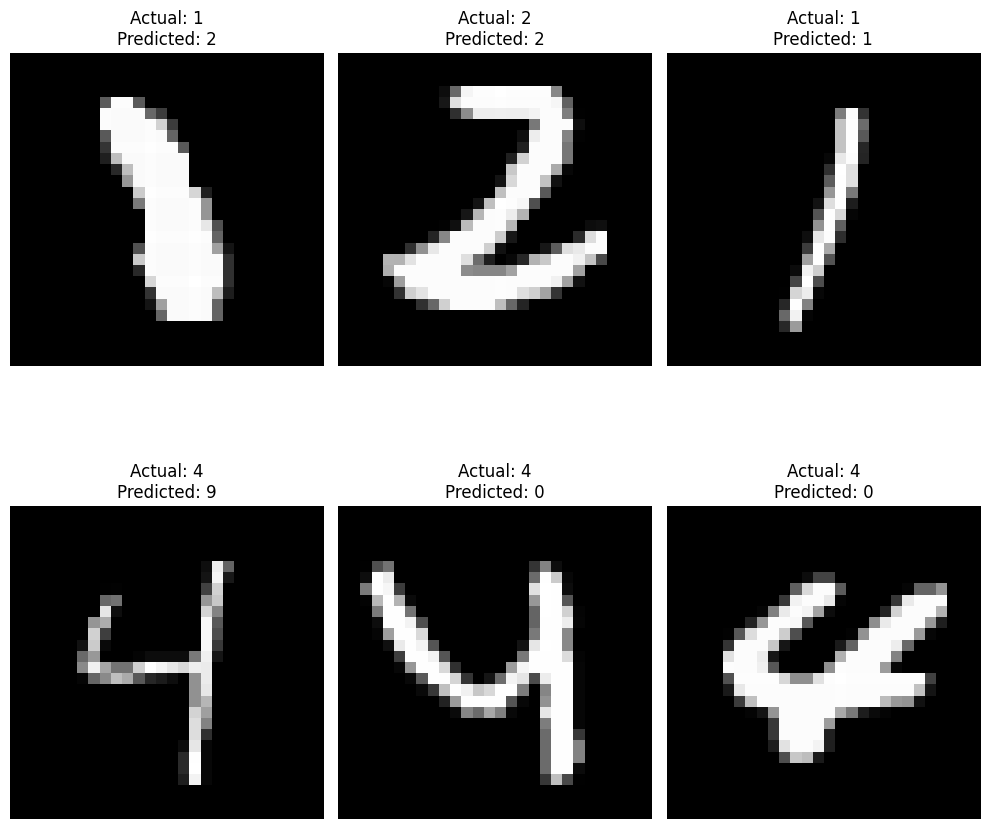

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.218270
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.233667
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.247038
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.203869
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.184516
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.176180
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.153966
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.126334
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.132368
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.063720

Test set: Average loss: 0.0041, Accuracy: 6945/10000 (69%)

Plotting top 6 confused images:


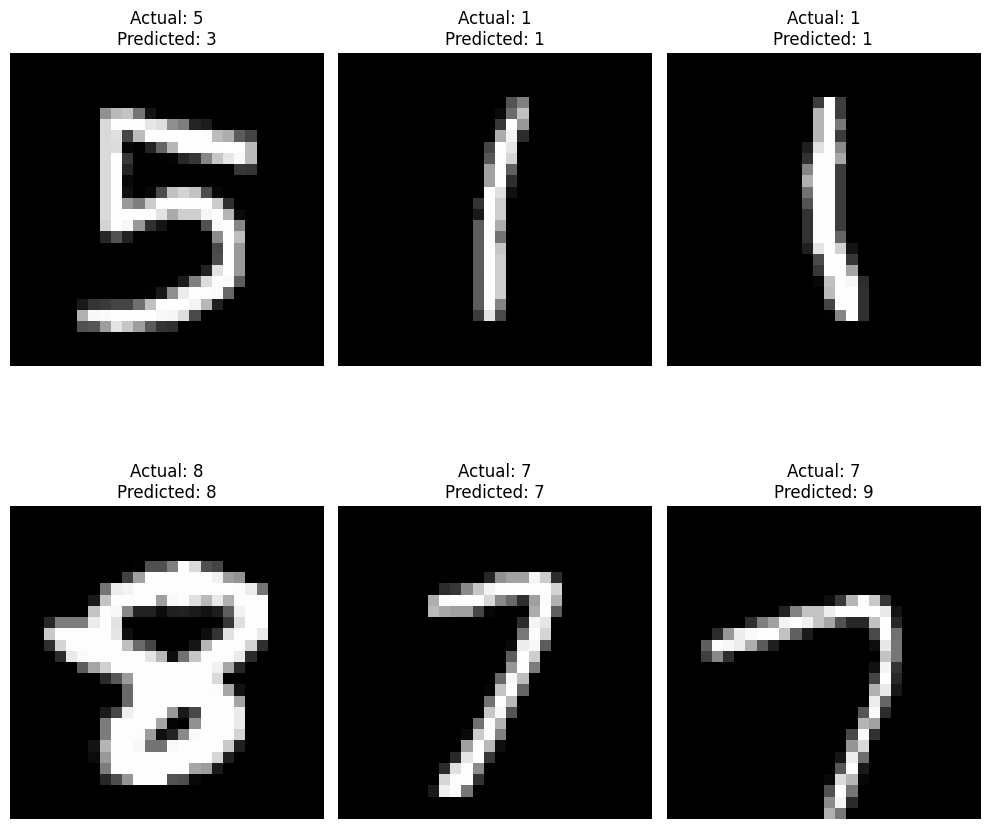

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.074271
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.031484
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.003081
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.013082
Train Epoch: 3 [25600/60000 (43%)]	Loss: 1.892073
Train Epoch: 3 [32000/60000 (53%)]	Loss: 1.829137
Train Epoch: 3 [38400/60000 (64%)]	Loss: 1.793135
Train Epoch: 3 [44800/60000 (75%)]	Loss: 1.749990
Train Epoch: 3 [51200/60000 (85%)]	Loss: 1.690404
Train Epoch: 3 [57600/60000 (96%)]	Loss: 1.655875

Test set: Average loss: 0.0030, Accuracy: 7671/10000 (77%)

Plotting top 6 confused images:


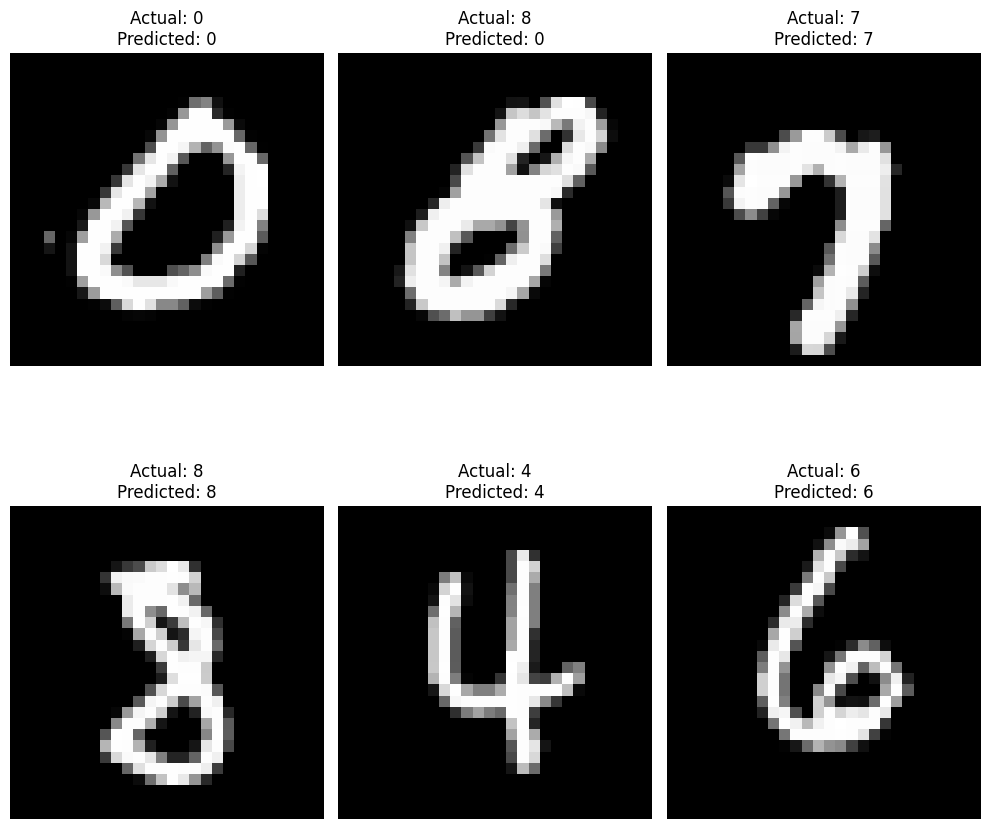

Train Epoch: 4 [0/60000 (0%)]	Loss: 1.567461
Train Epoch: 4 [6400/60000 (11%)]	Loss: 1.452666
Train Epoch: 4 [12800/60000 (21%)]	Loss: 1.449459
Train Epoch: 4 [19200/60000 (32%)]	Loss: 1.358632
Train Epoch: 4 [25600/60000 (43%)]	Loss: 1.159238
Train Epoch: 4 [32000/60000 (53%)]	Loss: 1.139501
Train Epoch: 4 [38400/60000 (64%)]	Loss: 1.081739
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.956065
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.850156
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.891117

Test set: Average loss: 0.0016, Accuracy: 8172/10000 (82%)

Plotting top 6 confused images:


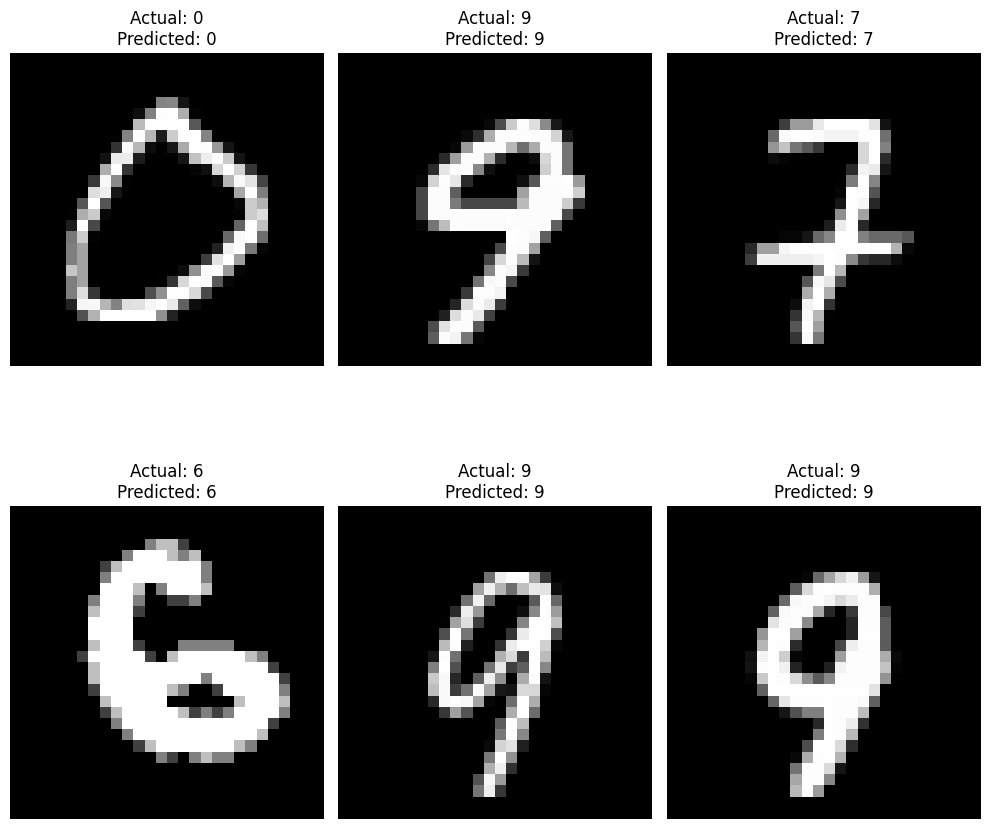

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.944378
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.882865
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.875551
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.694812
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.823470
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.612879
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.601128
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.683116
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.657338
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.677087

Test set: Average loss: 0.0011, Accuracy: 8540/10000 (85%)

Plotting top 6 confused images:


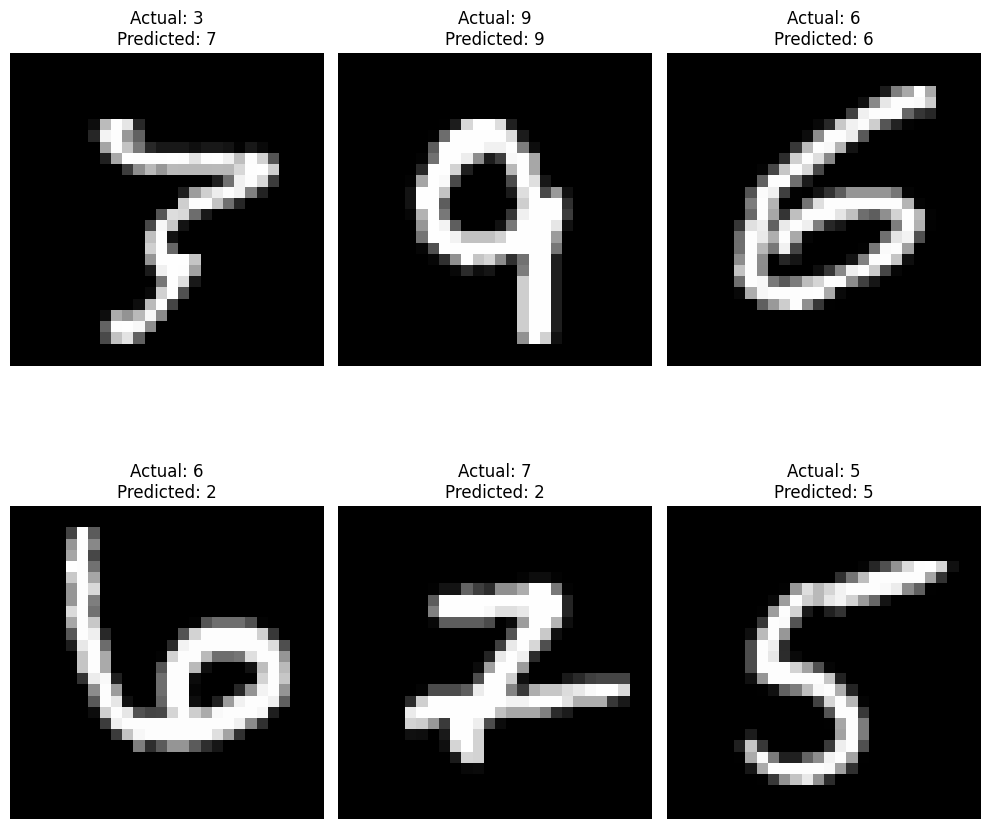

[I 2024-03-23 06:57:14,231] Trial 5 finished with value: 85.39999999999999 and parameters: {'lr': 4.788219632495636e-05, 'momentum': 0.9}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.269457
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.274388
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.257097
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.236334
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.203350
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.176488
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.122711
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.037459
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.005872

Test set: Average loss: 0.0038, Accuracy: 7255/10000 (73%)

Plotting top 6 confused images:


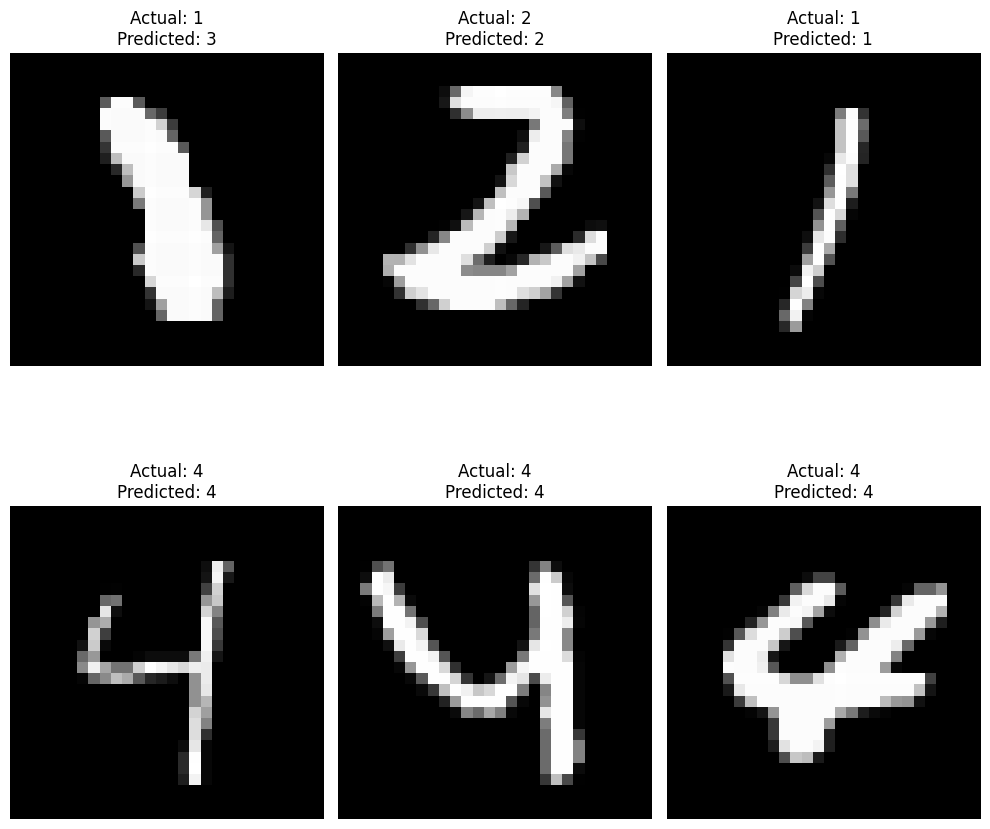

Train Epoch: 2 [0/60000 (0%)]	Loss: 1.888102
Train Epoch: 2 [6400/60000 (11%)]	Loss: 1.816117
Train Epoch: 2 [12800/60000 (21%)]	Loss: 1.731230
Train Epoch: 2 [19200/60000 (32%)]	Loss: 1.409599
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.207068
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.106517
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.853642
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.708746
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.811176
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.595605

Test set: Average loss: 0.0012, Accuracy: 8481/10000 (85%)

Plotting top 6 confused images:


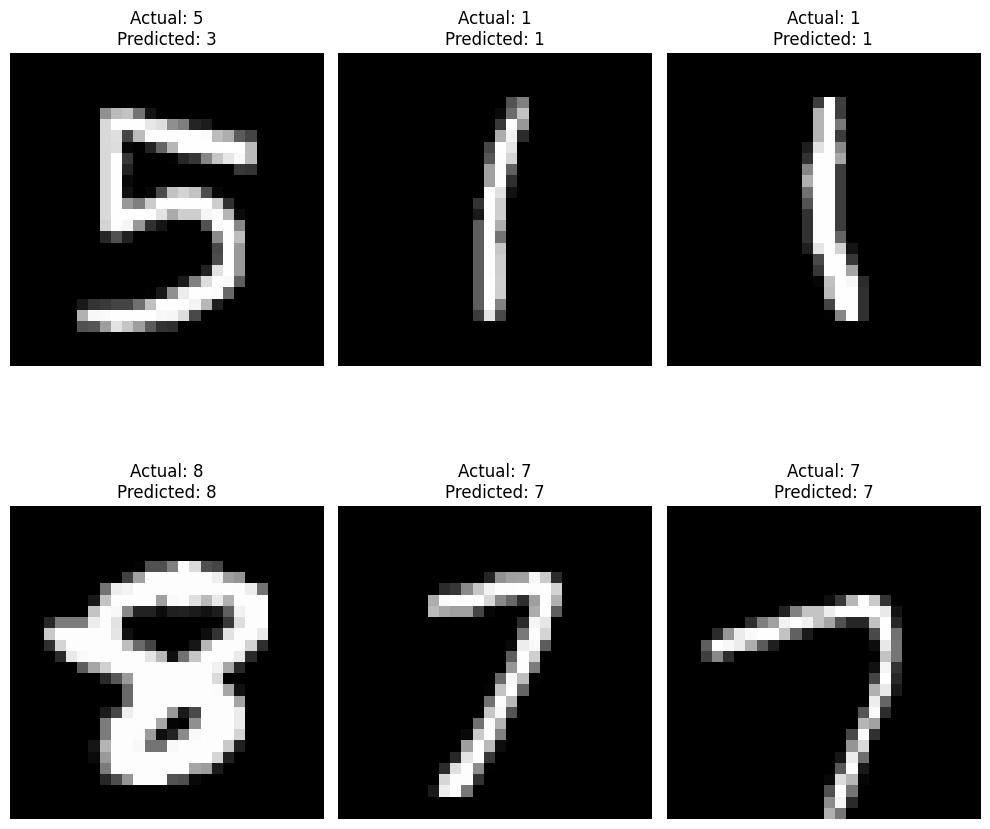

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.788176
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.666289
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.618574
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.581891
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.427055
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.453929
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.586308
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.653615
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.596378
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.644374

Test set: Average loss: 0.0008, Accuracy: 8898/10000 (89%)

Plotting top 6 confused images:


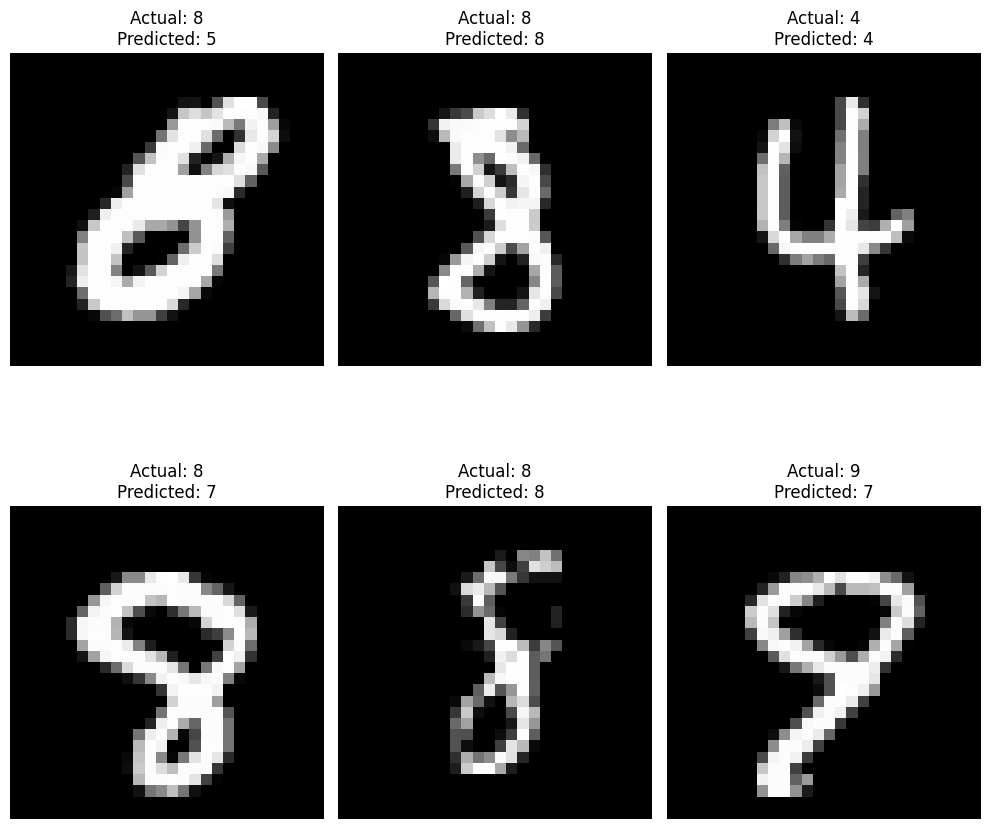

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.445532
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.443459
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.538514
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.697078
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.433215
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.486702
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.397235
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.253023
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.339428
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.439431

Test set: Average loss: 0.0007, Accuracy: 9045/10000 (90%)

Plotting top 6 confused images:


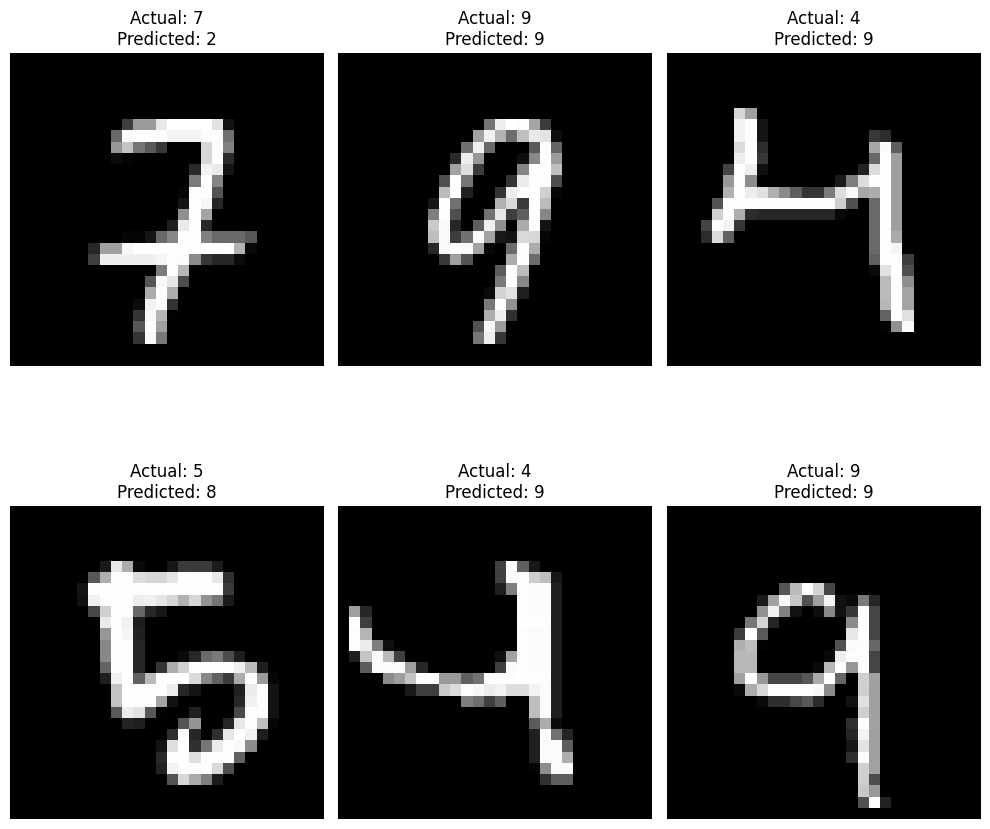

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.464150
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.352862
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.394673
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.311024
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.501294
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.354535
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.330167
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.428144
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.468256
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.524853

Test set: Average loss: 0.0006, Accuracy: 9148/10000 (91%)

Plotting top 6 confused images:


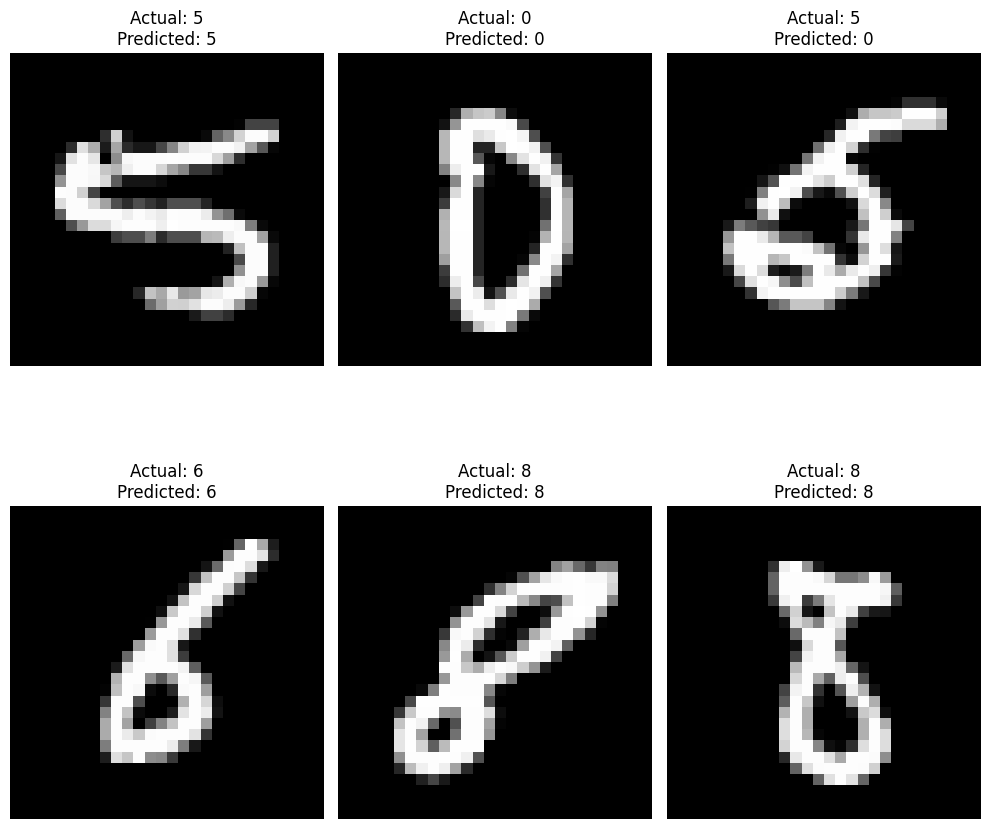

[I 2024-03-23 06:58:22,321] Trial 6 finished with value: 91.47999999999999 and parameters: {'lr': 0.000231309124019484, 'momentum': 0.8}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.282465
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.298705
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.294571
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.289635
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.288882
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.302908
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.283648
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.270443
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.294857

Test set: Average loss: 0.0046, Accuracy: 2070/10000 (21%)

Plotting top 6 confused images:


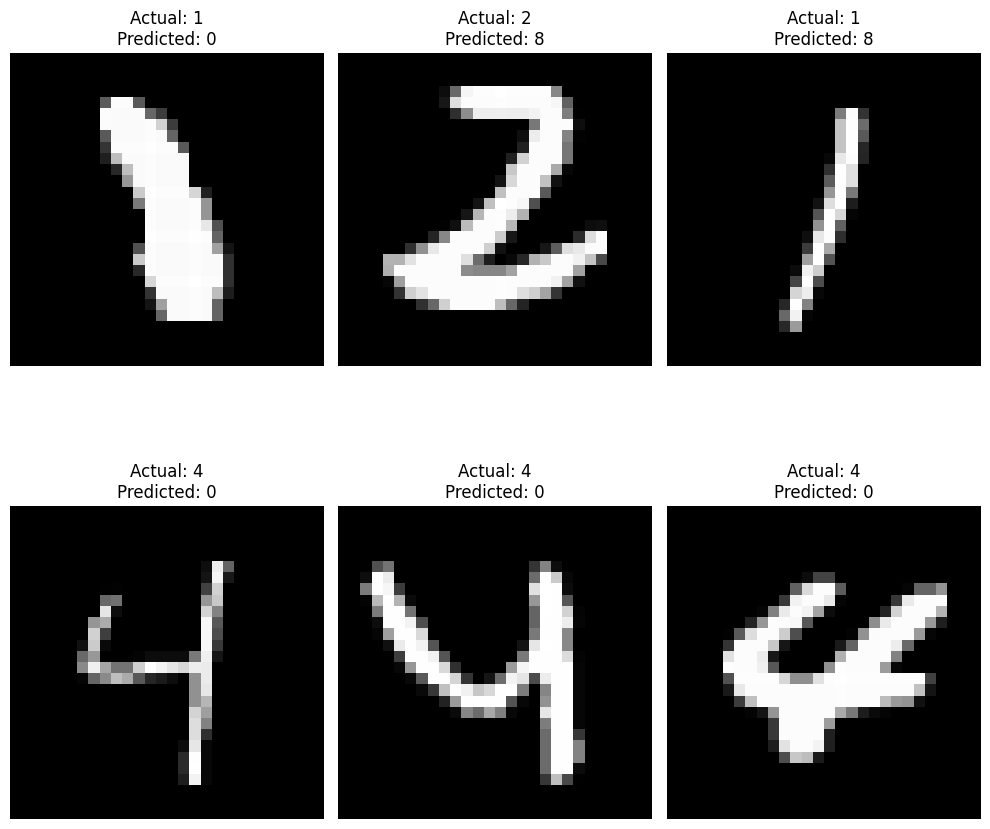

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.272403
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.293317
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.307366
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.283666
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.282581
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.283211
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.287245
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.284570
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.275749
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.271536

Test set: Average loss: 0.0045, Accuracy: 3056/10000 (31%)

Plotting top 6 confused images:


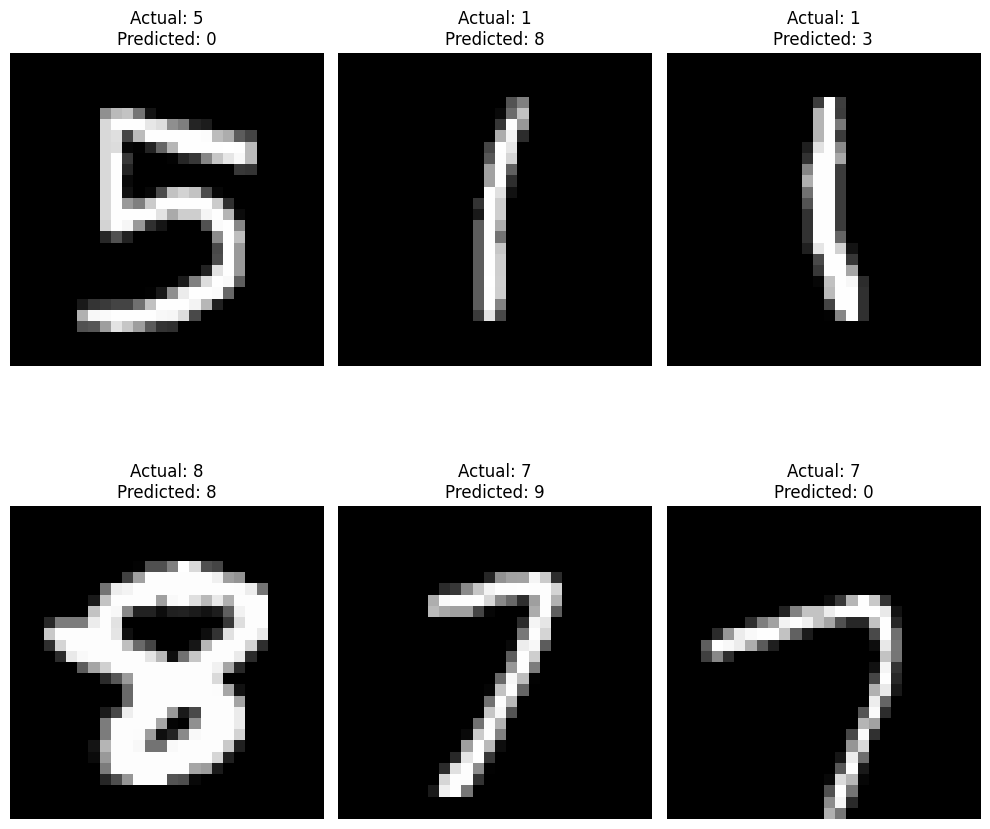

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.274412
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.273661
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.283548
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.278154
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.259192
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.264986
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.265603
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.283392
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.256648
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.267846

Test set: Average loss: 0.0045, Accuracy: 4242/10000 (42%)

Plotting top 6 confused images:


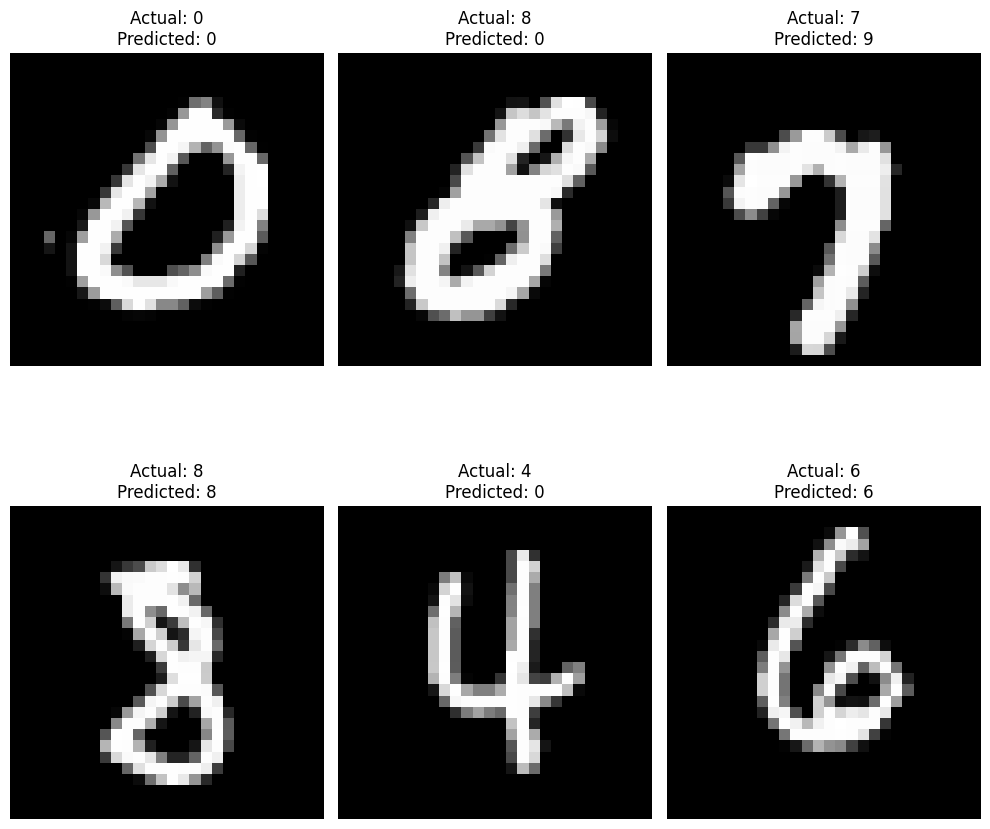

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.272145
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.258591
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.271663
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.275254
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.268027
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.262817
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.258121
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.257023
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.248059
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.263068

Test set: Average loss: 0.0045, Accuracy: 5081/10000 (51%)

Plotting top 6 confused images:


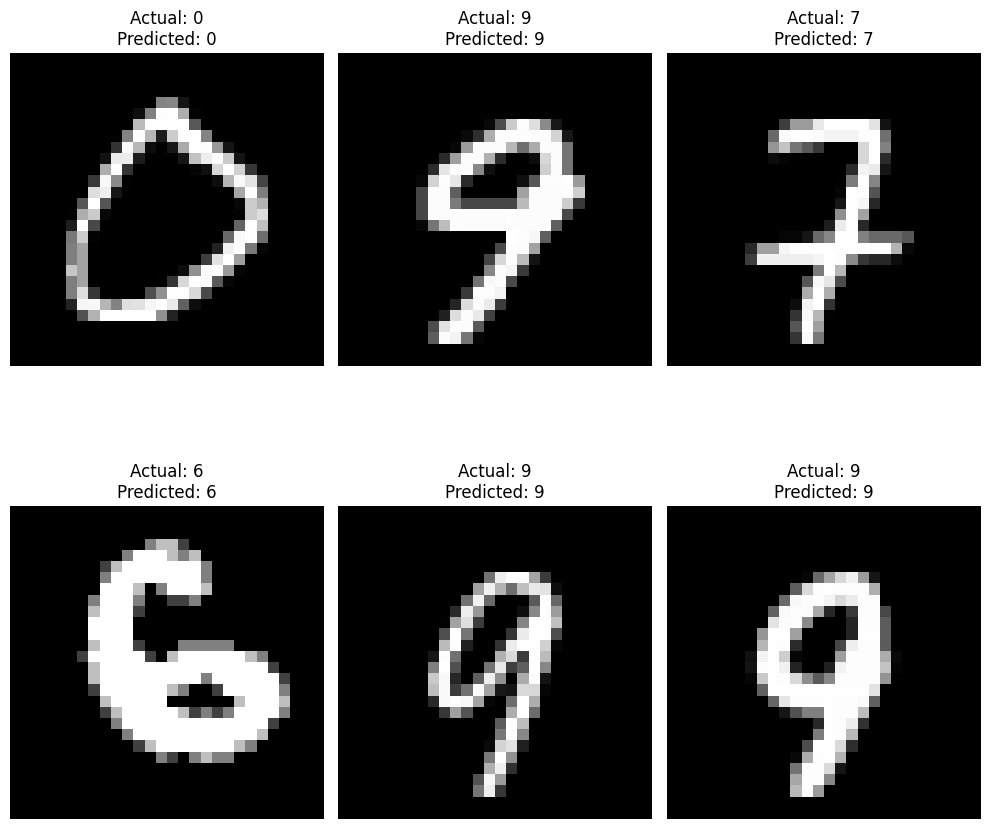

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.248904
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.265294
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.249688
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.247404
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.241949
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.250786
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.241803
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.244584
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.208782
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.240281

Test set: Average loss: 0.0045, Accuracy: 5596/10000 (56%)

Plotting top 6 confused images:


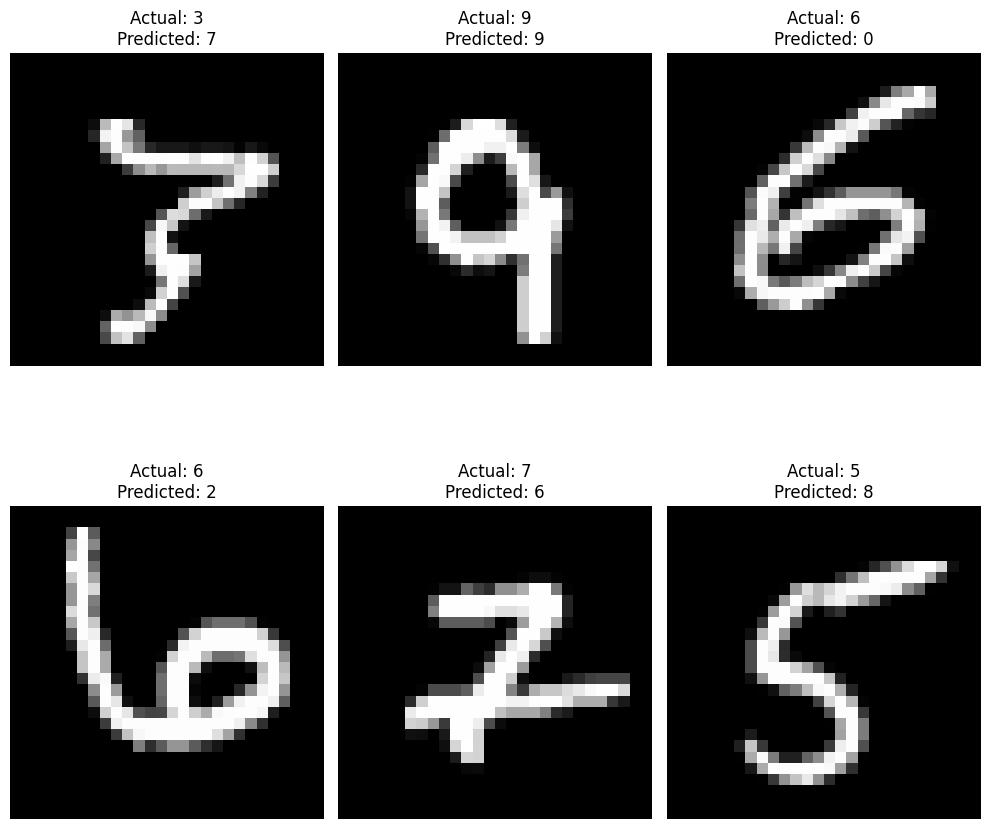

[I 2024-03-23 06:59:30,004] Trial 7 finished with value: 55.96 and parameters: {'lr': 5.605089955697701e-05, 'momentum': 0.4}. Best is trial 0 with value: 97.61.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.676500
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.006565
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.390519
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.736760
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.417527
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.462581
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.261967
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.365763
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.430270

Test set: Average loss: 0.0004, Accuracy: 9434/10000 (94%)

Plotting top 6 confused images:


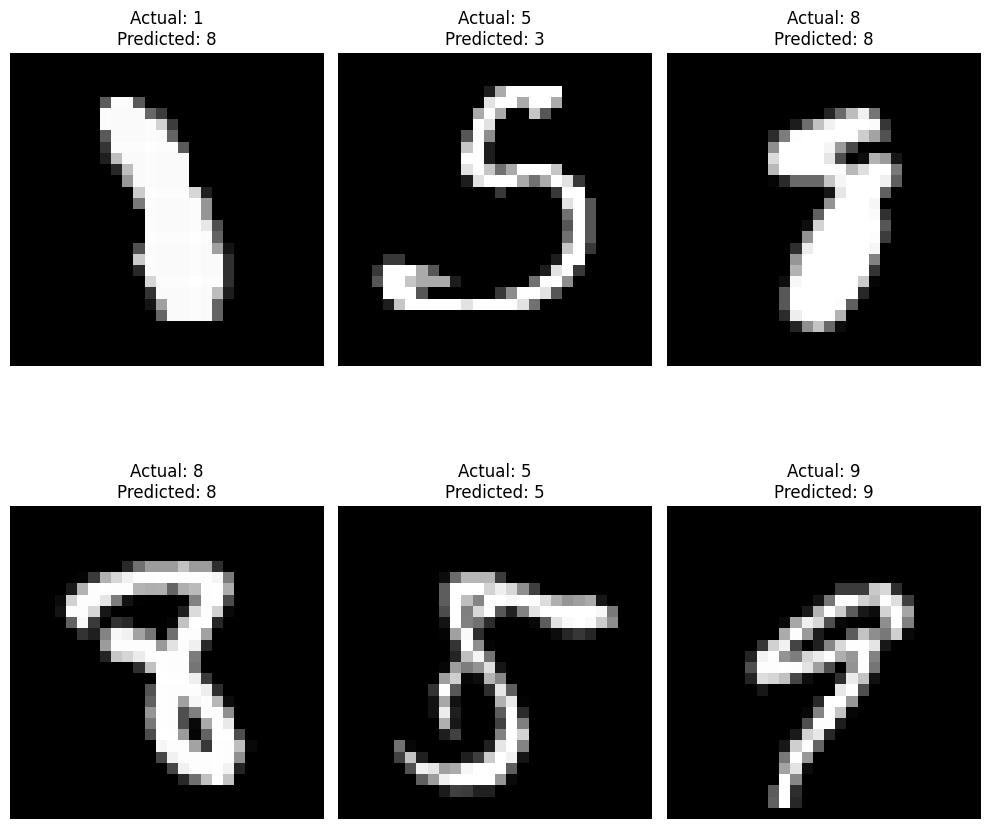

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.142509
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.187271
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.408495
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.071621
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.205379
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.201340
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.108681
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.070516
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.176915
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.155435

Test set: Average loss: 0.0003, Accuracy: 9580/10000 (96%)

Plotting top 6 confused images:


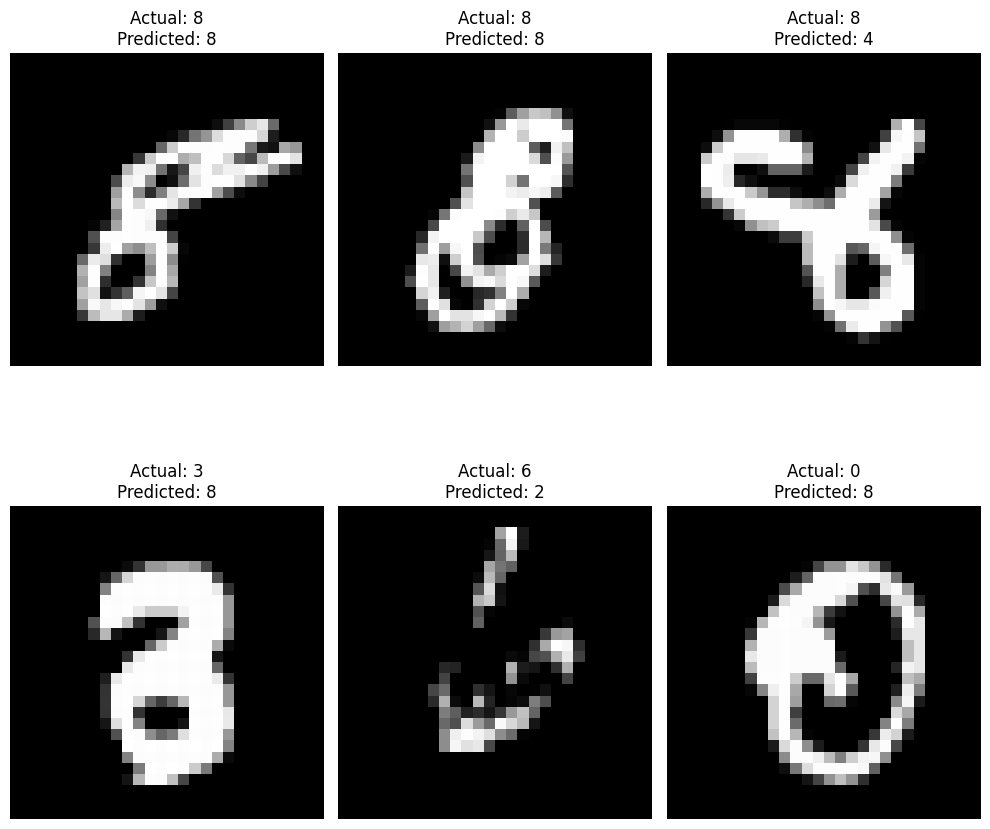

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.214447
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.054008
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.126421
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.049976
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.076830
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.172103
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.151478
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.363088
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.214027
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.152873

Test set: Average loss: 0.0002, Accuracy: 9719/10000 (97%)

Plotting top 6 confused images:


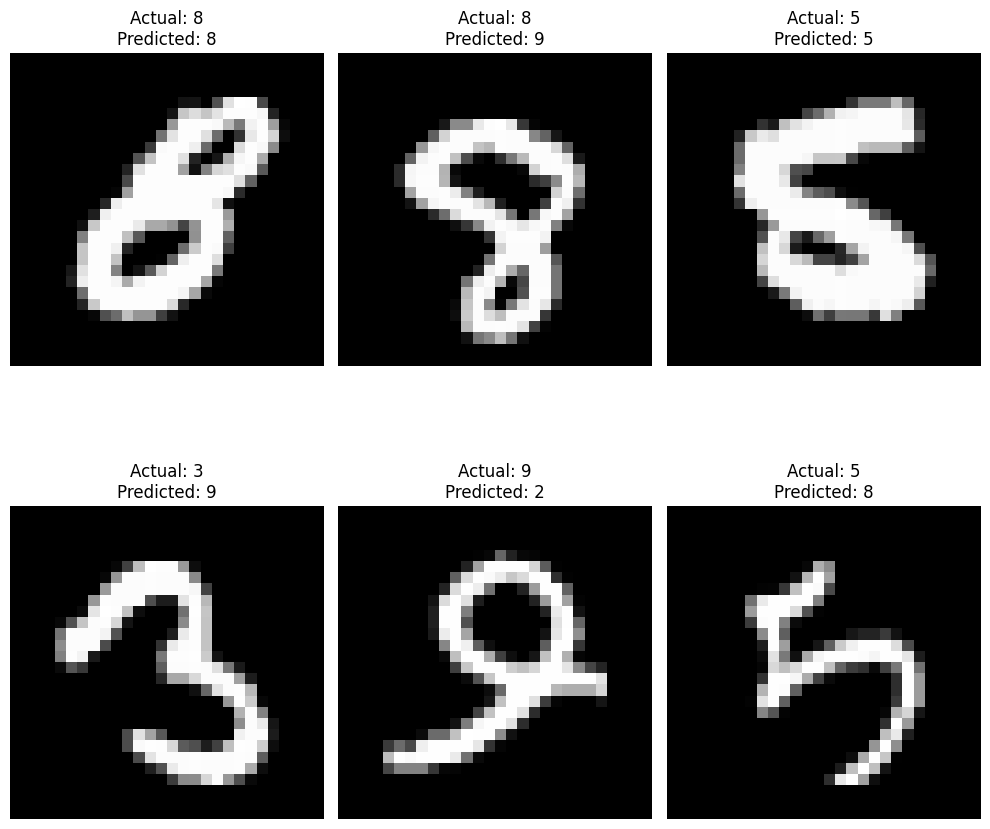

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.096903
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.150832
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.114160
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.245284
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.034752
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.133729
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.077754
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.041670
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.045164
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.134226

Test set: Average loss: 0.0002, Accuracy: 9728/10000 (97%)

Plotting top 6 confused images:


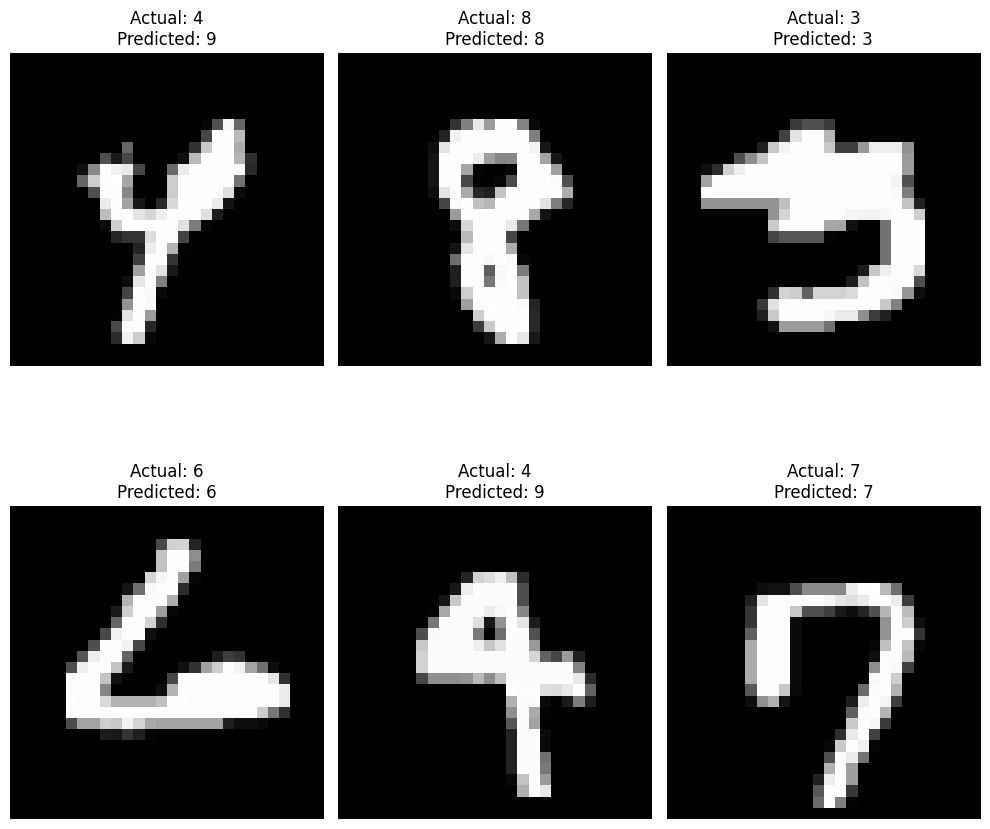

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.165339
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.034468
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.136547
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.084188
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.196601
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.080339
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.044839
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.107673
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.065455
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.328734

Test set: Average loss: 0.0001, Accuracy: 9817/10000 (98%)

Plotting top 6 confused images:


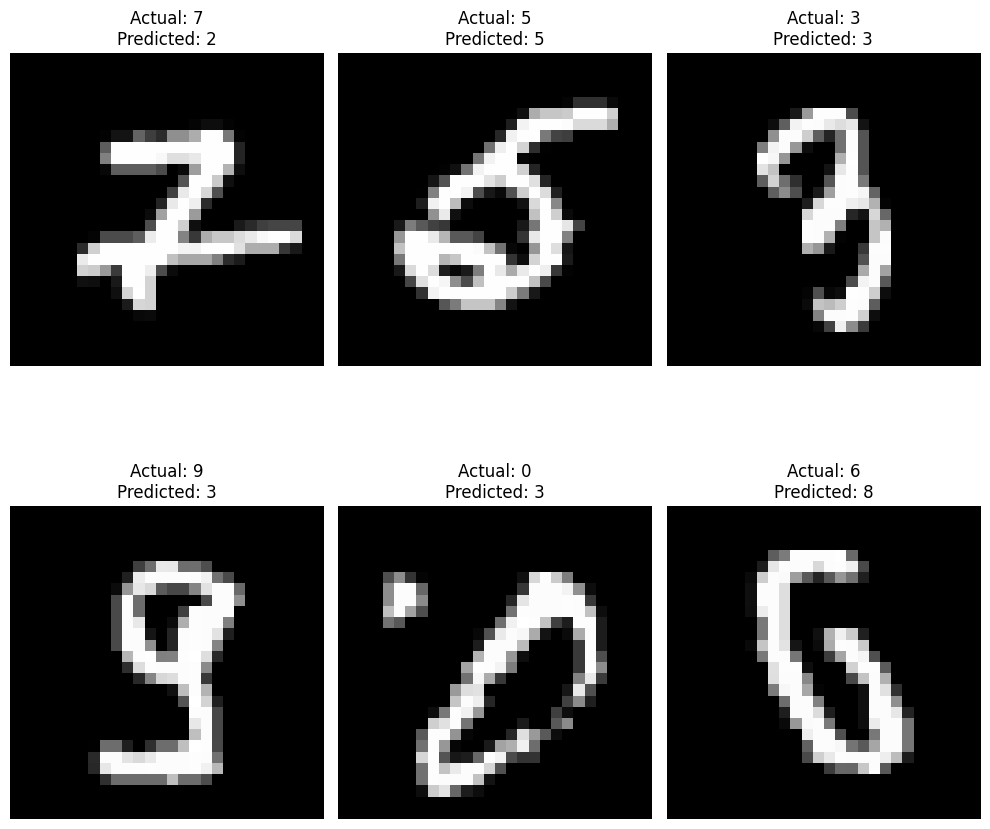

[I 2024-03-23 07:00:37,764] Trial 8 finished with value: 98.17 and parameters: {'lr': 0.007499999591366788, 'momentum': 0.4}. Best is trial 8 with value: 98.17.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.273688
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.282916
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.271764
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.258869
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.242564
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.234872
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.206793
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.165334
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.178865

Test set: Average loss: 0.0043, Accuracy: 6595/10000 (66%)

Plotting top 6 confused images:


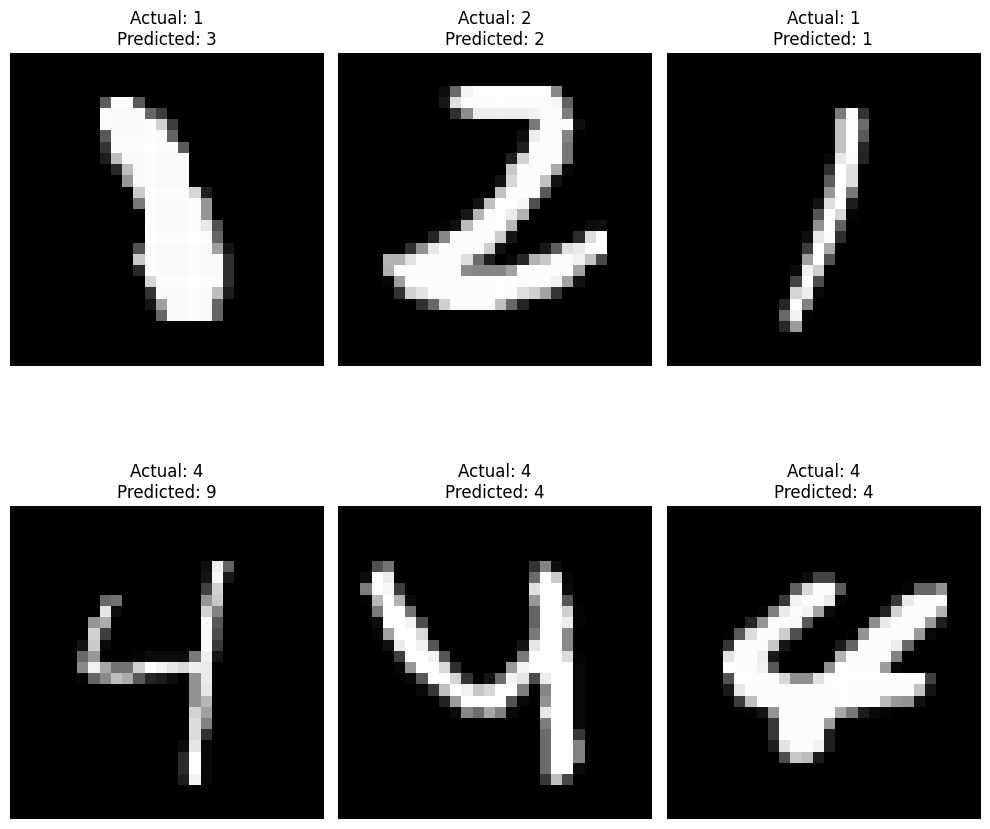

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.126443
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.126863
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.127117
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.015776
Train Epoch: 2 [25600/60000 (43%)]	Loss: 1.921585
Train Epoch: 2 [32000/60000 (53%)]	Loss: 1.873741
Train Epoch: 2 [38400/60000 (64%)]	Loss: 1.722742
Train Epoch: 2 [44800/60000 (75%)]	Loss: 1.555490
Train Epoch: 2 [51200/60000 (85%)]	Loss: 1.535575
Train Epoch: 2 [57600/60000 (96%)]	Loss: 1.268248

Test set: Average loss: 0.0024, Accuracy: 7860/10000 (79%)

Plotting top 6 confused images:


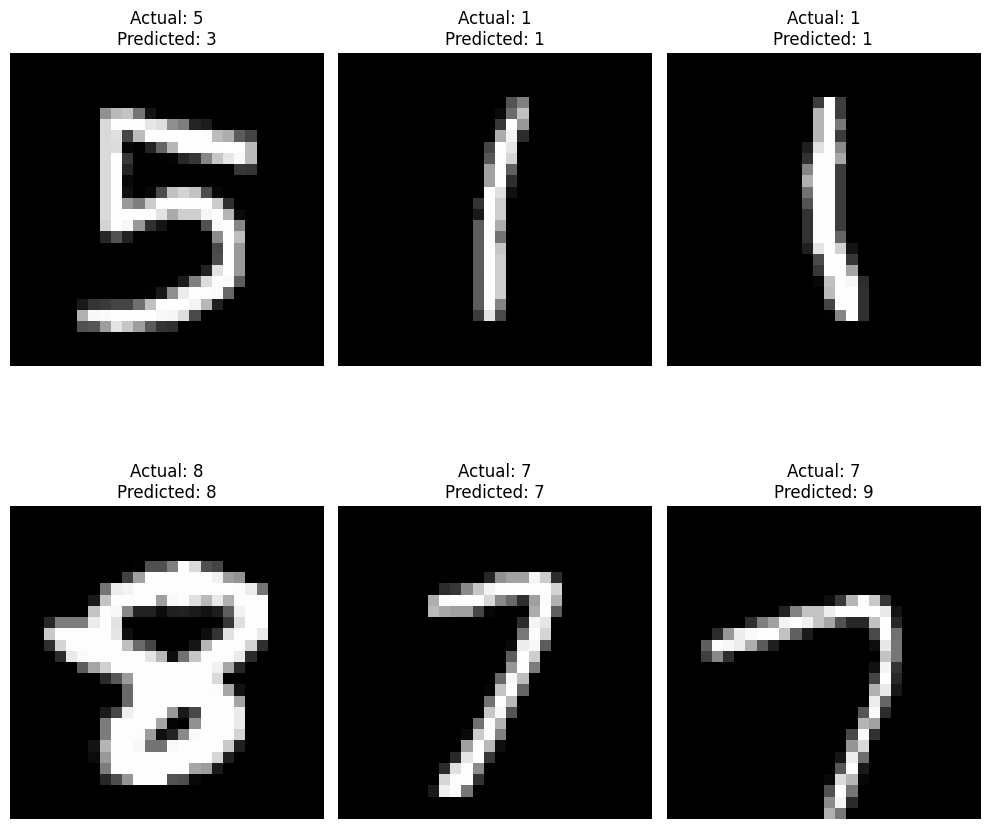

Train Epoch: 3 [0/60000 (0%)]	Loss: 1.337967
Train Epoch: 3 [6400/60000 (11%)]	Loss: 1.182648
Train Epoch: 3 [12800/60000 (21%)]	Loss: 1.040930
Train Epoch: 3 [19200/60000 (32%)]	Loss: 1.085764
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.790662
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.754774
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.832291
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.801202
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.796825
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.804509

Test set: Average loss: 0.0011, Accuracy: 8518/10000 (85%)

Plotting top 6 confused images:


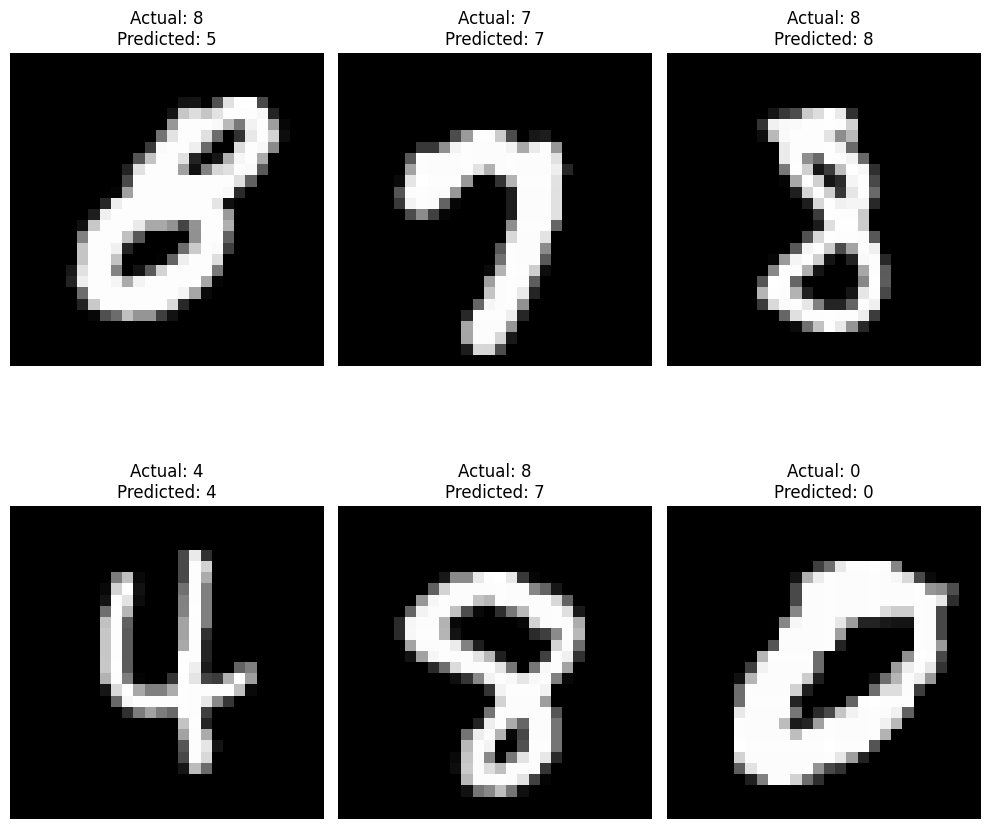

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.644153
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.638148
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.744950
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.834447
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.558000
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.602250
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.520633
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.395027
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.439376
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.542891

Test set: Average loss: 0.0008, Accuracy: 8826/10000 (88%)

Plotting top 6 confused images:


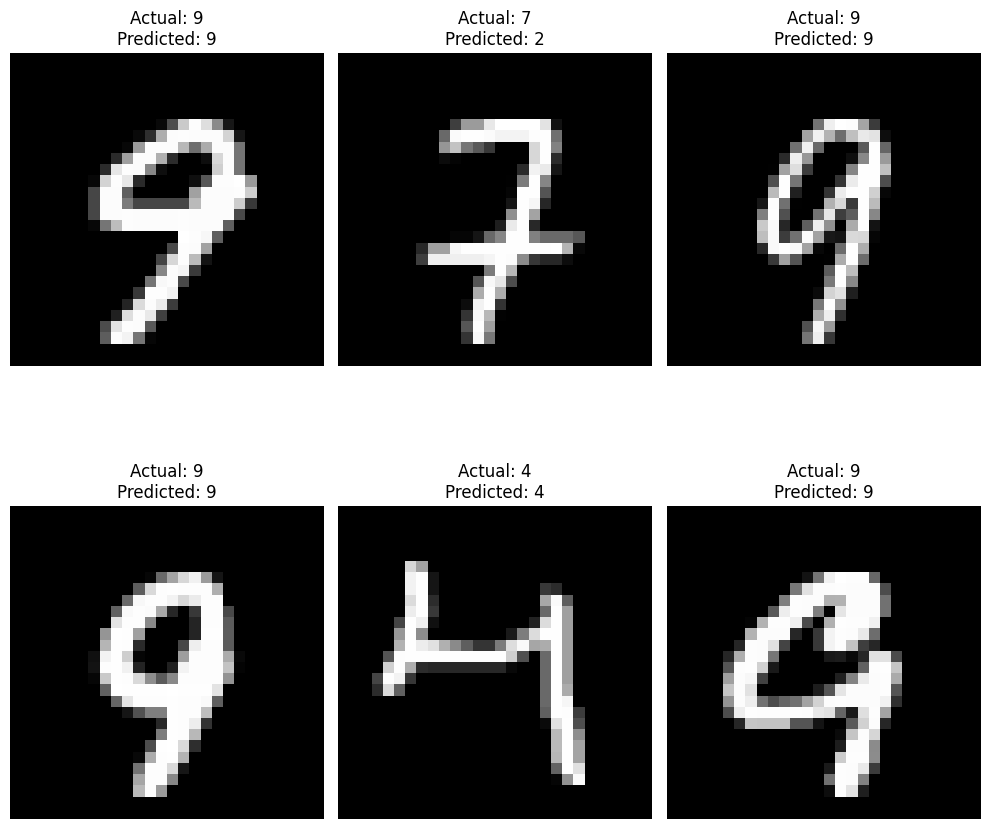

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.561057
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.452553
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.506283
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.371818
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.595743
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.401647
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.389221
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.487404
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.516677
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.569786

Test set: Average loss: 0.0007, Accuracy: 8997/10000 (90%)

Plotting top 6 confused images:


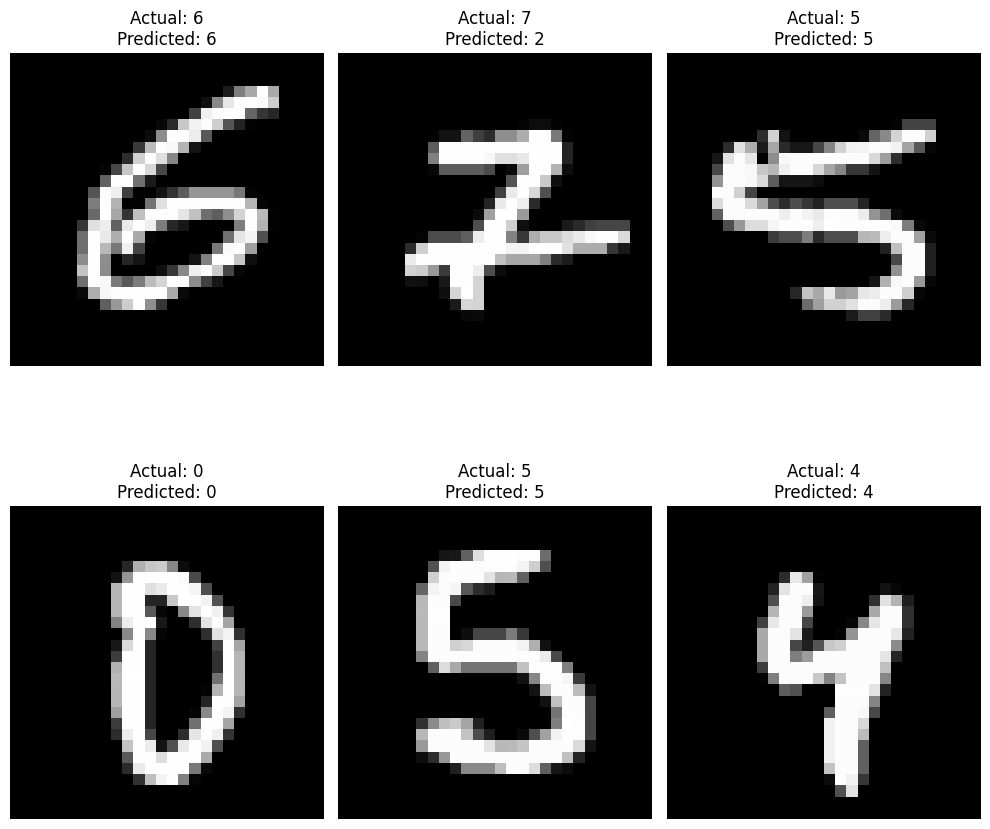

[I 2024-03-23 07:01:45,373] Trial 9 finished with value: 89.97 and parameters: {'lr': 0.00047486185577286737, 'momentum': 0.4}. Best is trial 8 with value: 98.17.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.745770
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.782124
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.311968
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.569477
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.323847
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.371590
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.206656
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.342696
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.331357

Test set: Average loss: 0.0003, Accuracy: 9579/10000 (96%)

Plotting top 6 confused images:


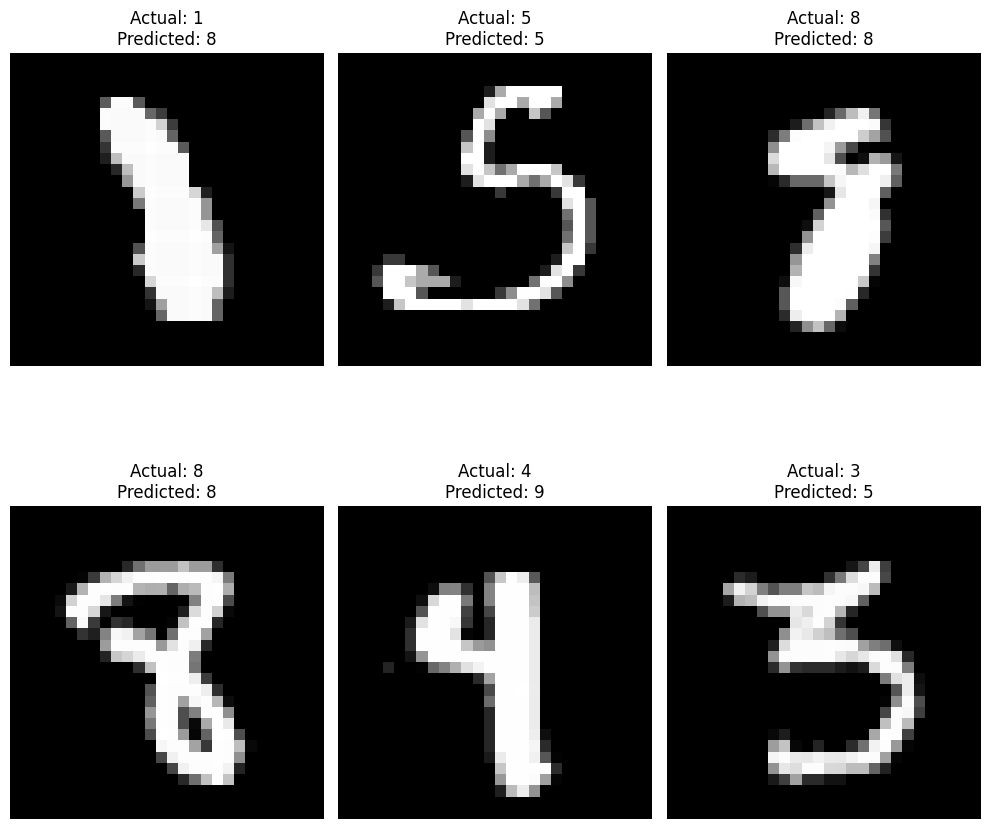

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.073727
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.118440
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.344625
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.043393
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.169782
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.141592
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.111038
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.049507
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.156416
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.131359

Test set: Average loss: 0.0002, Accuracy: 9680/10000 (97%)

Plotting top 6 confused images:


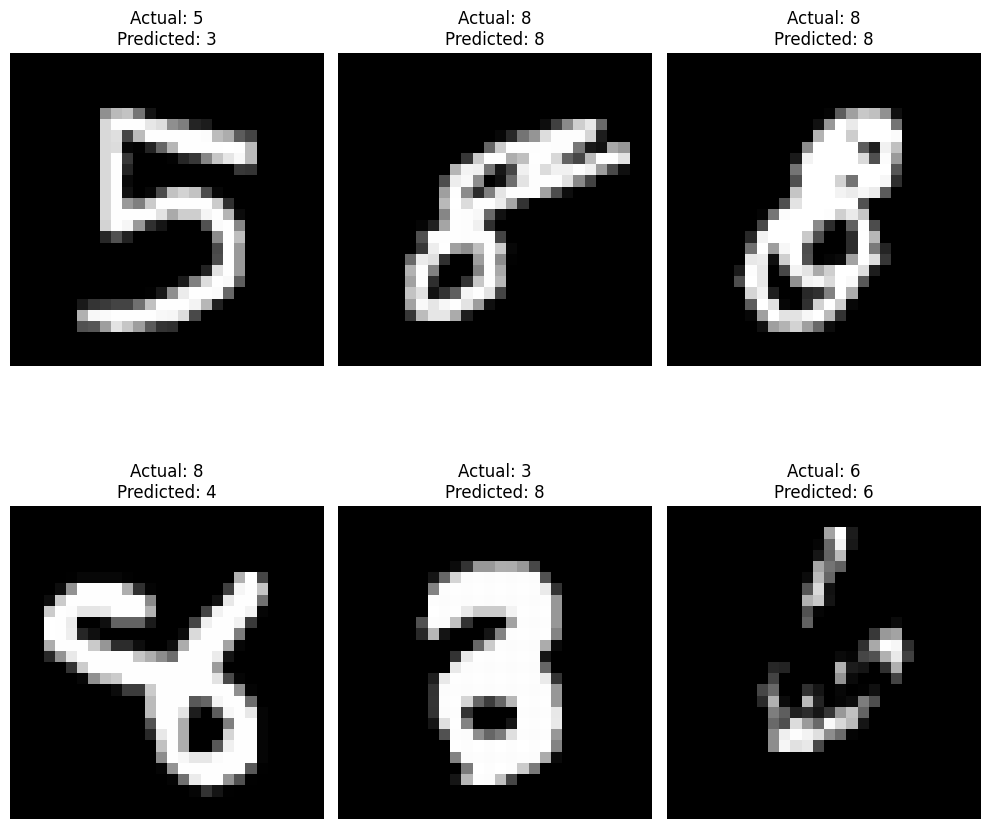

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.165807
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.018627
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.115410
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.029985
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.079253
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.164733
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.090919
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.324295
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.190609
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.071301

Test set: Average loss: 0.0001, Accuracy: 9761/10000 (98%)

Plotting top 6 confused images:


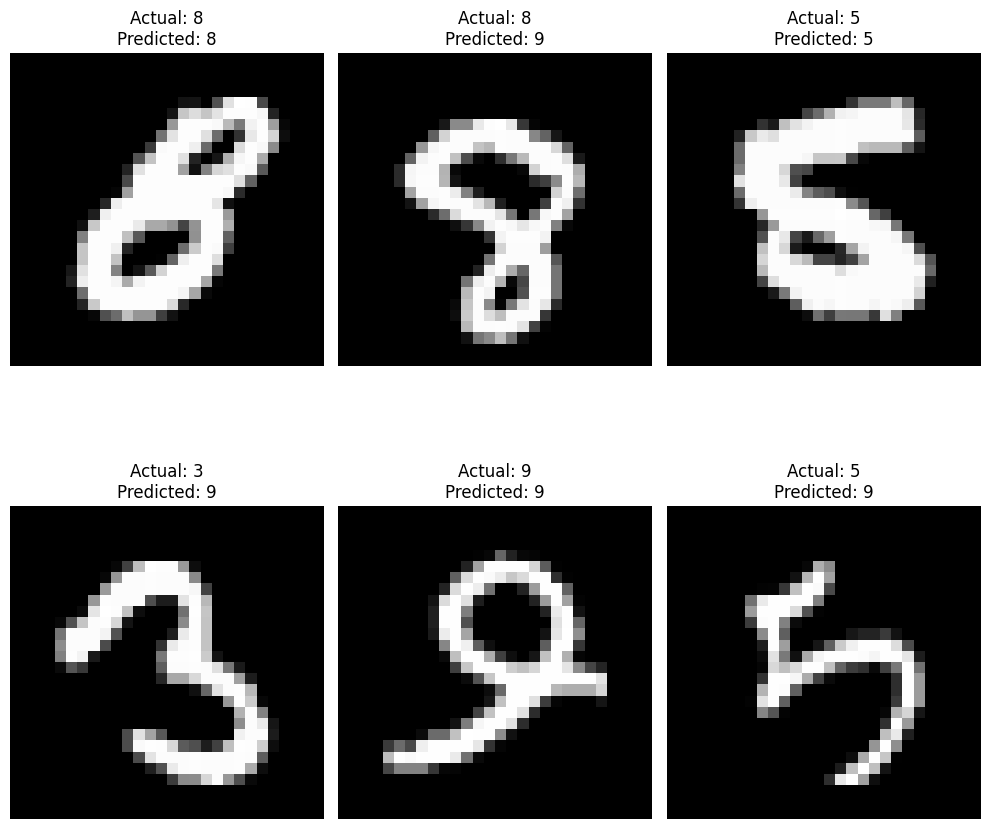

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.083255
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.145826
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.082084
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.249362
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.022604
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.121582
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.067595
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.038050
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.016948
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.130296

Test set: Average loss: 0.0001, Accuracy: 9756/10000 (98%)

Plotting top 6 confused images:


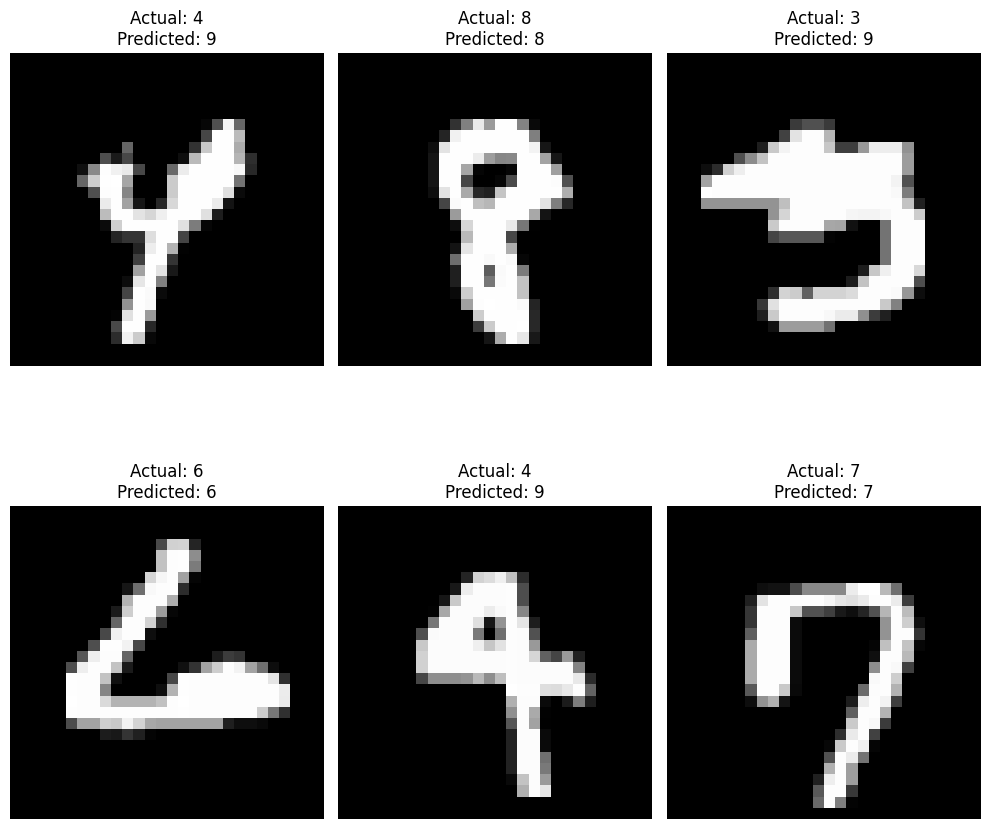

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.179244
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.028878
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.103777
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.067812
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.189813
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.056941
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.029163
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.086604
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.032110
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.328687

Test set: Average loss: 0.0001, Accuracy: 9854/10000 (99%)

Plotting top 6 confused images:


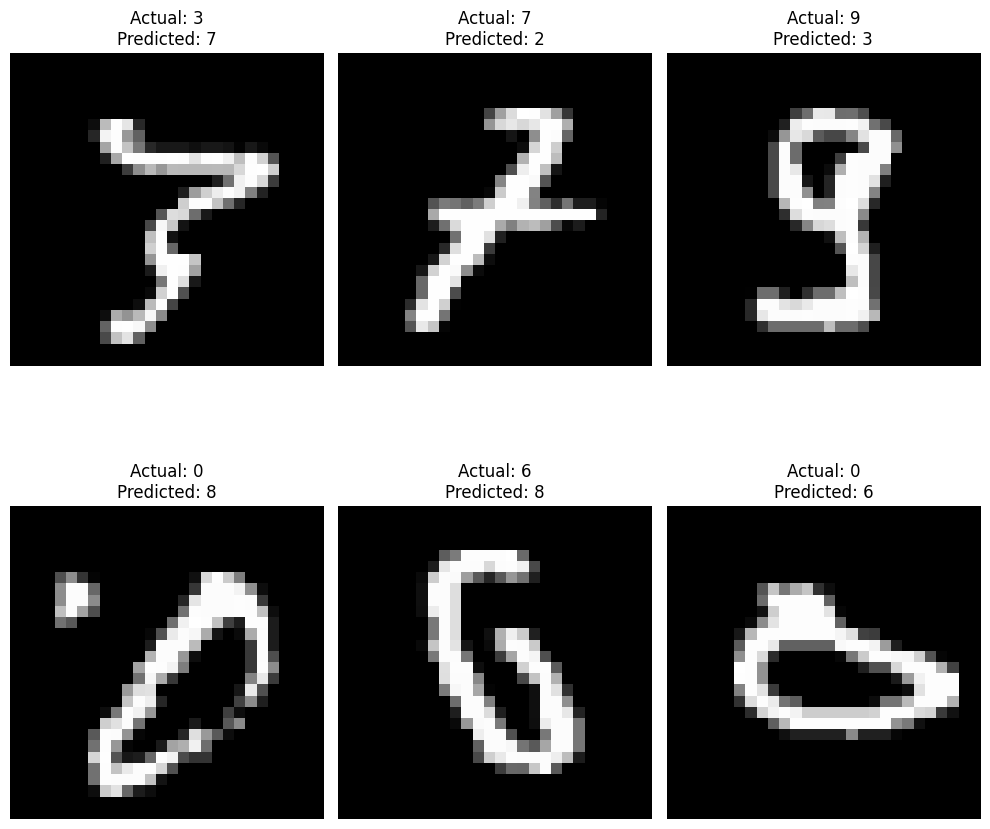

[I 2024-03-23 07:02:53,108] Trial 10 finished with value: 98.54 and parameters: {'lr': 0.008136939440081311, 'momentum': 0.6000000000000001}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.779593
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.796375
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.317153
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.561813
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.324490
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.385948
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.213055
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.343465
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.332305

Test set: Average loss: 0.0003, Accuracy: 9568/10000 (96%)

Plotting top 6 confused images:


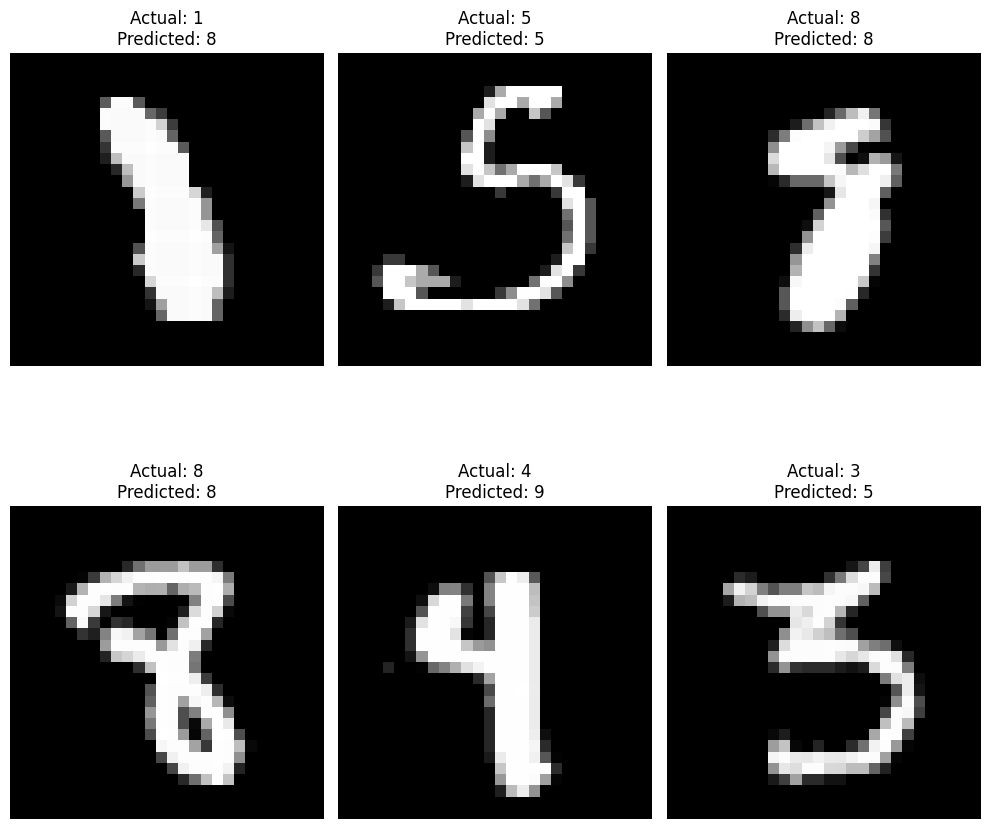

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.075205
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.123491
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.335140
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.043957
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.174112
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.145896
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.113123
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.050958
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.164388
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.128492

Test set: Average loss: 0.0002, Accuracy: 9683/10000 (97%)

Plotting top 6 confused images:


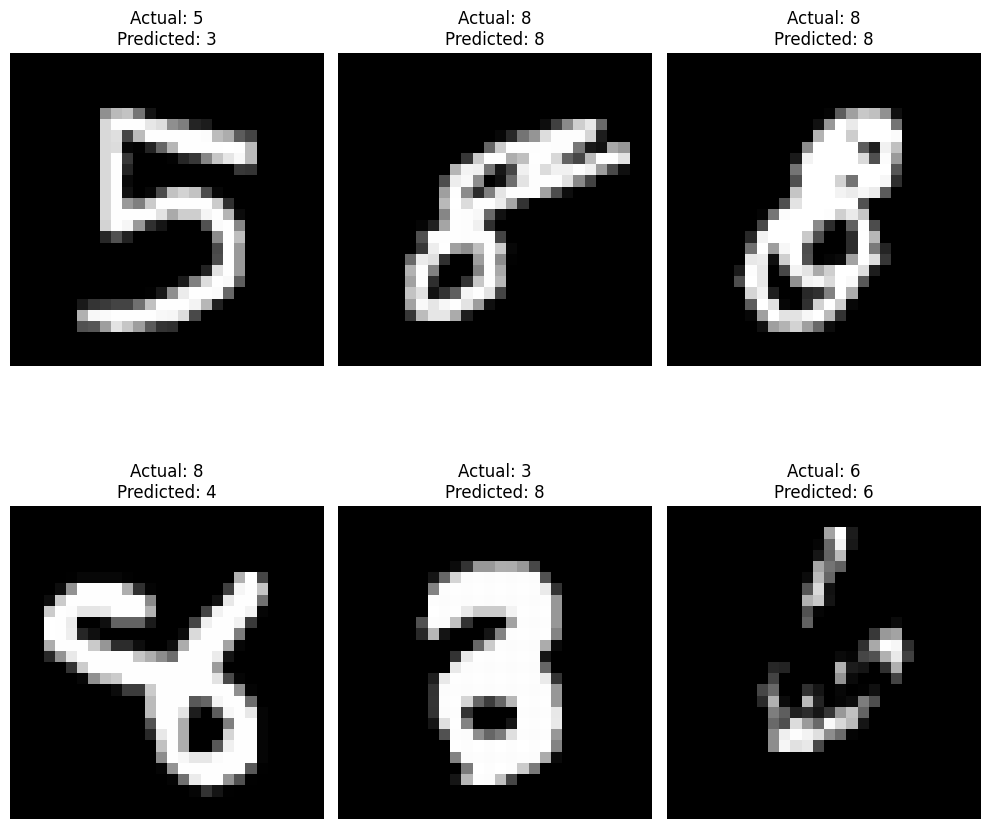

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.175658
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.018142
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.114232
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.033244
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.078862
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.166565
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.088376
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.321323
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.184704
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.077904

Test set: Average loss: 0.0001, Accuracy: 9751/10000 (98%)

Plotting top 6 confused images:


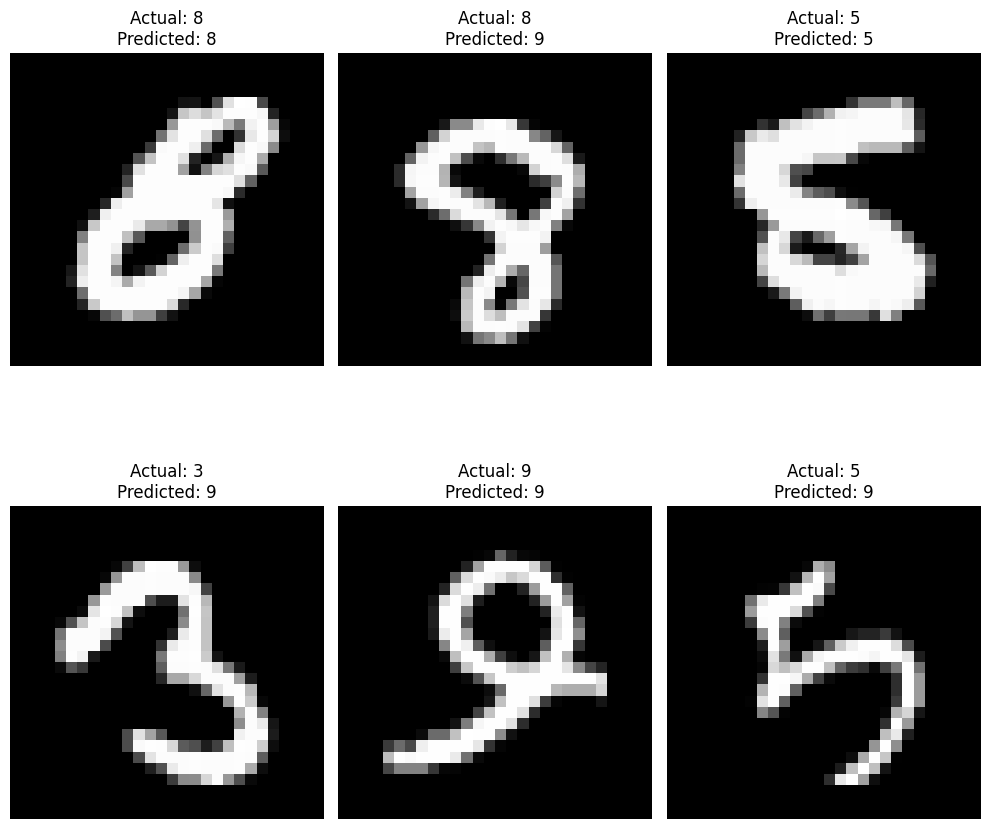

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.089824
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.156003
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.078599
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.253346
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.022116
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.126622
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.076827
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.037854
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.017941
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.133425

Test set: Average loss: 0.0001, Accuracy: 9757/10000 (98%)

Plotting top 6 confused images:


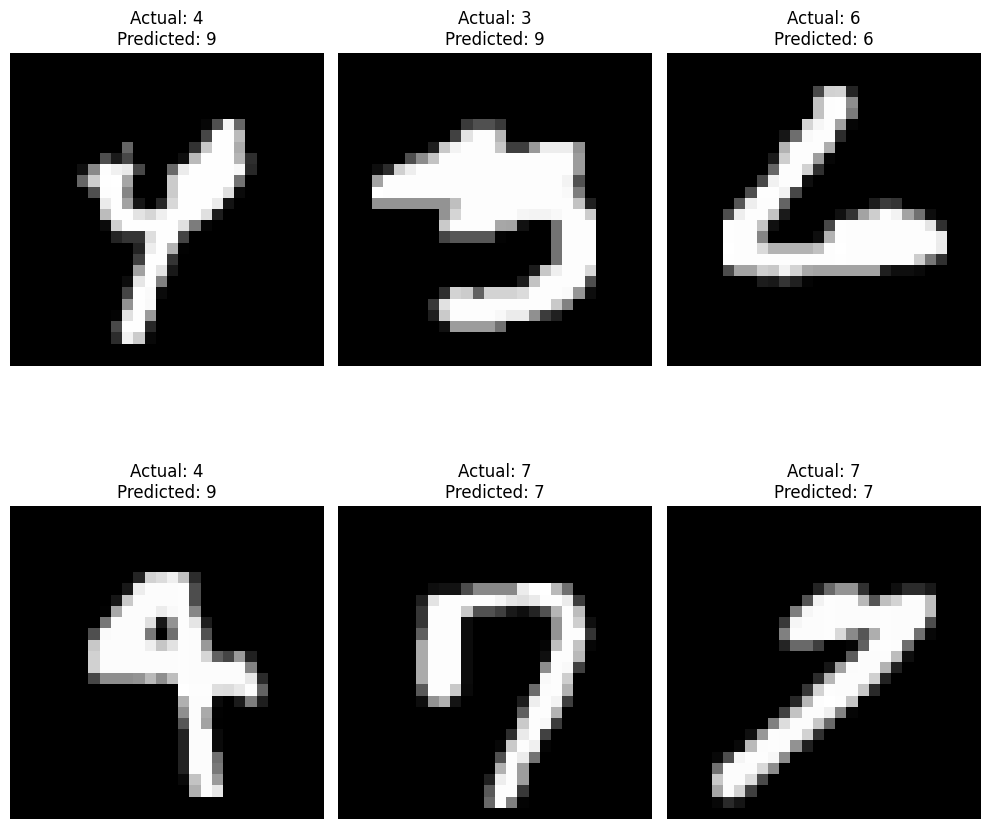

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.164914
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.026983
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.104816
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.062834
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.199170
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.053953
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.033548
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.098519
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.030116
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.322107

Test set: Average loss: 0.0001, Accuracy: 9849/10000 (98%)

Plotting top 6 confused images:


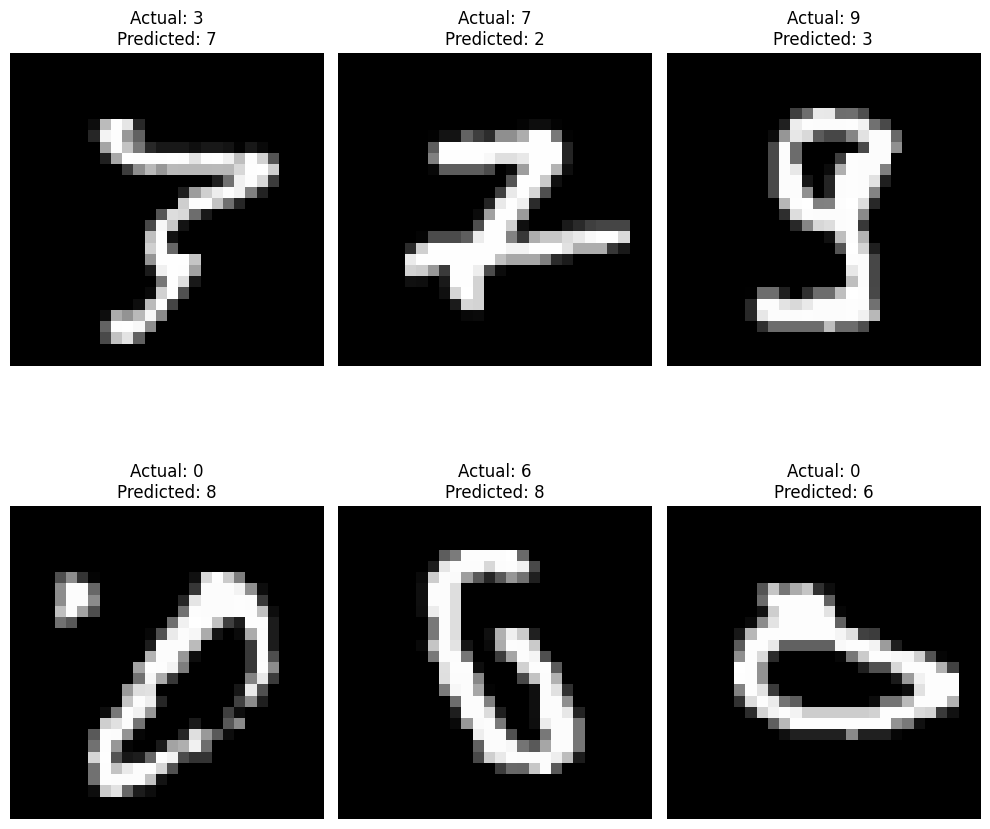

[I 2024-03-23 07:04:00,363] Trial 11 finished with value: 98.49 and parameters: {'lr': 0.007891616475618523, 'momentum': 0.6000000000000001}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.664660
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.752512
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.308264
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.529953
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.298470
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.349610
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.190658
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.322935
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.298506

Test set: Average loss: 0.0002, Accuracy: 9612/10000 (96%)

Plotting top 6 confused images:


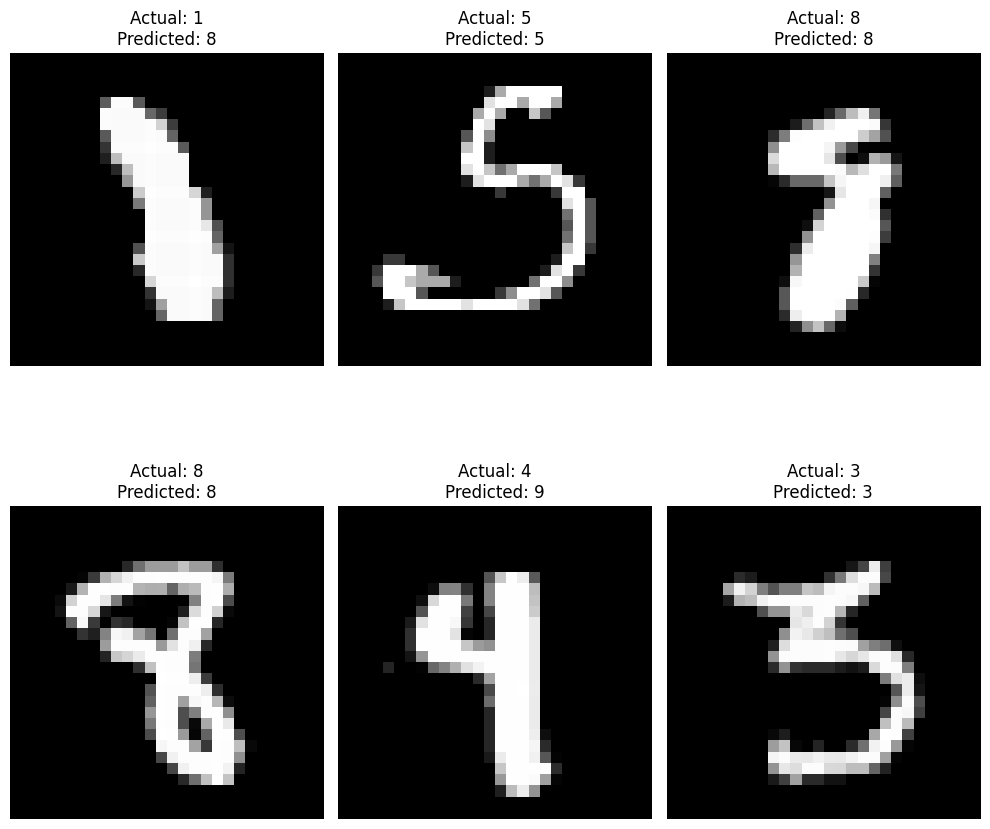

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.065599
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.105077
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.322907
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.038491
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.156007
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.128661
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.104015
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.039492
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.140300
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.130993

Test set: Average loss: 0.0002, Accuracy: 9706/10000 (97%)

Plotting top 6 confused images:


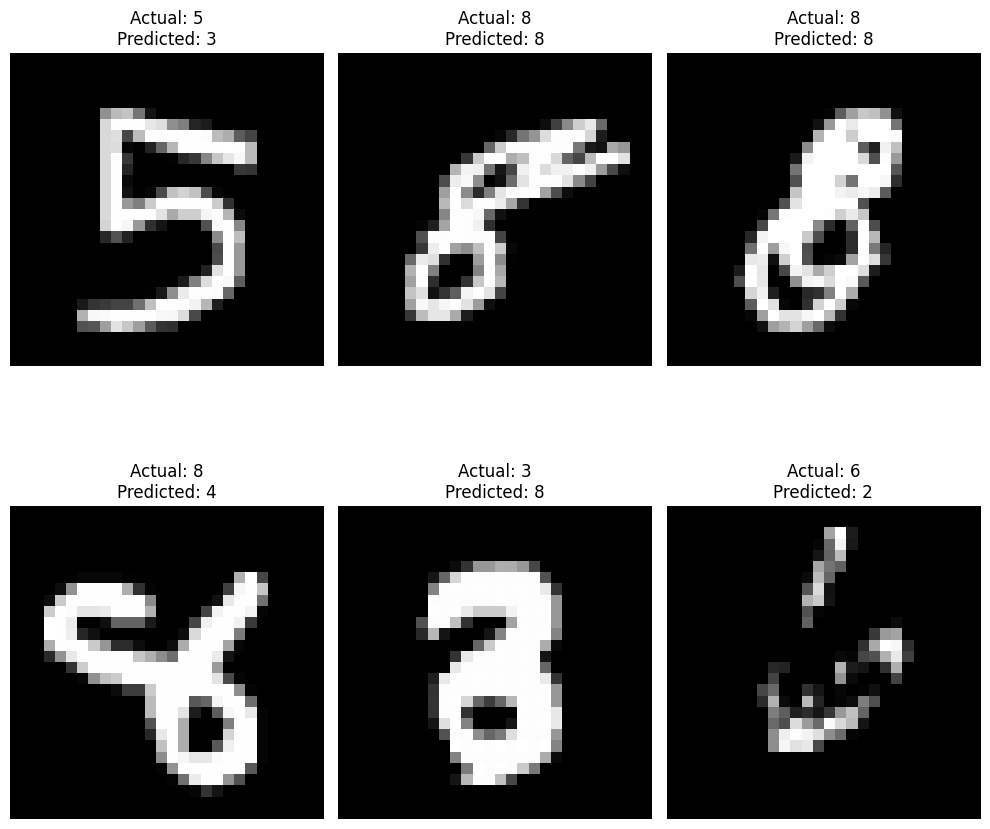

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.153234
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.015468
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.109057
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.028502
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.070082
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.162757
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.079176
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.323042
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.169306
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.061297

Test set: Average loss: 0.0001, Accuracy: 9770/10000 (98%)

Plotting top 6 confused images:


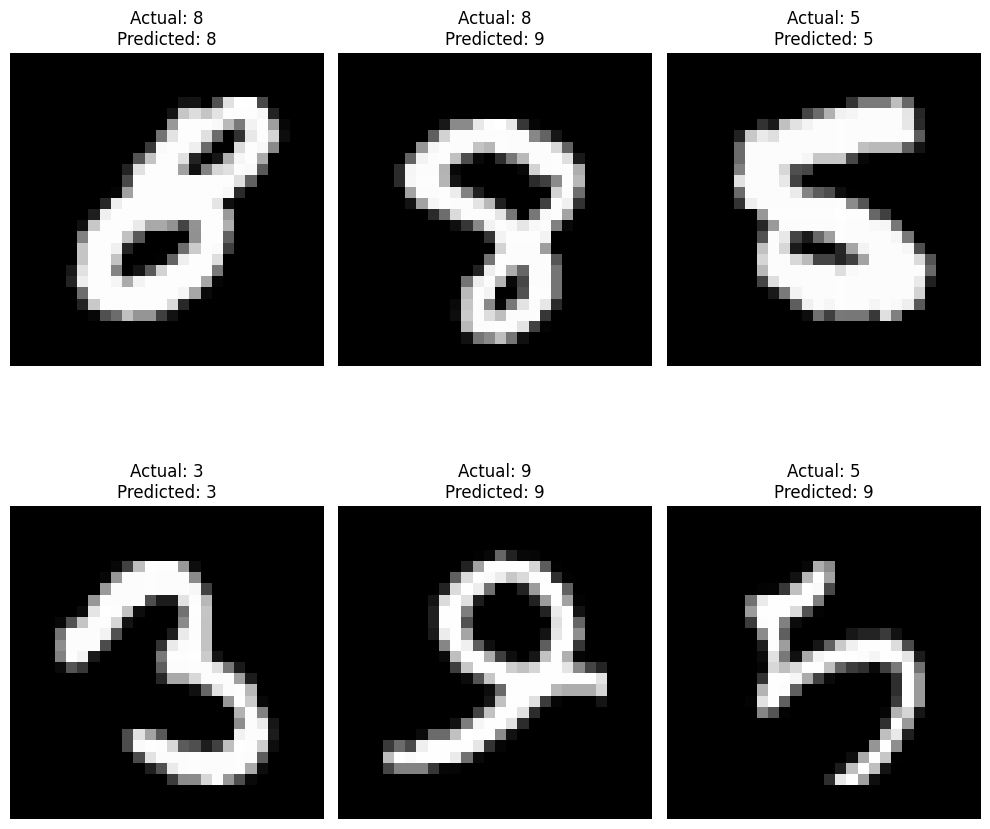

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.079821
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.137366
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.077057
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.235160
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.022635
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.123017
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.067844
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.041992
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.011484
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.121937

Test set: Average loss: 0.0001, Accuracy: 9771/10000 (98%)

Plotting top 6 confused images:


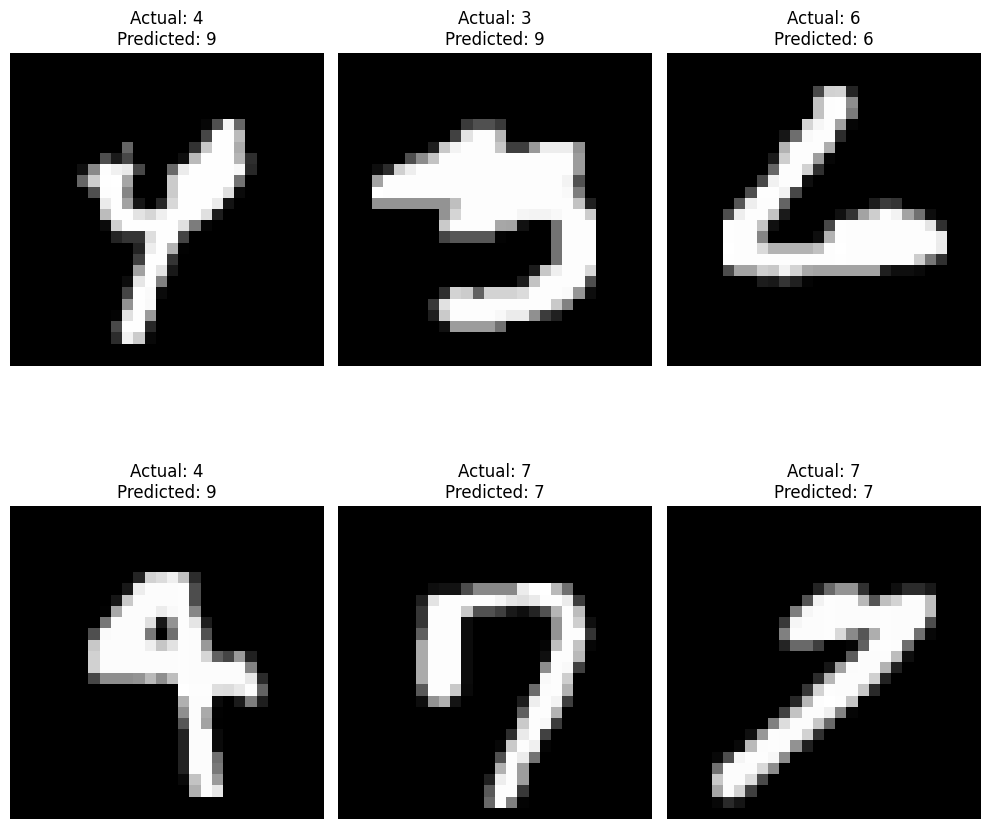

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.152812
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.034866
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.090068
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.057562
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.170501
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.053762
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.032173
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.089976
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.038740
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.306860

Test set: Average loss: 0.0001, Accuracy: 9851/10000 (99%)

Plotting top 6 confused images:


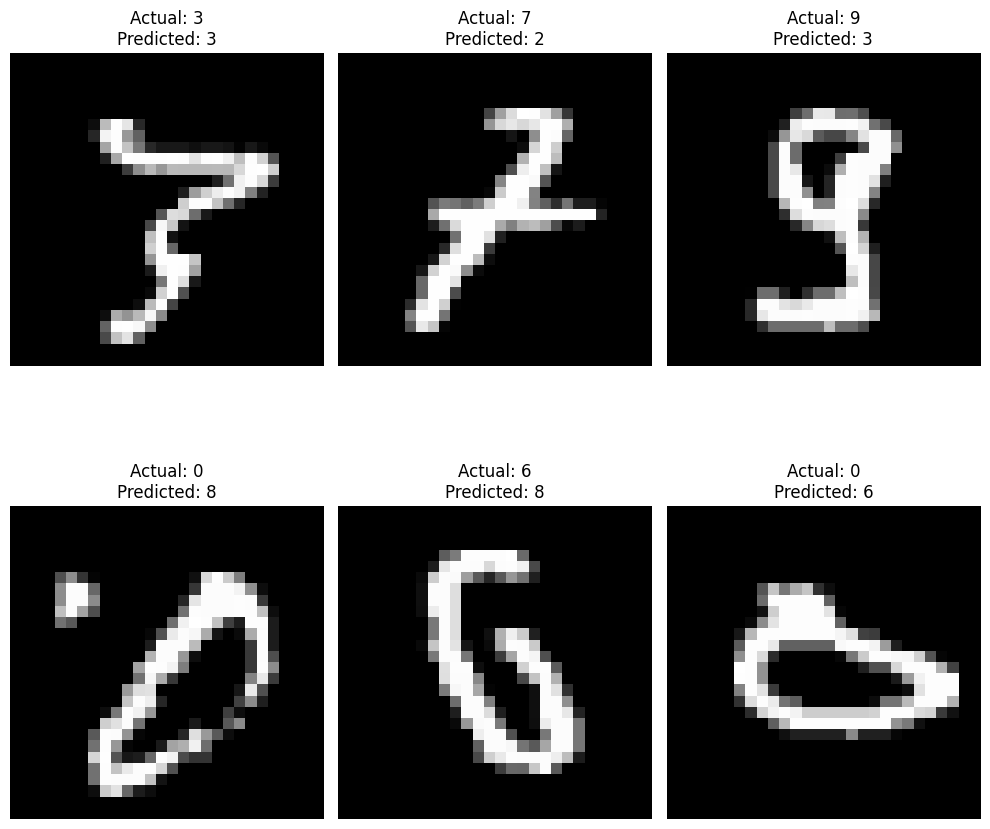

[I 2024-03-23 07:05:07,829] Trial 12 finished with value: 98.50999999999999 and parameters: {'lr': 0.00916932778828621, 'momentum': 0.6000000000000001}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.154829
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.693132
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.744342
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.790430
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.547952
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.610836
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.443363
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.402098
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.579487

Test set: Average loss: 0.0006, Accuracy: 9159/10000 (92%)

Plotting top 6 confused images:


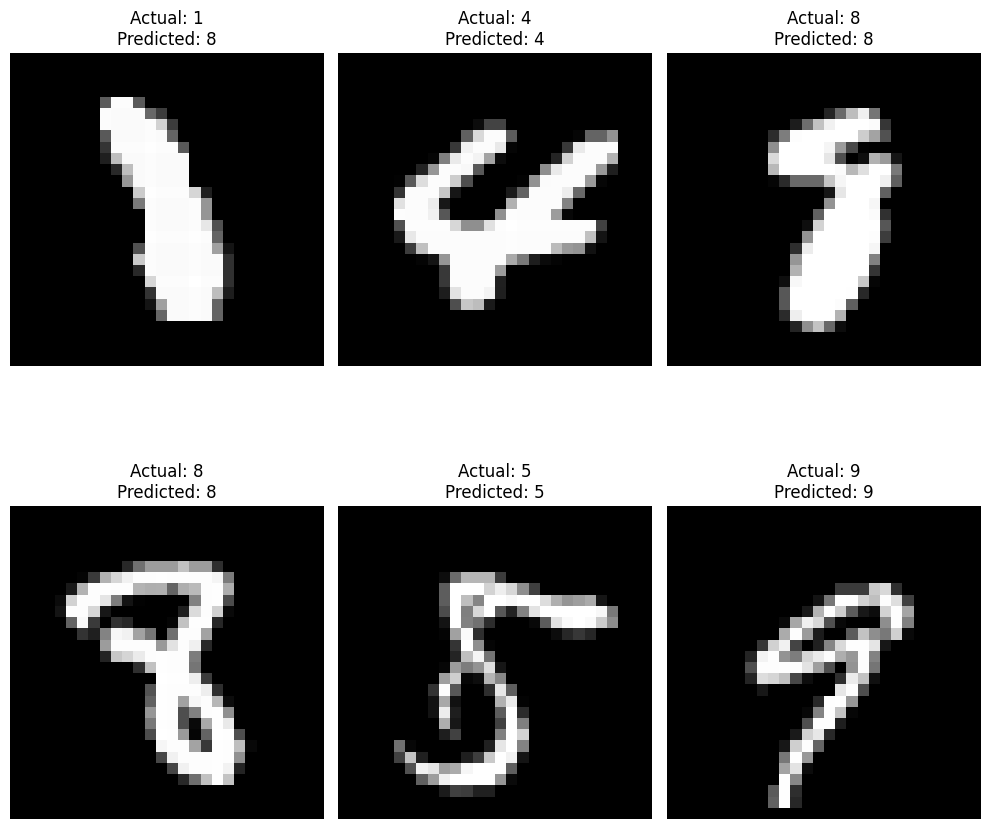

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.219856
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.304895
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.575108
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.168324
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.280561
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.285426
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.179397
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.127411
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.265530
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.149674

Test set: Average loss: 0.0004, Accuracy: 9315/10000 (93%)

Plotting top 6 confused images:


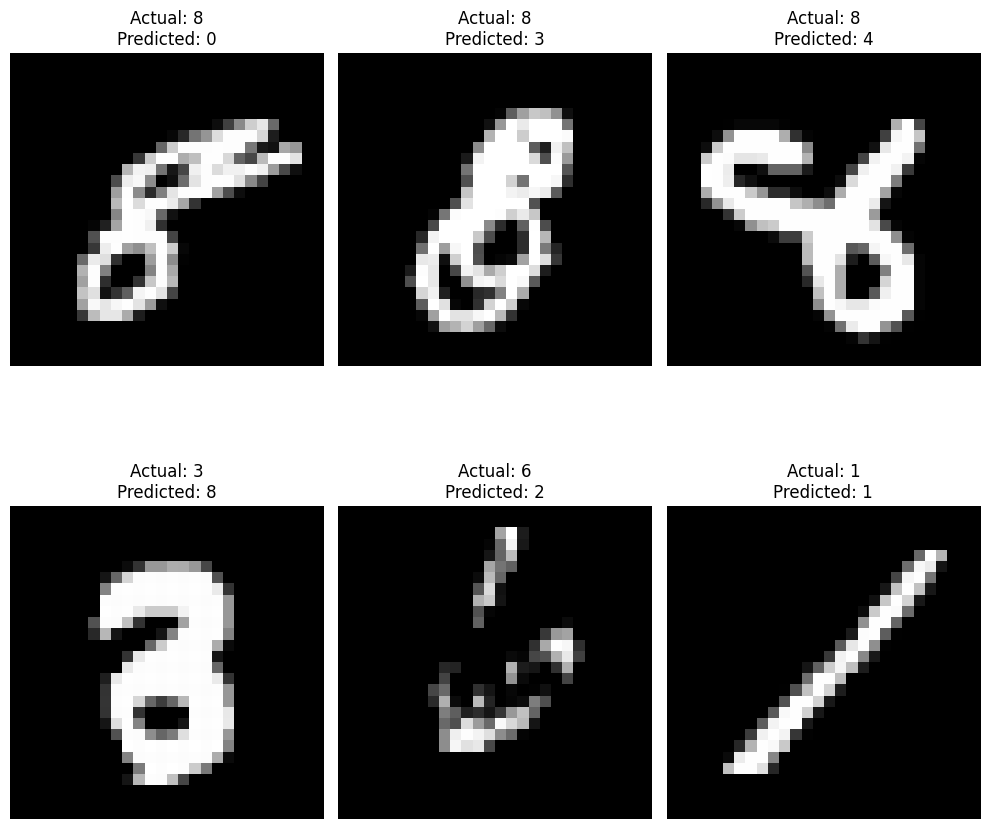

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.340199
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.152189
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.163207
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.087971
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.127755
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.192781
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.212936
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.471169
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.327707
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.290540

Test set: Average loss: 0.0003, Accuracy: 9572/10000 (96%)

Plotting top 6 confused images:


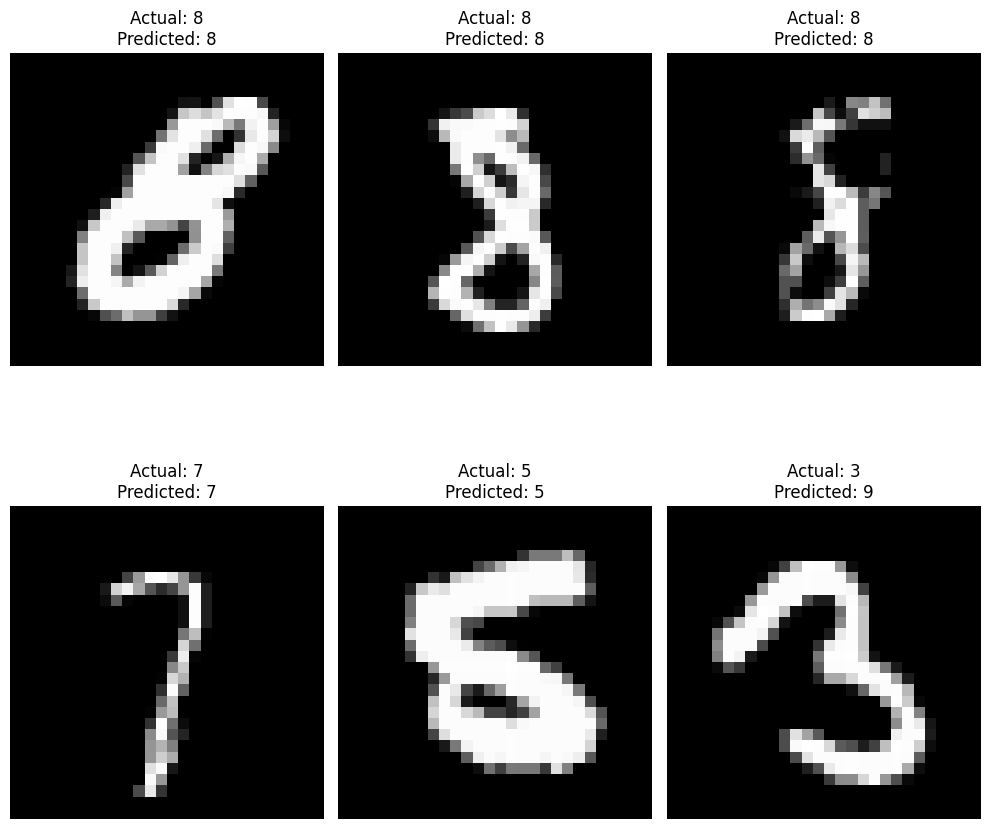

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.150626
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.180889
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.202948
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.297245
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.078826
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.156075
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.116934
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.064311
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.093398
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.165902

Test set: Average loss: 0.0002, Accuracy: 9617/10000 (96%)

Plotting top 6 confused images:


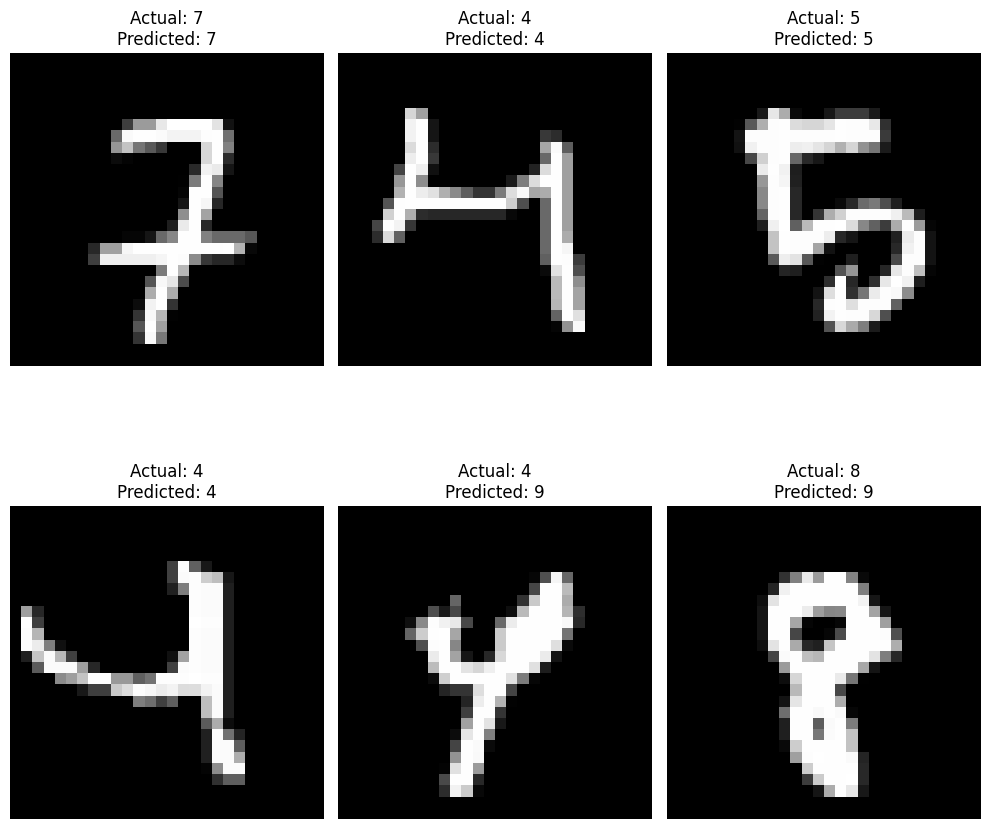

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.219505
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.098661
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.192027
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.138114
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.236250
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.144933
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.090517
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.131490
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.126790
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.377655

Test set: Average loss: 0.0002, Accuracy: 9739/10000 (97%)

Plotting top 6 confused images:


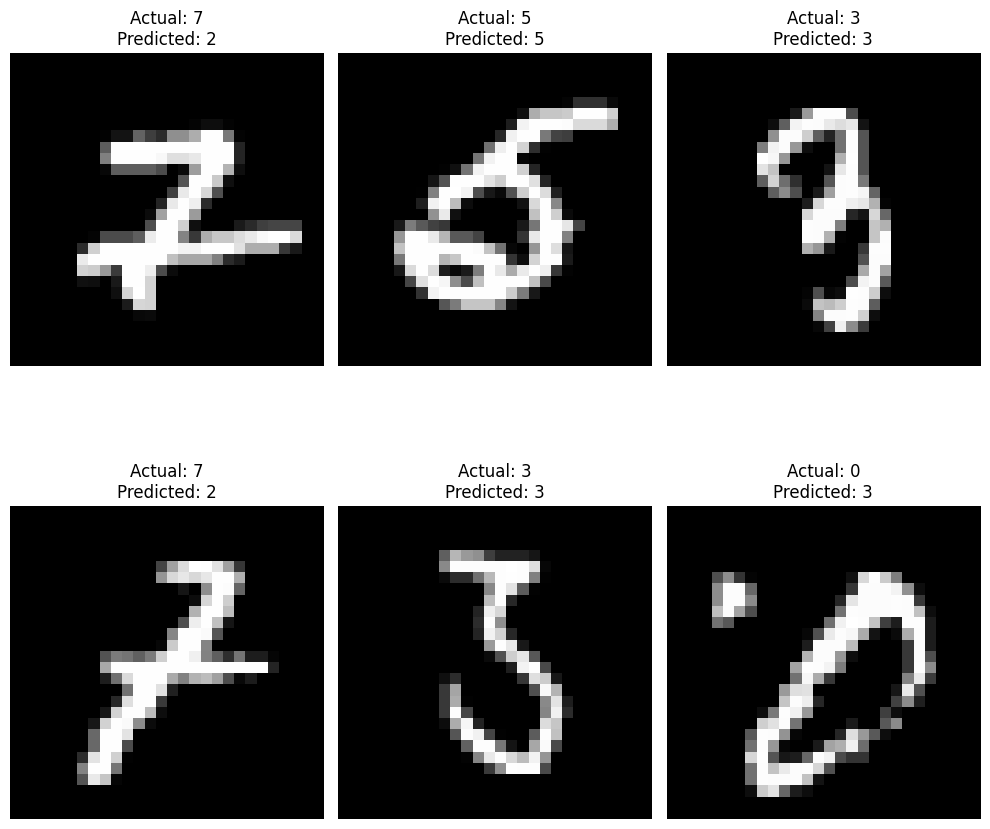

[I 2024-03-23 07:06:16,078] Trial 13 finished with value: 97.39 and parameters: {'lr': 0.002684193483323082, 'momentum': 0.6000000000000001}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.101654
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.337318
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.546589
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.746011
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.496697
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.573133
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.404893
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.378665
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.535461

Test set: Average loss: 0.0005, Accuracy: 9247/10000 (92%)

Plotting top 6 confused images:


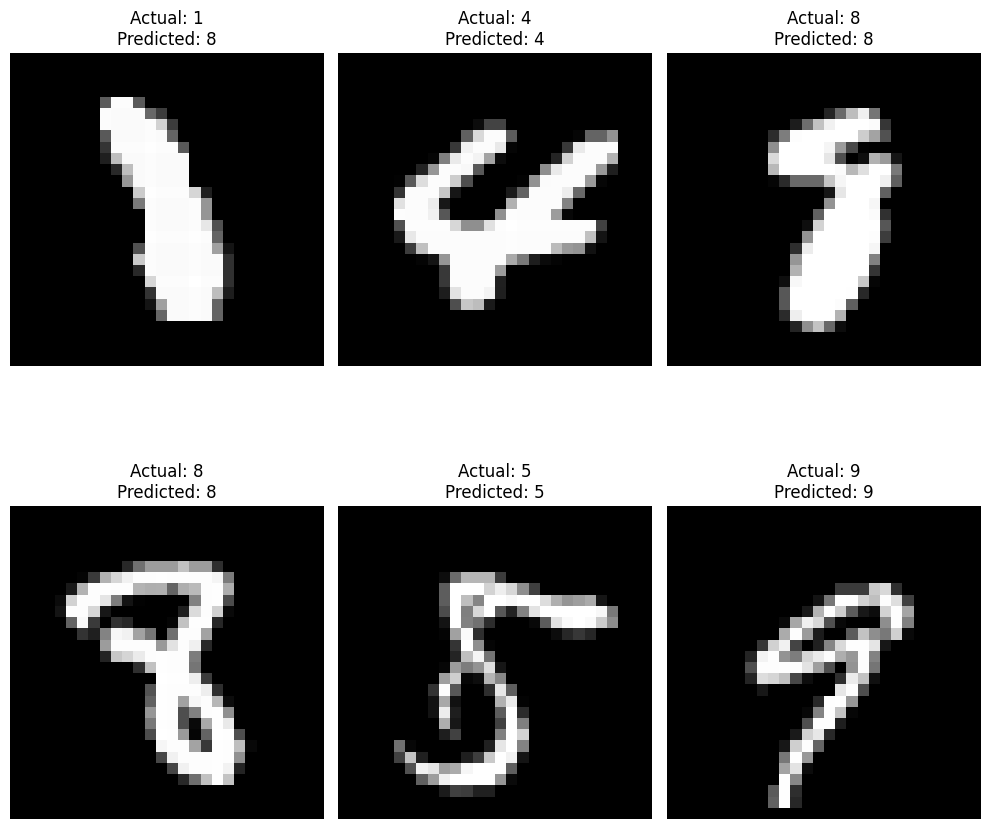

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.198466
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.258713
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.531301
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.138976
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.258016
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.249357
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.159287
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.097965
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.231800
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.140727

Test set: Average loss: 0.0004, Accuracy: 9383/10000 (94%)

Plotting top 6 confused images:


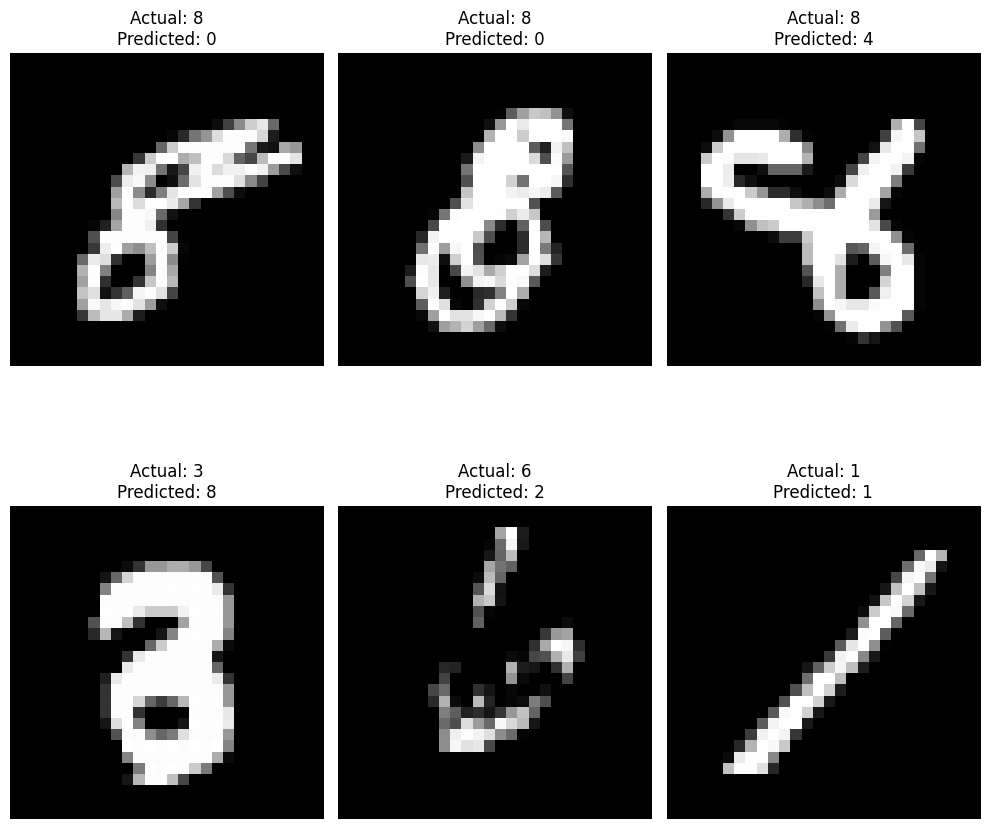

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.302883
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.118976
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.142915
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.069070
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.107129
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.180550
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.178082
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.409094
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.305415
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.244521

Test set: Average loss: 0.0002, Accuracy: 9600/10000 (96%)

Plotting top 6 confused images:


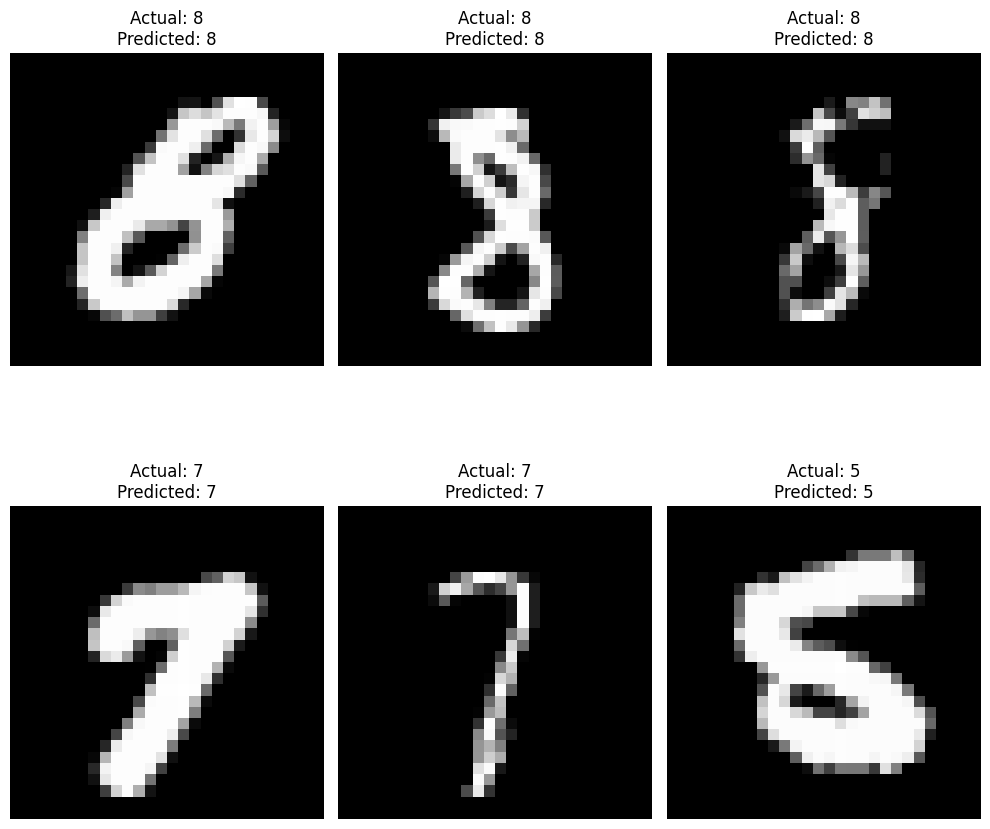

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.140518
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.159601
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.168049
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.287180
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.056172
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.131164
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.098647
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.054312
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.072916
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.157522

Test set: Average loss: 0.0002, Accuracy: 9656/10000 (97%)

Plotting top 6 confused images:


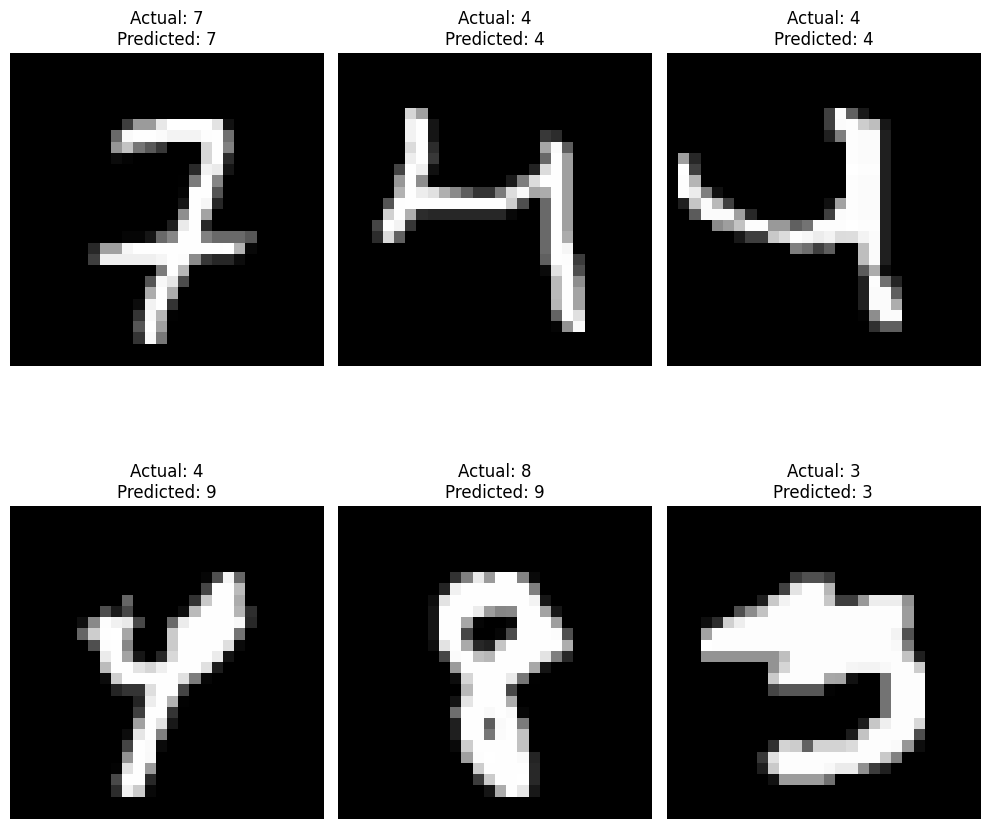

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.214939
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.076113
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.170638
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.120602
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.211087
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.124548
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.079515
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.118203
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.108791
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.342398

Test set: Average loss: 0.0001, Accuracy: 9773/10000 (98%)

Plotting top 6 confused images:


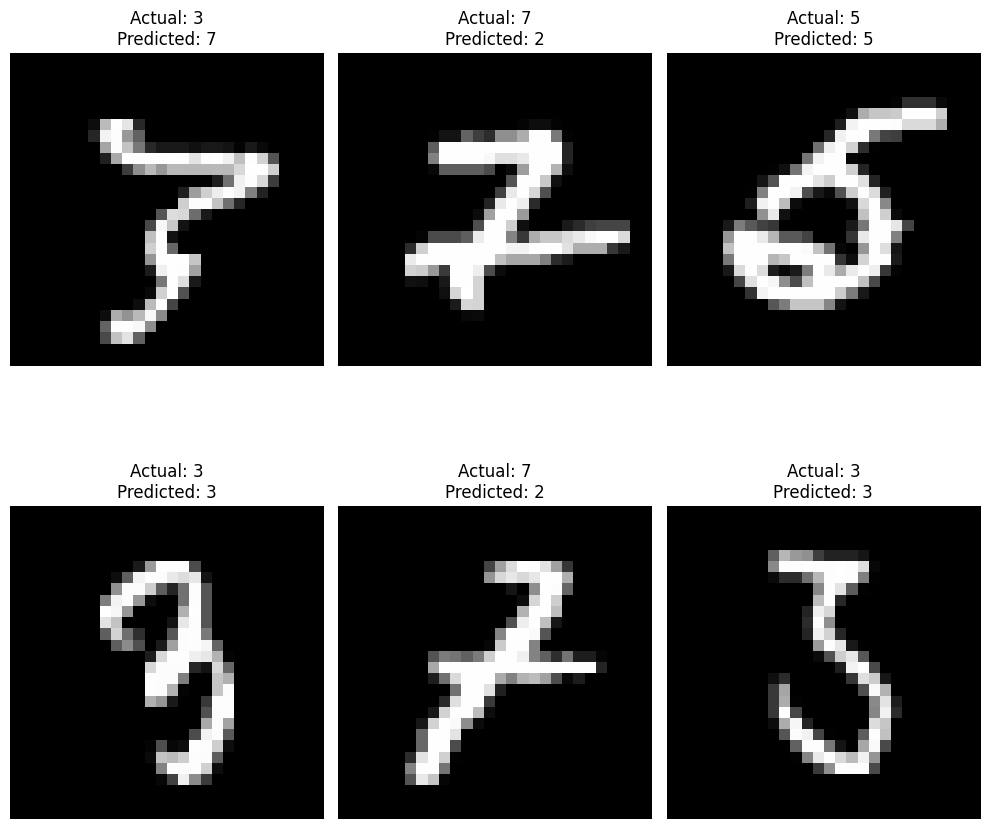

[I 2024-03-23 07:07:23,133] Trial 14 finished with value: 97.72999999999999 and parameters: {'lr': 0.002457025202065009, 'momentum': 0.7000000000000001}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.840267
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.880081
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.342278
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.611494
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.339114
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.372039
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.220232
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.347052
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.338809

Test set: Average loss: 0.0003, Accuracy: 9552/10000 (96%)

Plotting top 6 confused images:


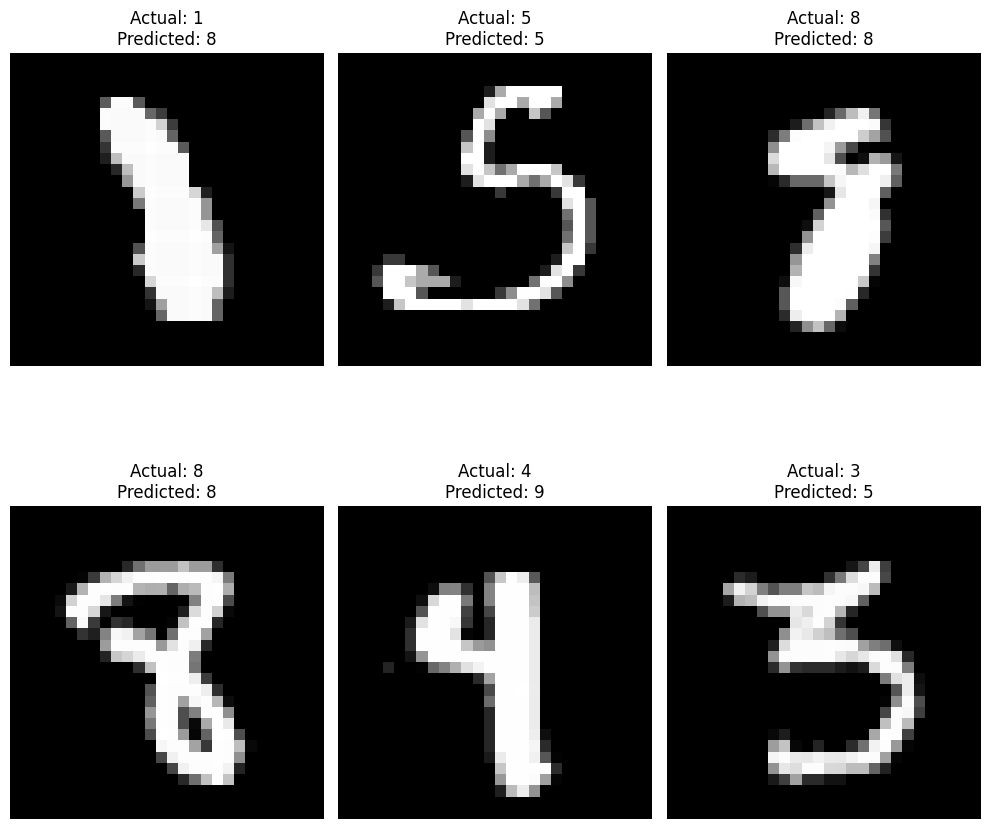

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.089124
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.128675
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.348347
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.043138
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.175531
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.150702
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.108568
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.053159
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.164564
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.153205

Test set: Average loss: 0.0002, Accuracy: 9674/10000 (97%)

Plotting top 6 confused images:


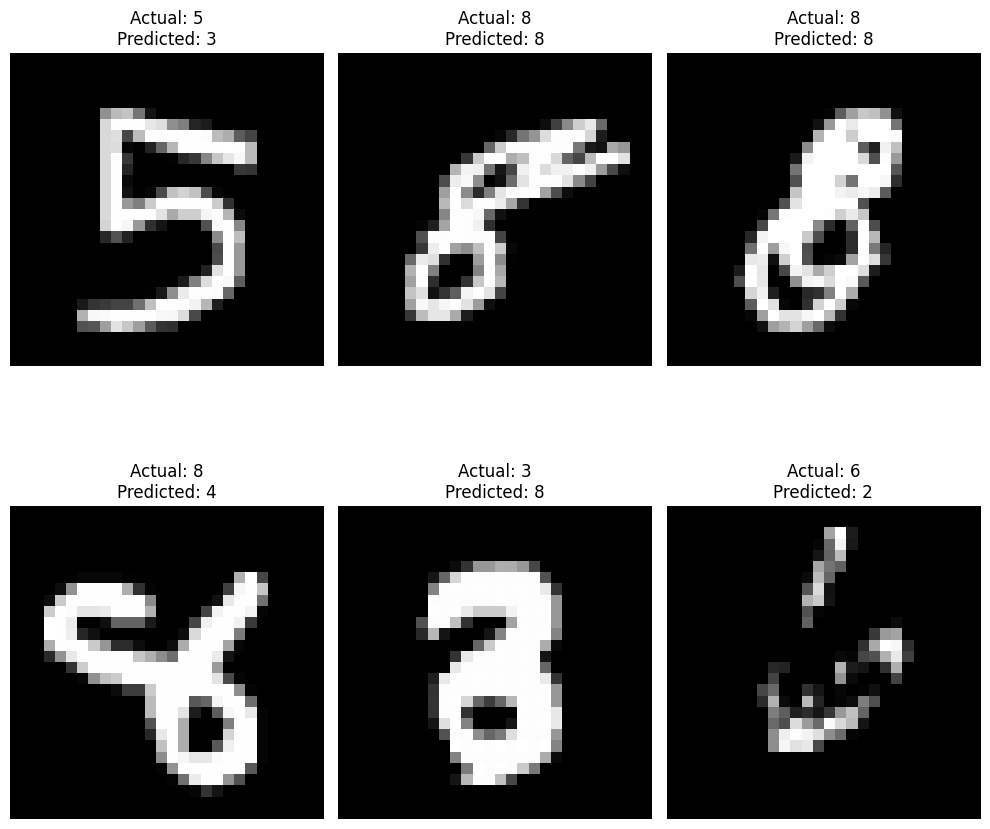

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.168805
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.022462
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.111226
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.035845
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.081029
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.161726
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.103562
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.327435
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.185985
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.081963

Test set: Average loss: 0.0001, Accuracy: 9762/10000 (98%)

Plotting top 6 confused images:


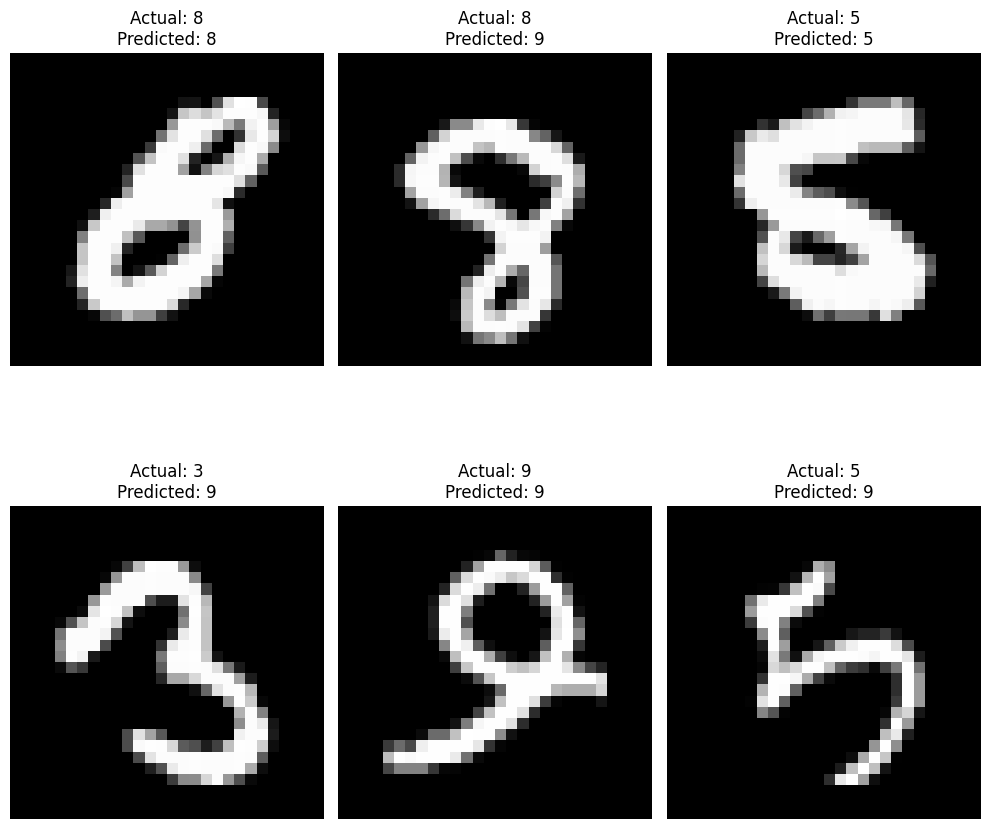

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.083335
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.154319
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.089680
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.247713
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.023459
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.122130
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.072620
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.037281
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.022285
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.127253

Test set: Average loss: 0.0001, Accuracy: 9762/10000 (98%)

Plotting top 6 confused images:


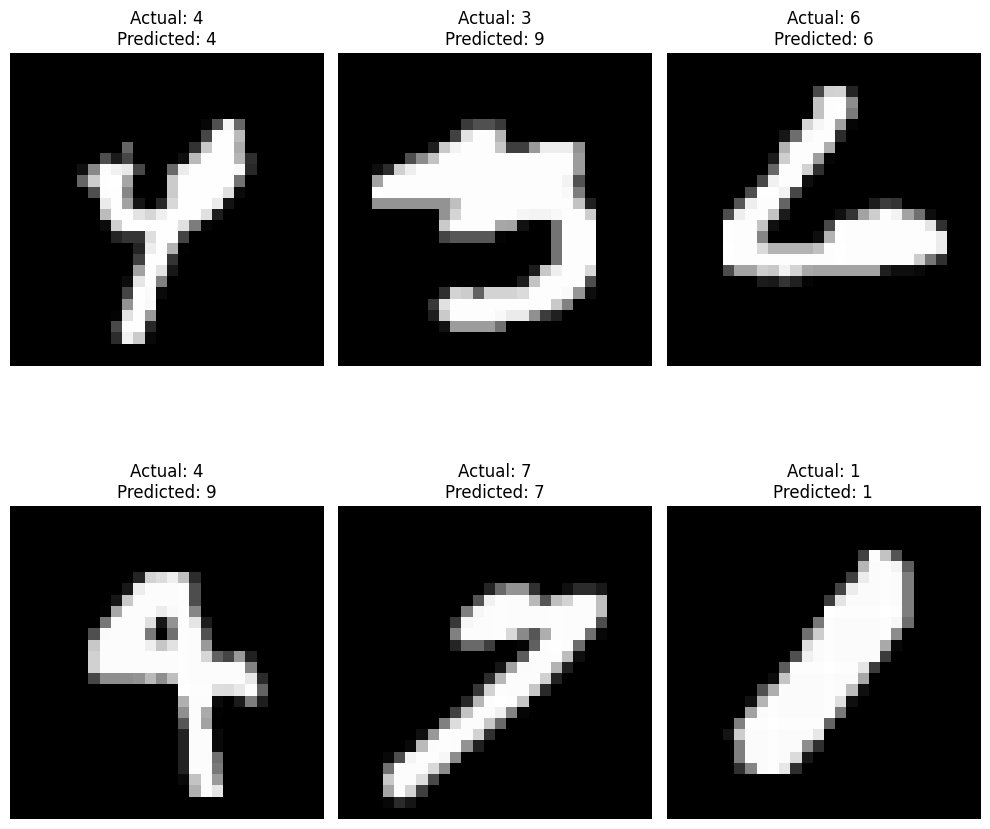

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.129350
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.027090
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.110534
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.070388
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.194089
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.062256
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.031070
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.093381
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.038109
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.307548

Test set: Average loss: 0.0001, Accuracy: 9844/10000 (98%)

Plotting top 6 confused images:


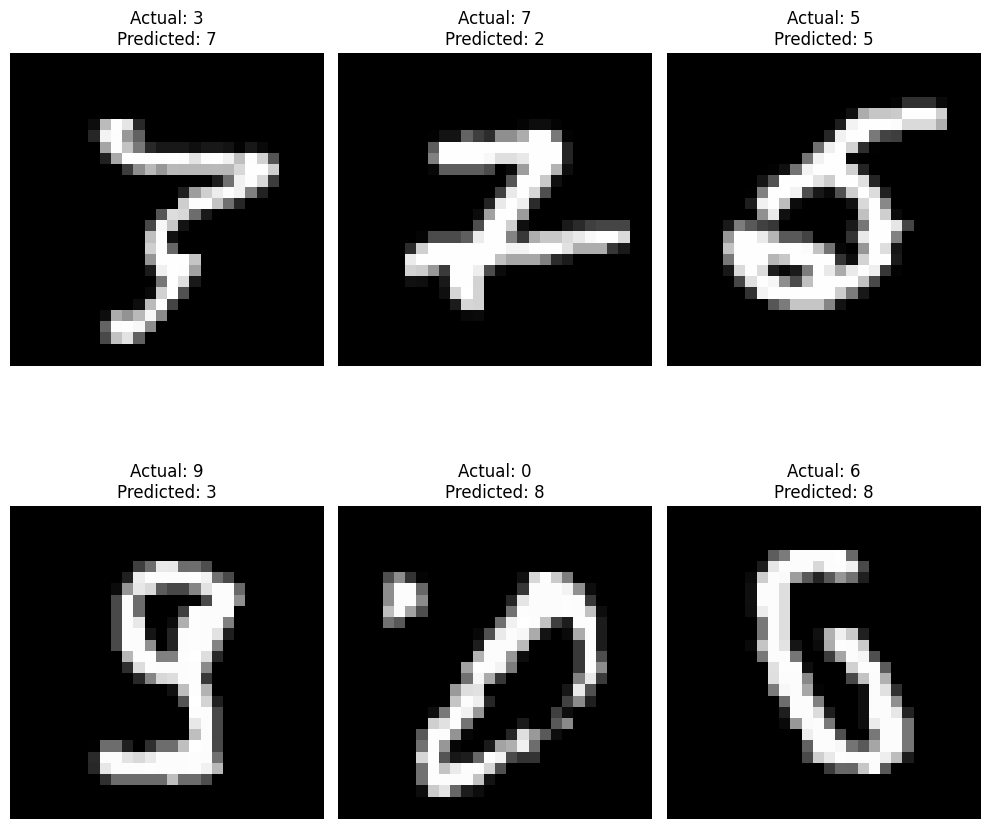

[I 2024-03-23 07:08:29,973] Trial 15 finished with value: 98.44000000000001 and parameters: {'lr': 0.009330685803234928, 'momentum': 0.5}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.136389
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.555269
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.653967
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.773022
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.529731
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.593152
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.425912
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.396326
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.561428

Test set: Average loss: 0.0006, Accuracy: 9181/10000 (92%)

Plotting top 6 confused images:


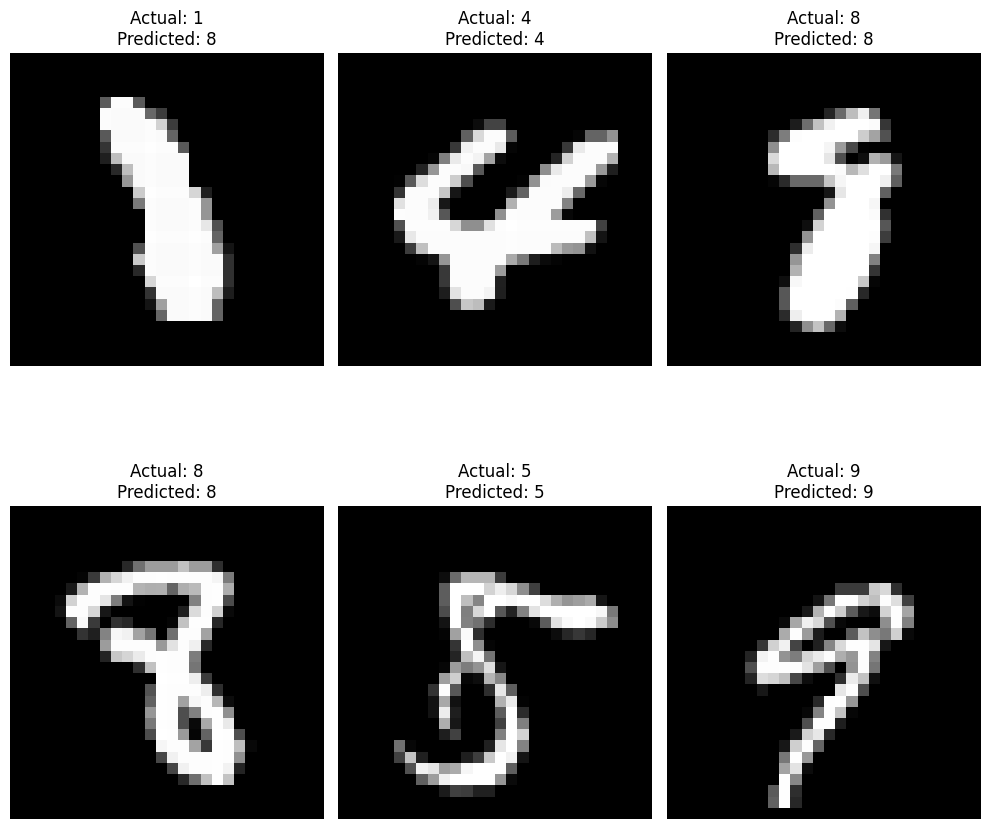

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.209867
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.292180
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.558063
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.156982
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.265763
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.274341
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.171642
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.111985
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.249884
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.147978

Test set: Average loss: 0.0004, Accuracy: 9327/10000 (93%)

Plotting top 6 confused images:


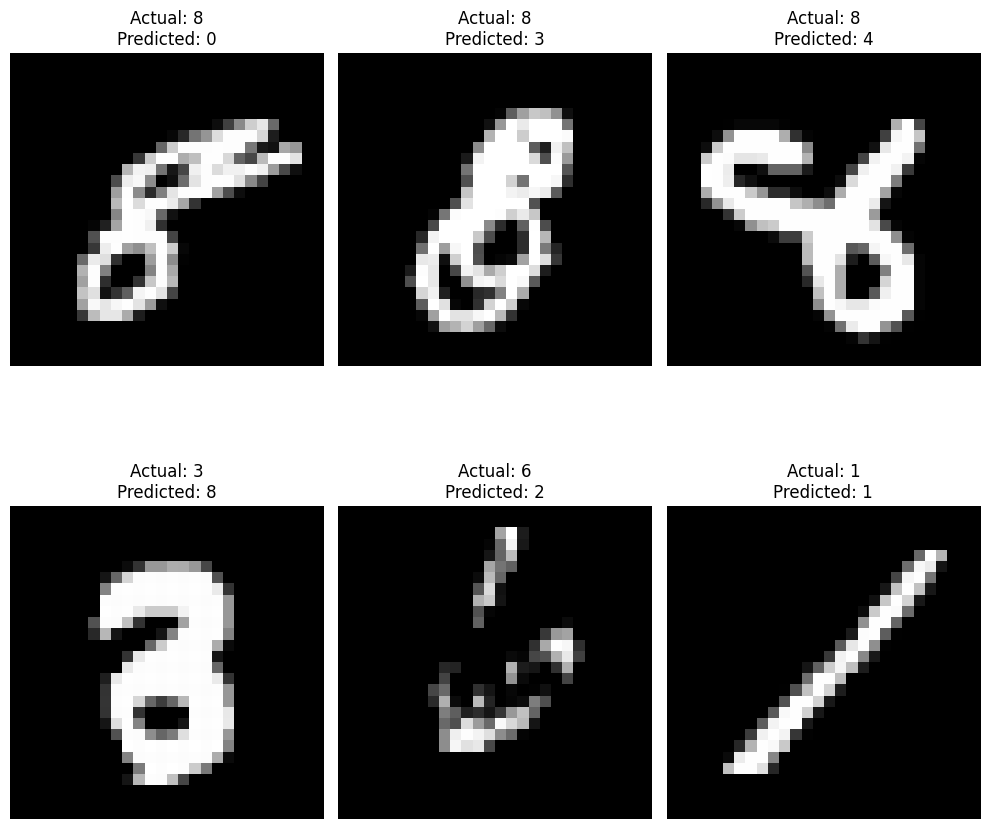

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.329402
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.136967
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.155601
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.080607
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.118133
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.185672
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.200538
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.448813
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.317766
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.277700

Test set: Average loss: 0.0003, Accuracy: 9587/10000 (96%)

Plotting top 6 confused images:


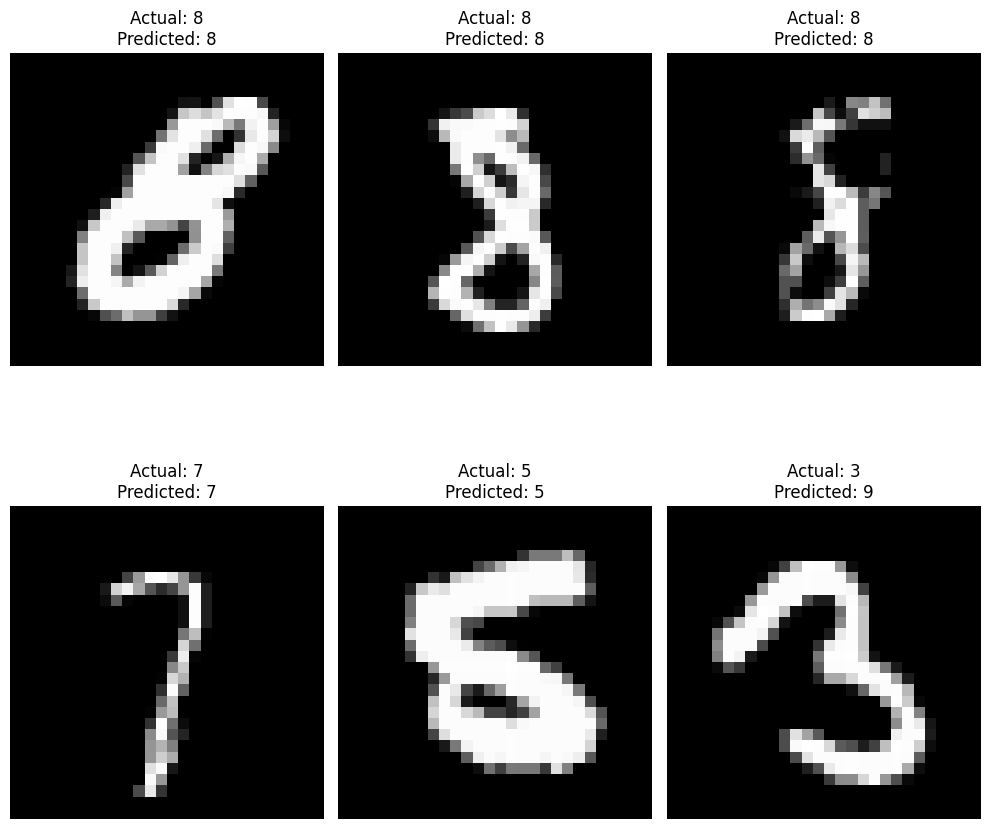

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.144960
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.175550
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.193999
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.288168
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.071720
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.139362
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.107608
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.061934
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.086897
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.159449

Test set: Average loss: 0.0002, Accuracy: 9638/10000 (96%)

Plotting top 6 confused images:


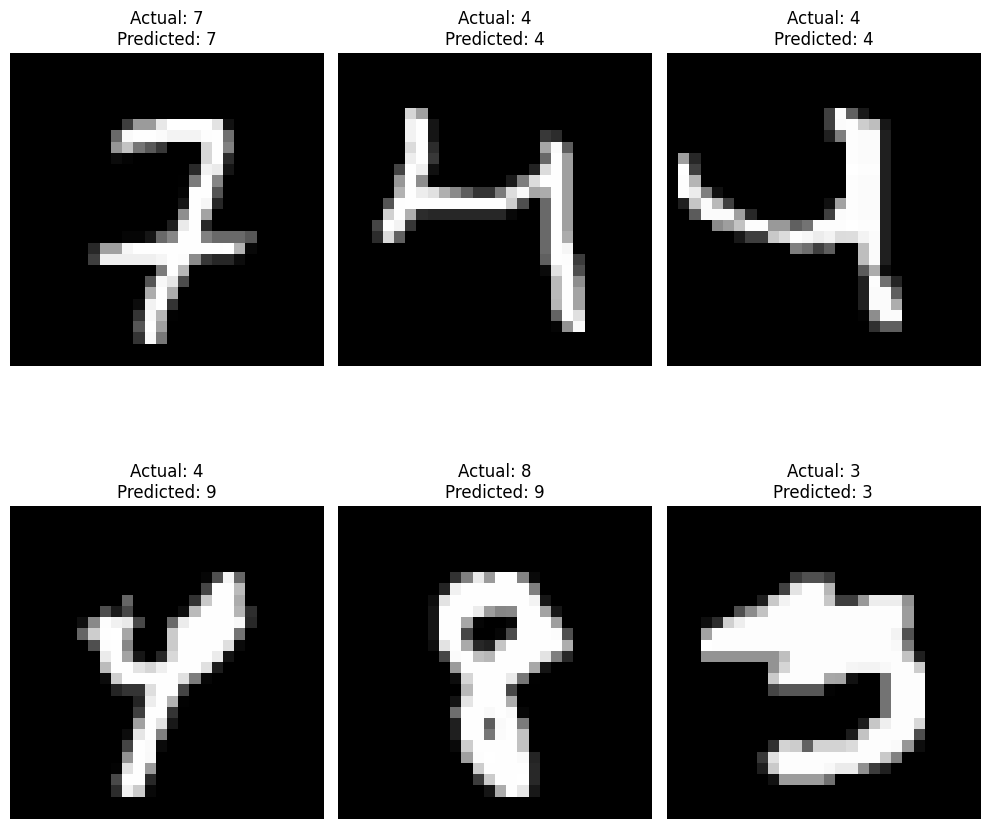

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.219103
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.090952
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.185074
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.123760
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.228501
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.141322
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.085405
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.125800
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.120592
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.369131

Test set: Average loss: 0.0002, Accuracy: 9755/10000 (98%)

Plotting top 6 confused images:


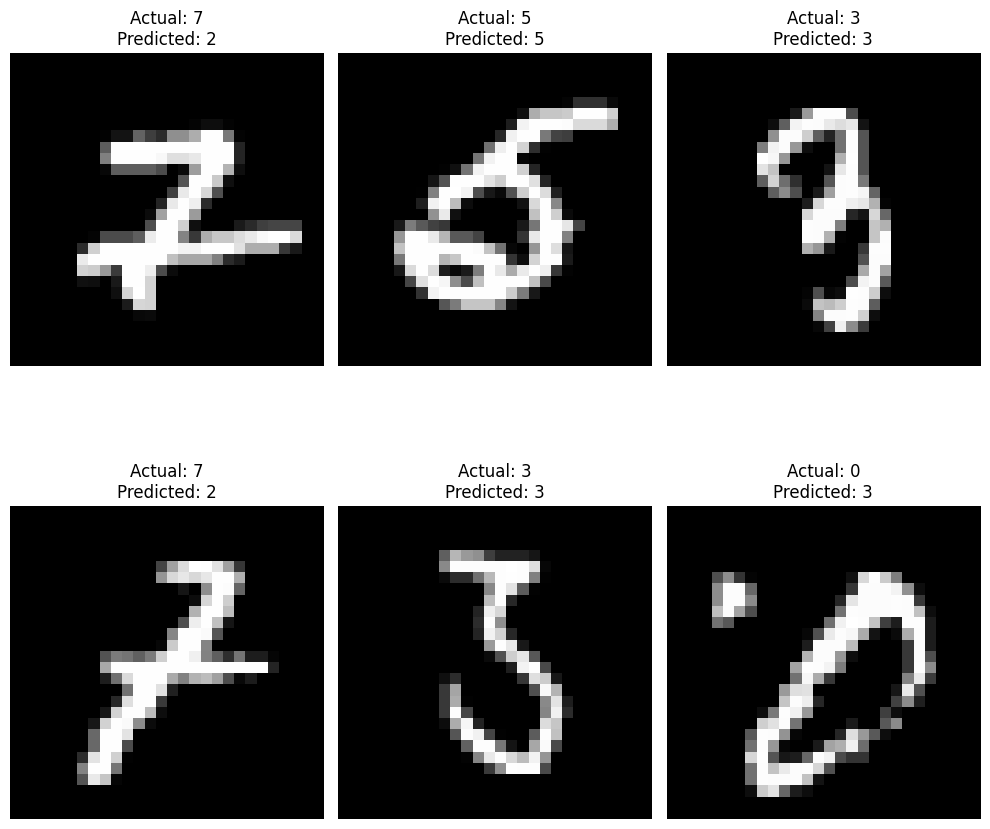

[I 2024-03-23 07:09:35,756] Trial 16 finished with value: 97.55 and parameters: {'lr': 0.0028872314797289233, 'momentum': 0.6000000000000001}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.283268
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.300158
Train Epoch: 1 [19200/60000 (32%)]	Loss: 2.296421
Train Epoch: 1 [25600/60000 (43%)]	Loss: 2.291772
Train Epoch: 1 [32000/60000 (53%)]	Loss: 2.292010
Train Epoch: 1 [38400/60000 (64%)]	Loss: 2.308124
Train Epoch: 1 [44800/60000 (75%)]	Loss: 2.287741
Train Epoch: 1 [51200/60000 (85%)]	Loss: 2.275696
Train Epoch: 1 [57600/60000 (96%)]	Loss: 2.300570

Test set: Average loss: 0.0046, Accuracy: 1640/10000 (16%)

Plotting top 6 confused images:


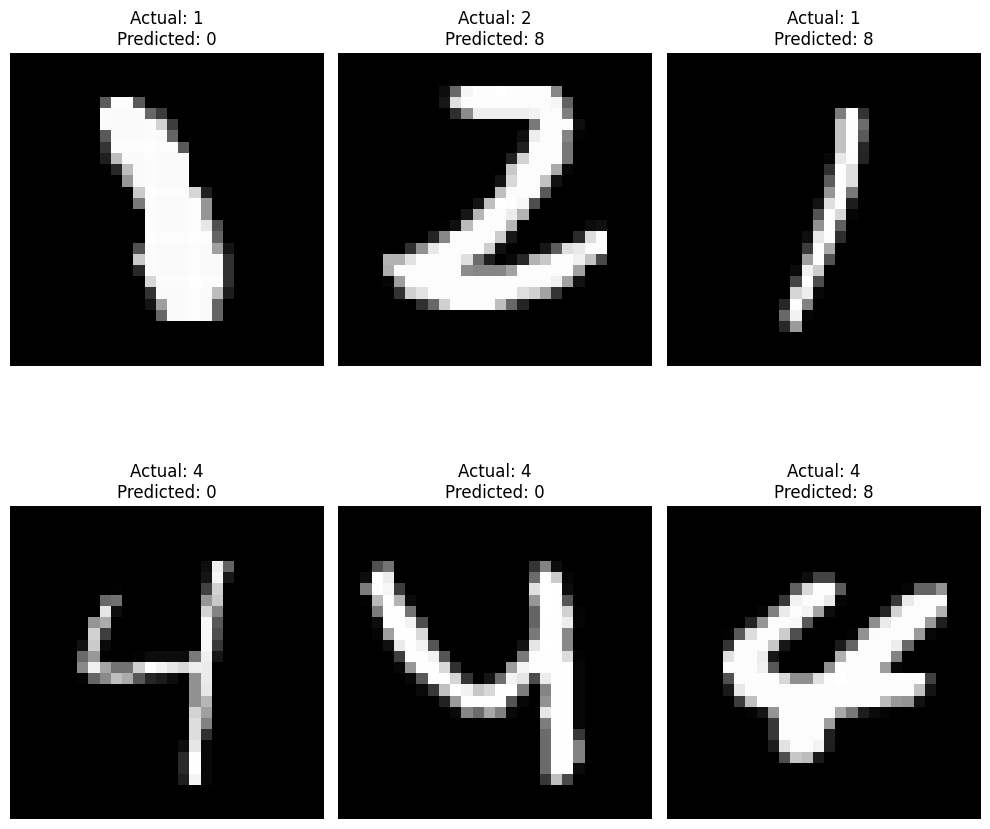

Train Epoch: 2 [0/60000 (0%)]	Loss: 2.279056
Train Epoch: 2 [6400/60000 (11%)]	Loss: 2.300226
Train Epoch: 2 [12800/60000 (21%)]	Loss: 2.314795
Train Epoch: 2 [19200/60000 (32%)]	Loss: 2.292535
Train Epoch: 2 [25600/60000 (43%)]	Loss: 2.292662
Train Epoch: 2 [32000/60000 (53%)]	Loss: 2.292705
Train Epoch: 2 [38400/60000 (64%)]	Loss: 2.299616
Train Epoch: 2 [44800/60000 (75%)]	Loss: 2.297012
Train Epoch: 2 [51200/60000 (85%)]	Loss: 2.286957
Train Epoch: 2 [57600/60000 (96%)]	Loss: 2.287789

Test set: Average loss: 0.0046, Accuracy: 1798/10000 (18%)

Plotting top 6 confused images:


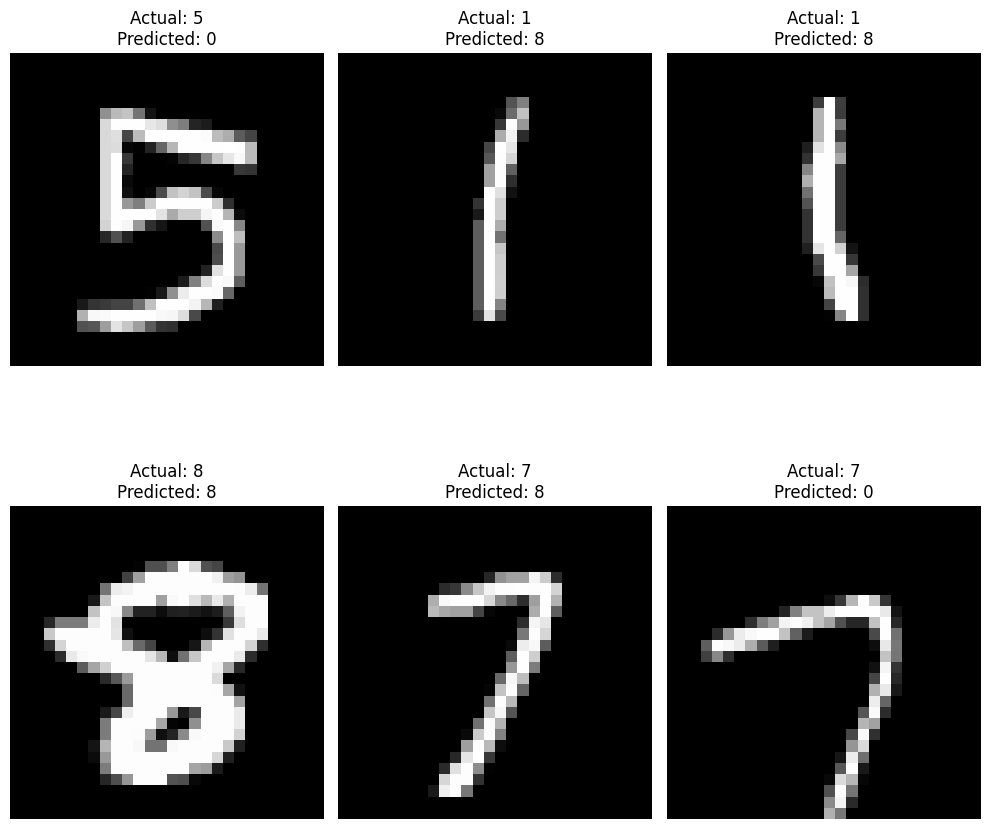

Train Epoch: 3 [0/60000 (0%)]	Loss: 2.288156
Train Epoch: 3 [6400/60000 (11%)]	Loss: 2.289864
Train Epoch: 3 [12800/60000 (21%)]	Loss: 2.301240
Train Epoch: 3 [19200/60000 (32%)]	Loss: 2.293521
Train Epoch: 3 [25600/60000 (43%)]	Loss: 2.276833
Train Epoch: 3 [32000/60000 (53%)]	Loss: 2.285198
Train Epoch: 3 [38400/60000 (64%)]	Loss: 2.286781
Train Epoch: 3 [44800/60000 (75%)]	Loss: 2.303572
Train Epoch: 3 [51200/60000 (85%)]	Loss: 2.276374
Train Epoch: 3 [57600/60000 (96%)]	Loss: 2.286839

Test set: Average loss: 0.0046, Accuracy: 2002/10000 (20%)

Plotting top 6 confused images:


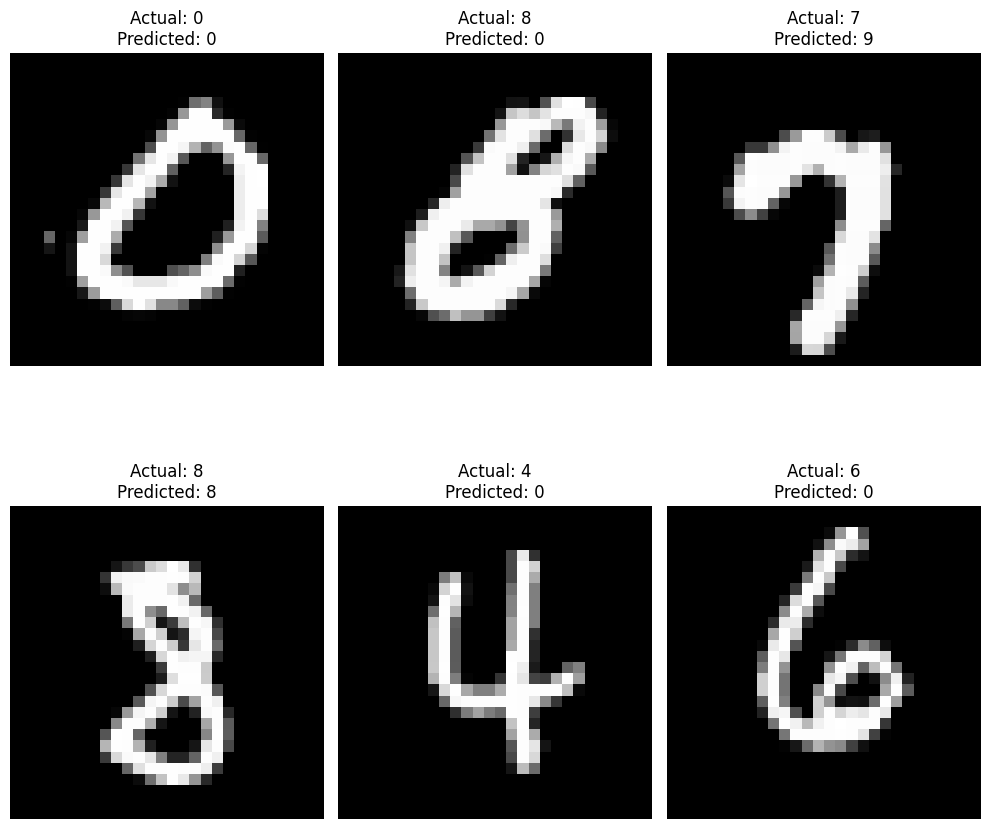

Train Epoch: 4 [0/60000 (0%)]	Loss: 2.297659
Train Epoch: 4 [6400/60000 (11%)]	Loss: 2.282384
Train Epoch: 4 [12800/60000 (21%)]	Loss: 2.293839
Train Epoch: 4 [19200/60000 (32%)]	Loss: 2.300817
Train Epoch: 4 [25600/60000 (43%)]	Loss: 2.295486
Train Epoch: 4 [32000/60000 (53%)]	Loss: 2.292095
Train Epoch: 4 [38400/60000 (64%)]	Loss: 2.286775
Train Epoch: 4 [44800/60000 (75%)]	Loss: 2.287455
Train Epoch: 4 [51200/60000 (85%)]	Loss: 2.282186
Train Epoch: 4 [57600/60000 (96%)]	Loss: 2.298833

Test set: Average loss: 0.0046, Accuracy: 2207/10000 (22%)

Plotting top 6 confused images:


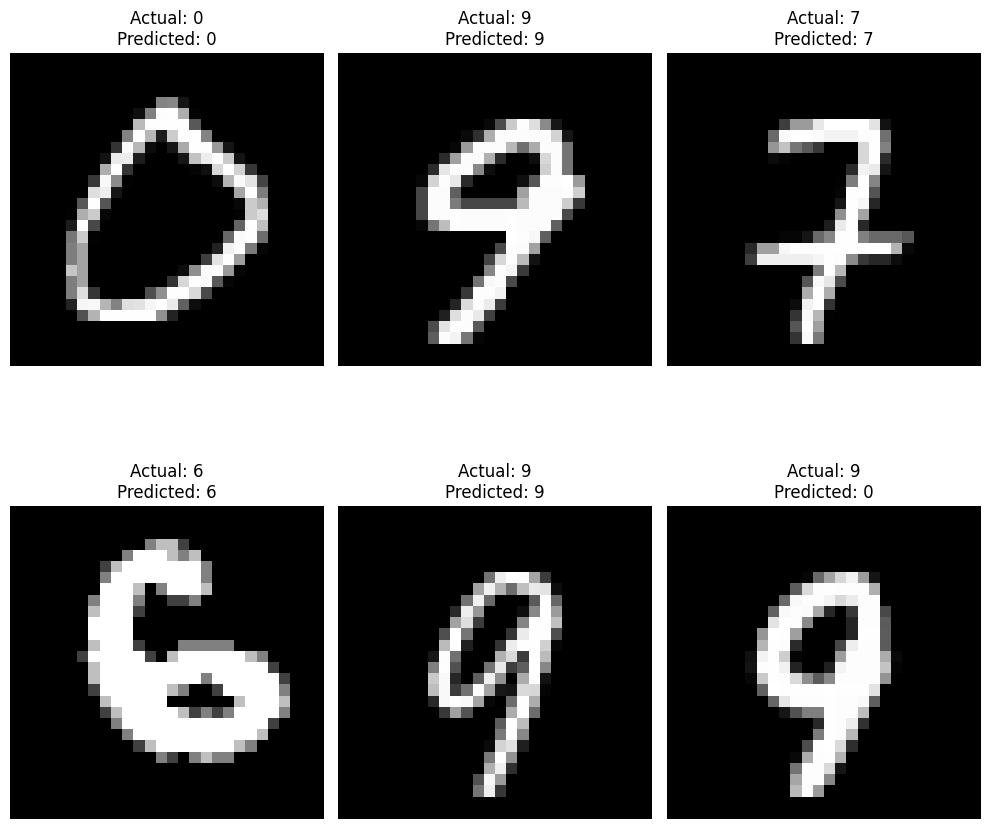

Train Epoch: 5 [0/60000 (0%)]	Loss: 2.284423
Train Epoch: 5 [6400/60000 (11%)]	Loss: 2.294270
Train Epoch: 5 [12800/60000 (21%)]	Loss: 2.284024
Train Epoch: 5 [19200/60000 (32%)]	Loss: 2.287076
Train Epoch: 5 [25600/60000 (43%)]	Loss: 2.281013
Train Epoch: 5 [32000/60000 (53%)]	Loss: 2.291401
Train Epoch: 5 [38400/60000 (64%)]	Loss: 2.284114
Train Epoch: 5 [44800/60000 (75%)]	Loss: 2.286814
Train Epoch: 5 [51200/60000 (85%)]	Loss: 2.257727
Train Epoch: 5 [57600/60000 (96%)]	Loss: 2.291611

Test set: Average loss: 0.0046, Accuracy: 2493/10000 (25%)

Plotting top 6 confused images:


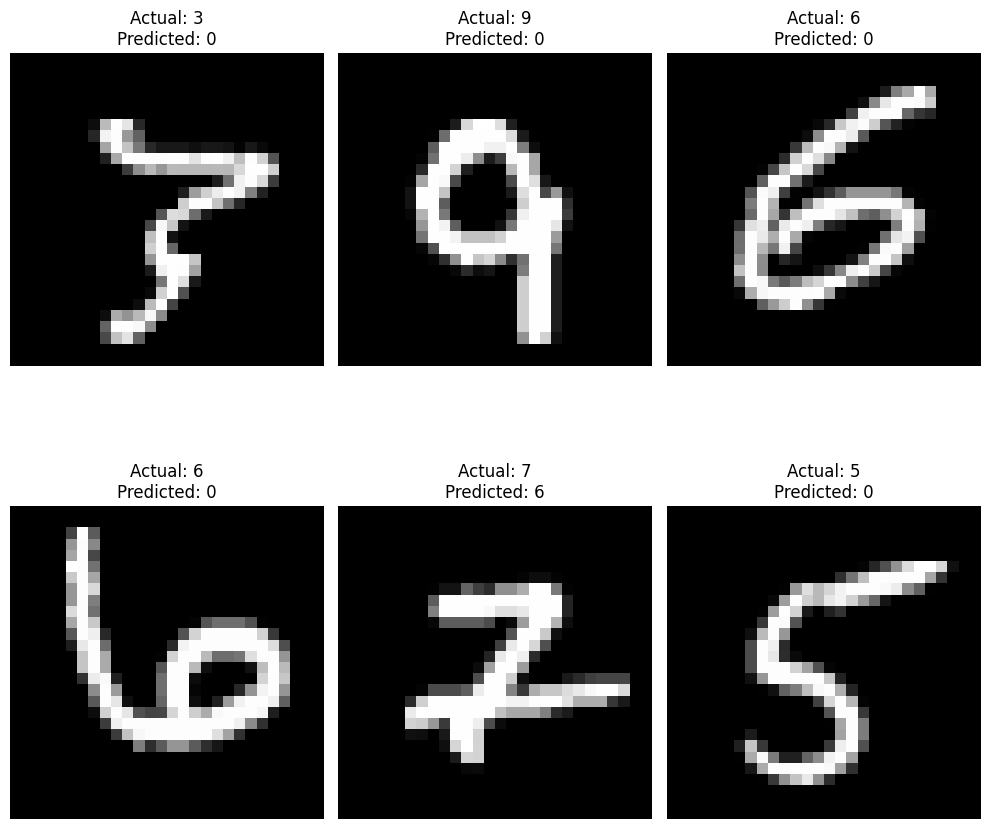

[I 2024-03-23 07:10:42,385] Trial 17 finished with value: 24.93 and parameters: {'lr': 1.4072294004417222e-05, 'momentum': 0.5}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.623231
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.910732
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.349123
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.683229
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.401856
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.467334
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.279902
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.342808
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.410253

Test set: Average loss: 0.0004, Accuracy: 9462/10000 (95%)

Plotting top 6 confused images:


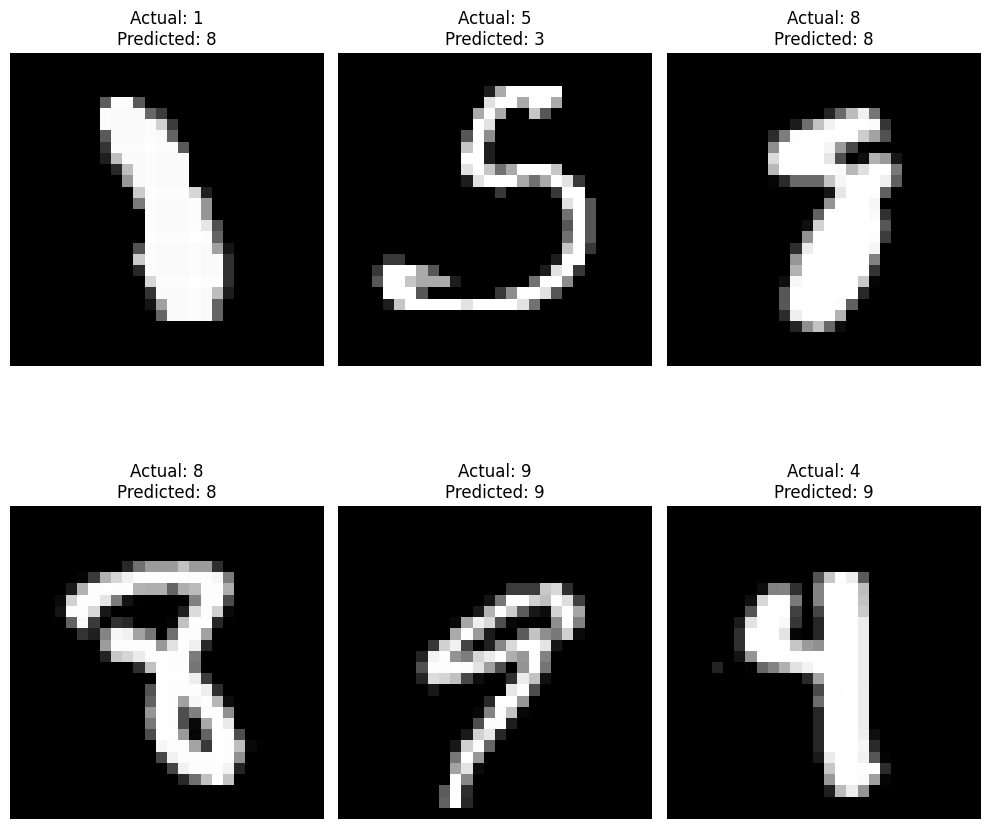

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.123258
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.178201
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.417396
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.066355
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.219669
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.191488
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.125865
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.060151
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.184029
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.135474

Test set: Average loss: 0.0003, Accuracy: 9589/10000 (96%)

Plotting top 6 confused images:


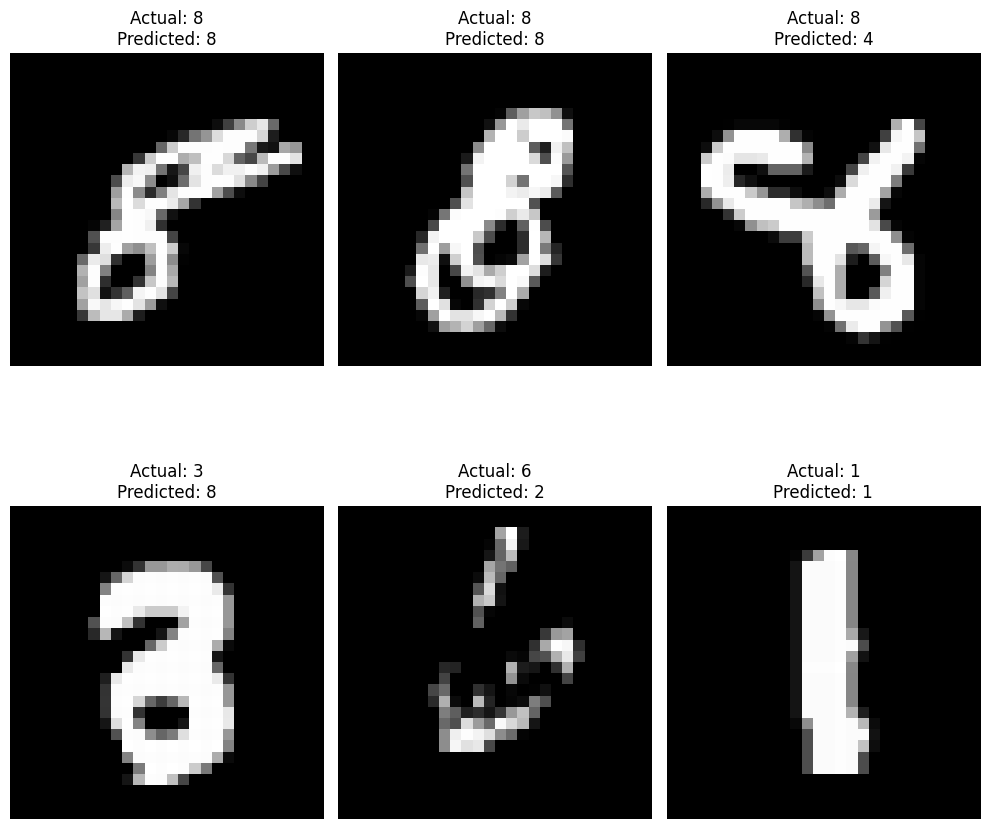

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.207417
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.045337
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.110844
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.046119
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.073028
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.158961
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.132983
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.344217
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.224868
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.137810

Test set: Average loss: 0.0002, Accuracy: 9702/10000 (97%)

Plotting top 6 confused images:


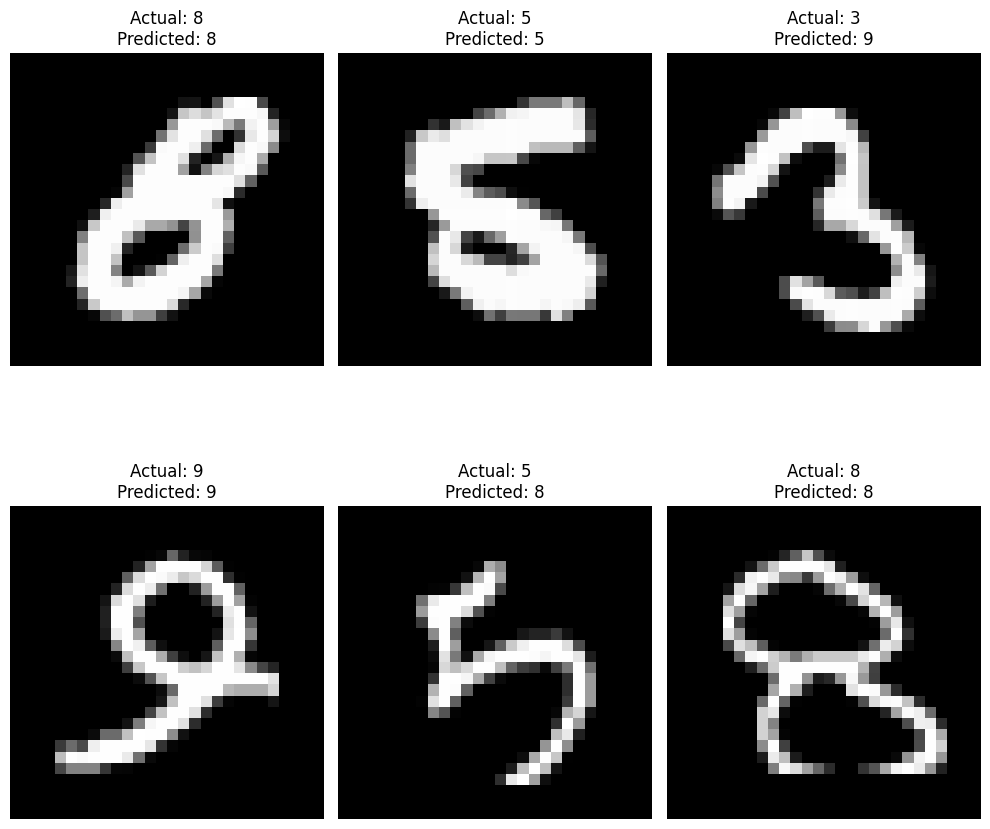

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.113644
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.142248
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.103034
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.276963
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.033604
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.113237
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.072406
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.042549
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.032155
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.131610

Test set: Average loss: 0.0002, Accuracy: 9714/10000 (97%)

Plotting top 6 confused images:


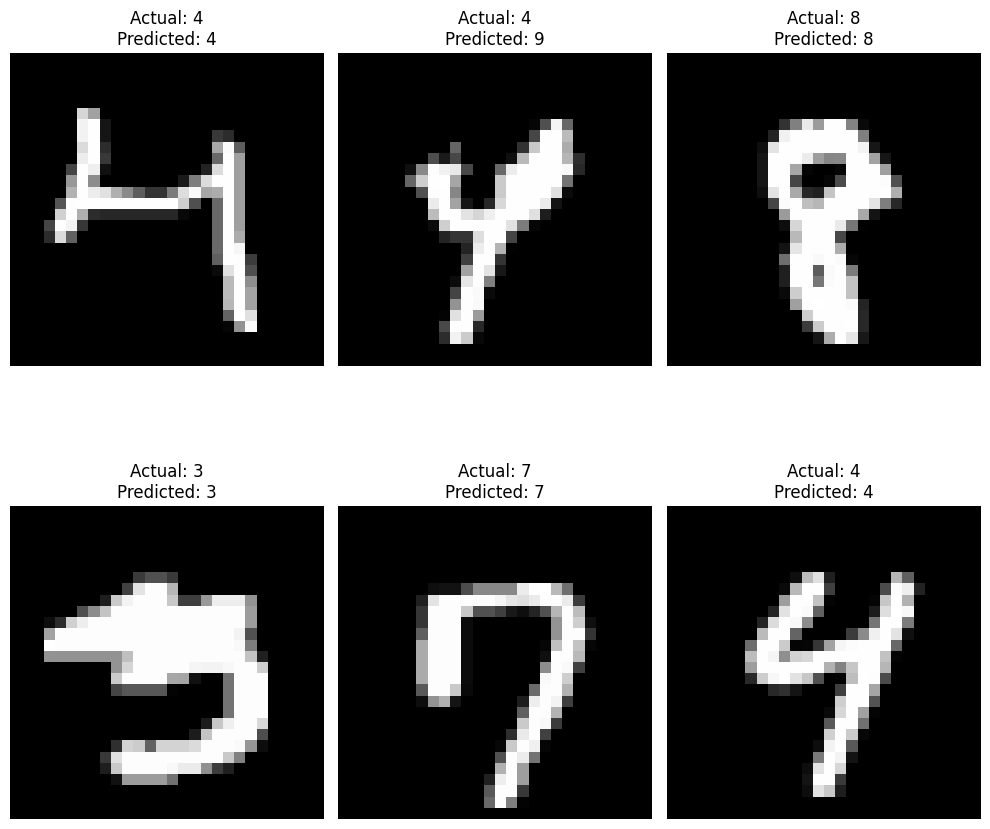

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.191402
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.034984
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.116937
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.087378
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.208174
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.083728
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.043659
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.114941
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.063106
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.327444

Test set: Average loss: 0.0001, Accuracy: 9823/10000 (98%)

Plotting top 6 confused images:


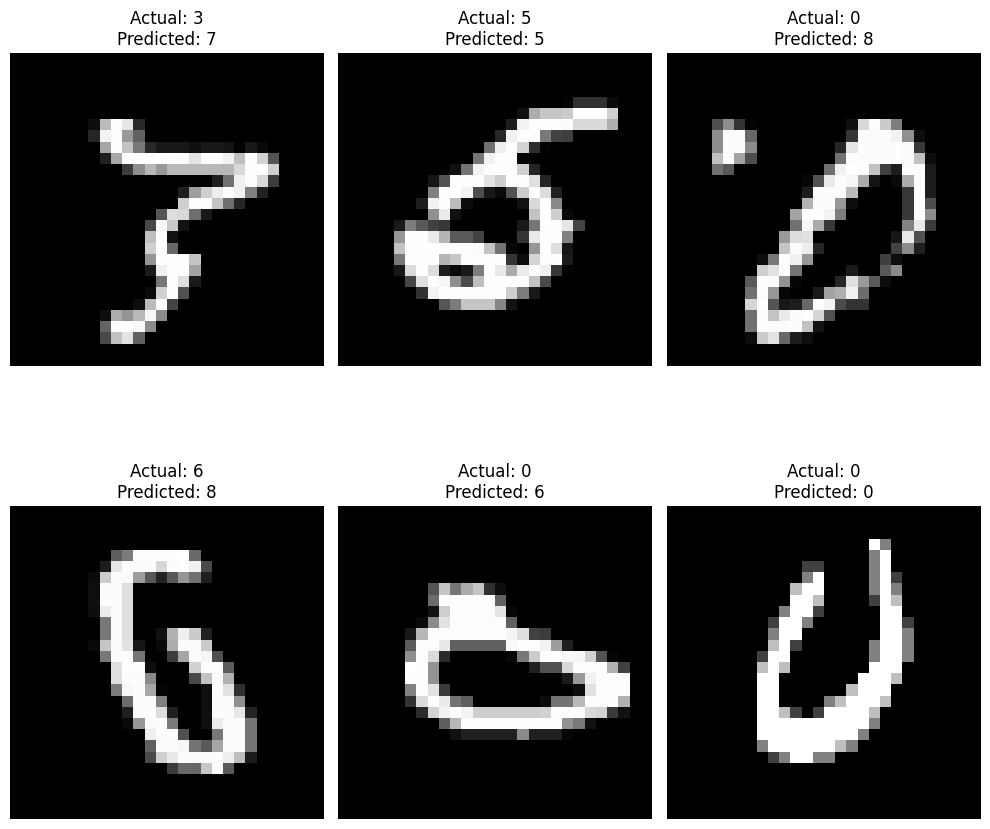

[I 2024-03-23 07:11:49,494] Trial 18 finished with value: 98.22999999999999 and parameters: {'lr': 0.004045426712524944, 'momentum': 0.7000000000000001}. Best is trial 10 with value: 98.54.


Train Epoch: 1 [0/60000 (0%)]	Loss: 2.312281
Train Epoch: 1 [6400/60000 (11%)]	Loss: 2.234770
Train Epoch: 1 [12800/60000 (21%)]	Loss: 2.185641
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.989711
Train Epoch: 1 [25600/60000 (43%)]	Loss: 1.552772
Train Epoch: 1 [32000/60000 (53%)]	Loss: 1.044923
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.828533
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.653685
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.497239
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.753007

Test set: Average loss: 0.0008, Accuracy: 8824/10000 (88%)

Plotting top 6 confused images:


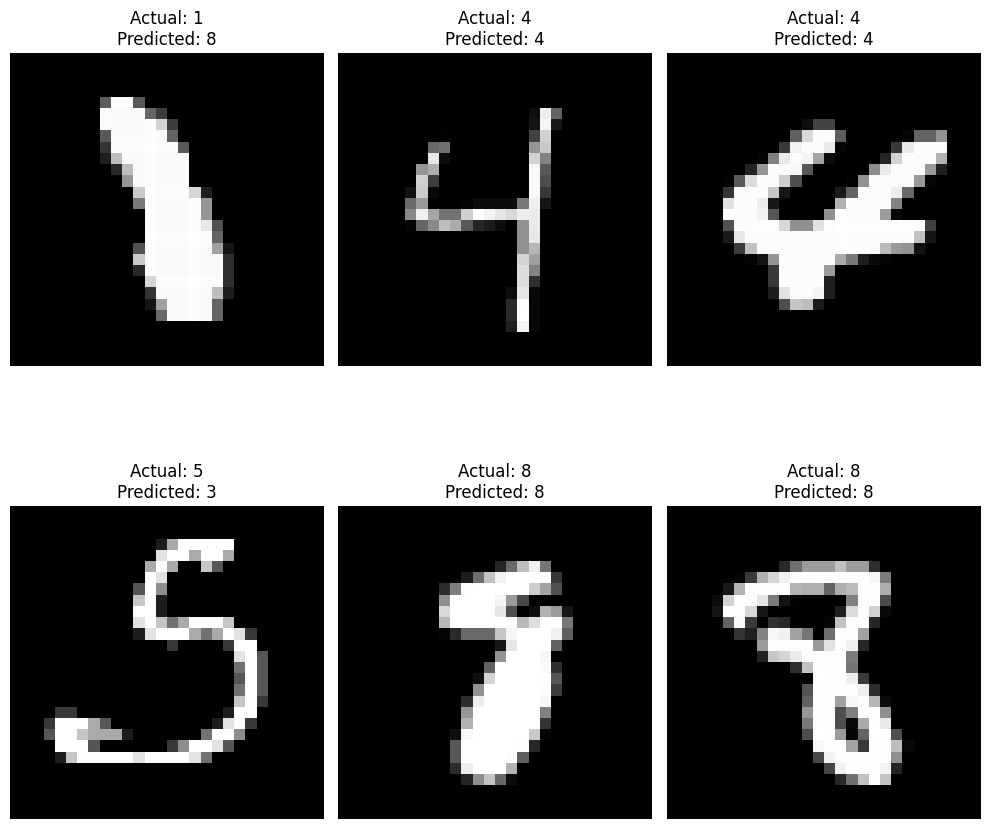

Train Epoch: 2 [0/60000 (0%)]	Loss: 0.347604
Train Epoch: 2 [6400/60000 (11%)]	Loss: 0.467284
Train Epoch: 2 [12800/60000 (21%)]	Loss: 0.794500
Train Epoch: 2 [19200/60000 (32%)]	Loss: 0.309926
Train Epoch: 2 [25600/60000 (43%)]	Loss: 0.363194
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.412389
Train Epoch: 2 [38400/60000 (64%)]	Loss: 0.251416
Train Epoch: 2 [44800/60000 (75%)]	Loss: 0.209625
Train Epoch: 2 [51200/60000 (85%)]	Loss: 0.399701
Train Epoch: 2 [57600/60000 (96%)]	Loss: 0.189542

Test set: Average loss: 0.0006, Accuracy: 9108/10000 (91%)

Plotting top 6 confused images:


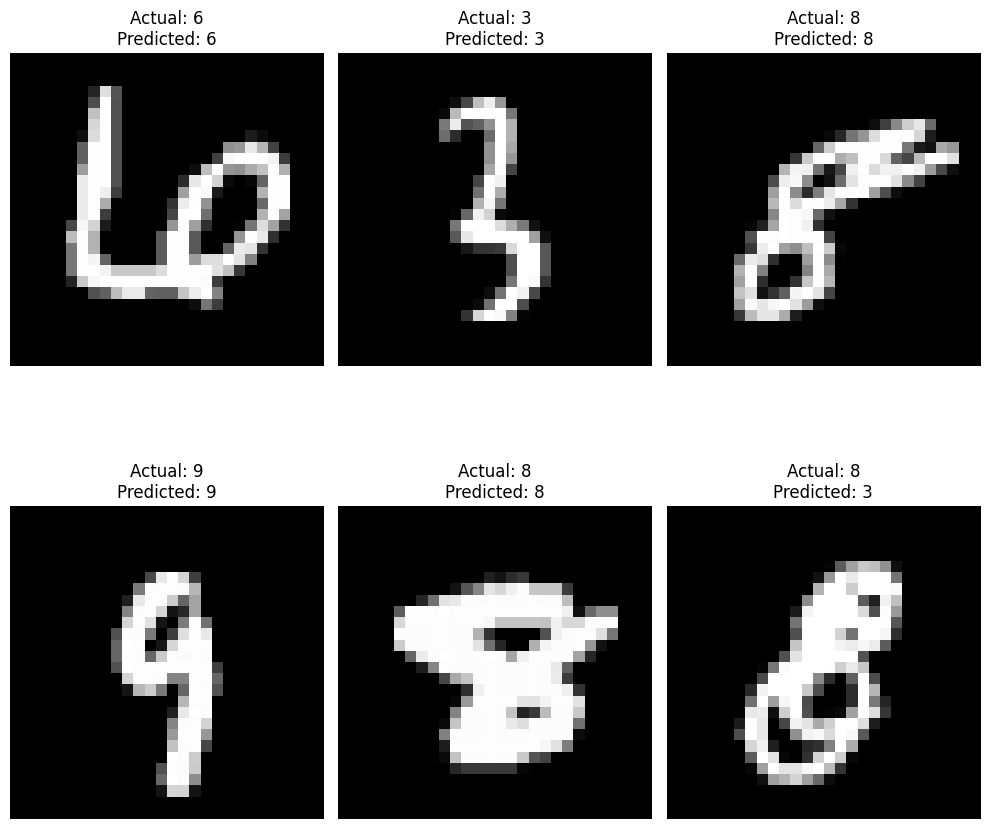

Train Epoch: 3 [0/60000 (0%)]	Loss: 0.469365
Train Epoch: 3 [6400/60000 (11%)]	Loss: 0.311078
Train Epoch: 3 [12800/60000 (21%)]	Loss: 0.255960
Train Epoch: 3 [19200/60000 (32%)]	Loss: 0.174895
Train Epoch: 3 [25600/60000 (43%)]	Loss: 0.197473
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.257093
Train Epoch: 3 [38400/60000 (64%)]	Loss: 0.337857
Train Epoch: 3 [44800/60000 (75%)]	Loss: 0.622748
Train Epoch: 3 [51200/60000 (85%)]	Loss: 0.416800
Train Epoch: 3 [57600/60000 (96%)]	Loss: 0.436436

Test set: Average loss: 0.0004, Accuracy: 9321/10000 (93%)

Plotting top 6 confused images:


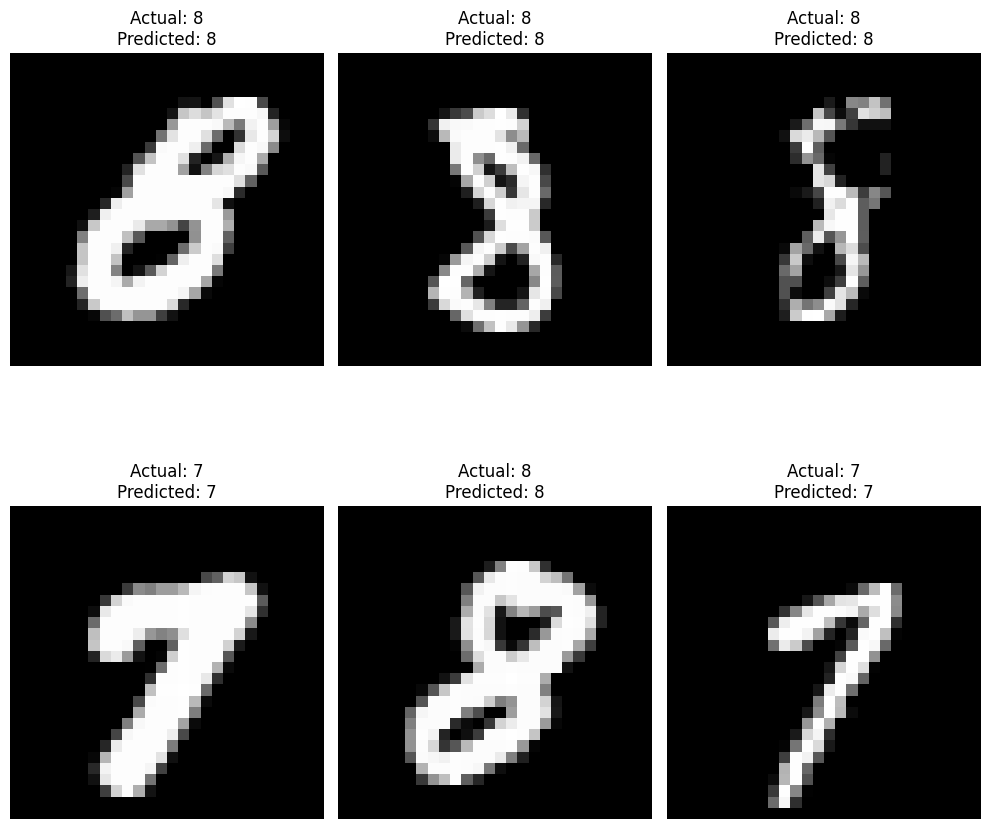

Train Epoch: 4 [0/60000 (0%)]	Loss: 0.243768
Train Epoch: 4 [6400/60000 (11%)]	Loss: 0.235867
Train Epoch: 4 [12800/60000 (21%)]	Loss: 0.337793
Train Epoch: 4 [19200/60000 (32%)]	Loss: 0.390000
Train Epoch: 4 [25600/60000 (43%)]	Loss: 0.190044
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.258289
Train Epoch: 4 [38400/60000 (64%)]	Loss: 0.208242
Train Epoch: 4 [44800/60000 (75%)]	Loss: 0.112450
Train Epoch: 4 [51200/60000 (85%)]	Loss: 0.168189
Train Epoch: 4 [57600/60000 (96%)]	Loss: 0.227539

Test set: Average loss: 0.0004, Accuracy: 9431/10000 (94%)

Plotting top 6 confused images:


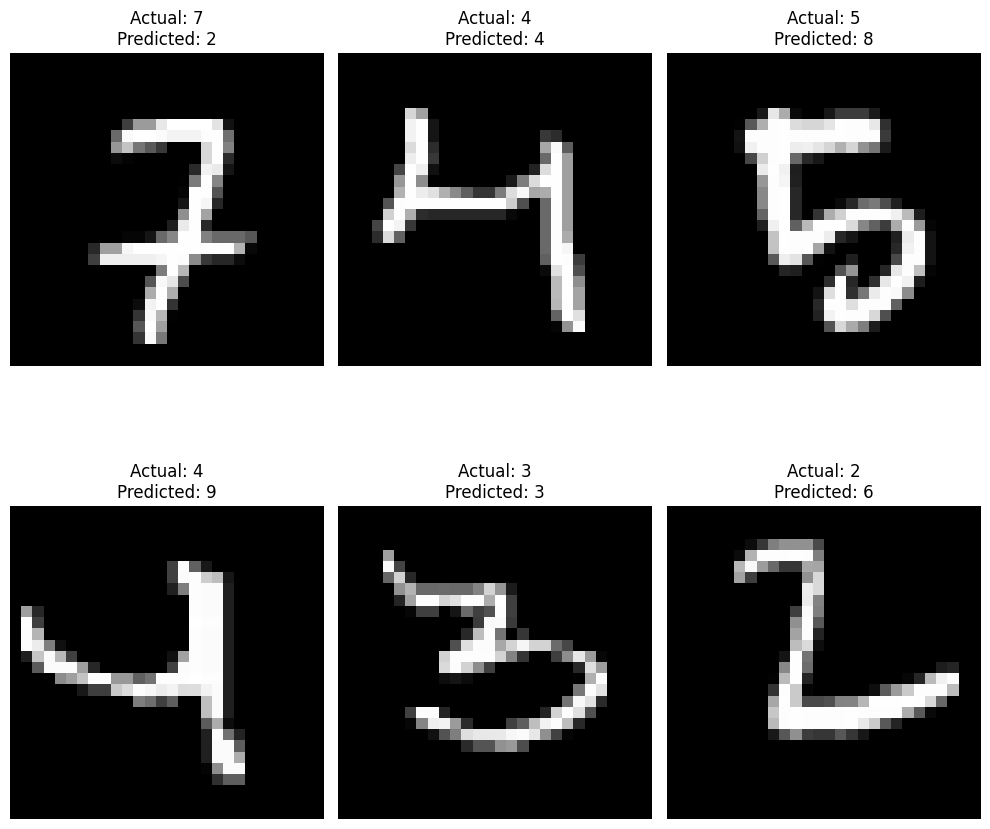

Train Epoch: 5 [0/60000 (0%)]	Loss: 0.276856
Train Epoch: 5 [6400/60000 (11%)]	Loss: 0.173446
Train Epoch: 5 [12800/60000 (21%)]	Loss: 0.266664
Train Epoch: 5 [19200/60000 (32%)]	Loss: 0.196566
Train Epoch: 5 [25600/60000 (43%)]	Loss: 0.309636
Train Epoch: 5 [32000/60000 (53%)]	Loss: 0.235216
Train Epoch: 5 [38400/60000 (64%)]	Loss: 0.154939
Train Epoch: 5 [44800/60000 (75%)]	Loss: 0.203821
Train Epoch: 5 [51200/60000 (85%)]	Loss: 0.258491
Train Epoch: 5 [57600/60000 (96%)]	Loss: 0.428720

Test set: Average loss: 0.0003, Accuracy: 9551/10000 (96%)

Plotting top 6 confused images:


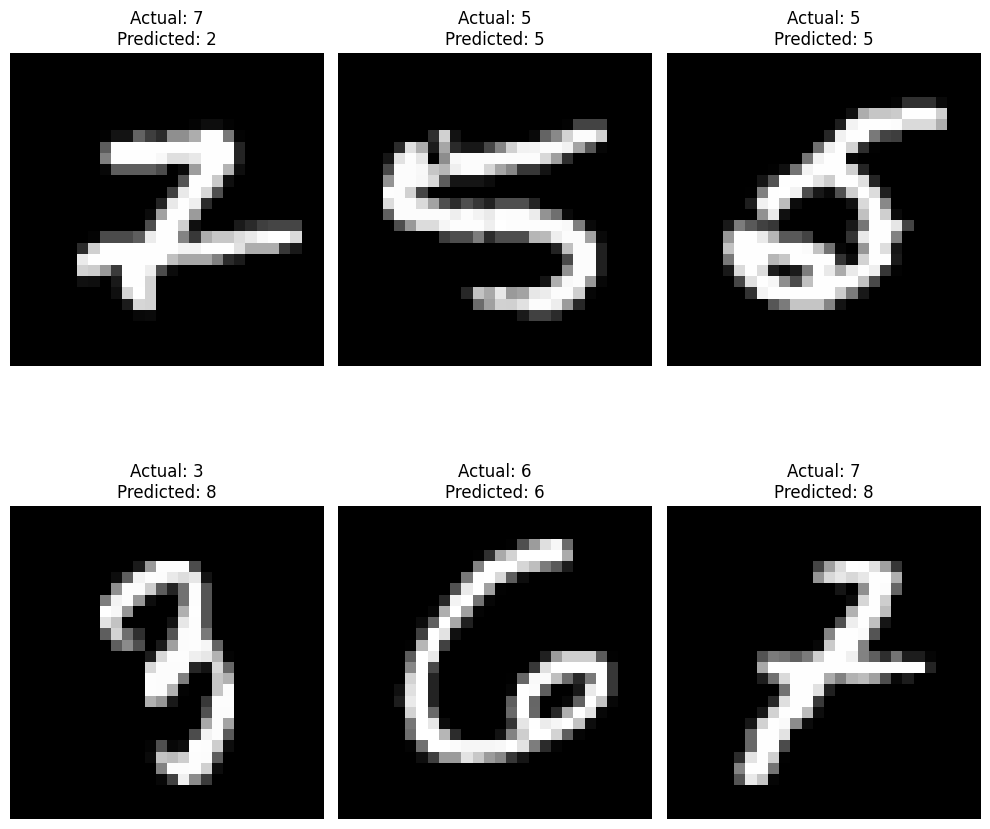

[I 2024-03-23 07:12:55,843] Trial 19 finished with value: 95.50999999999999 and parameters: {'lr': 0.0013711957733358543, 'momentum': 0.6000000000000001}. Best is trial 10 with value: 98.54.


In [8]:
storage = "sqlite:///db.sqlite3"
study = optuna.create_study(study_name="mnist_classification", direction='maximize', storage=storage)
study.optimize(objective, n_trials=20)

In [ ]:
study.best_value

In [ ]:
study.trials_dataframe()

## Run the dashboard with the below command
__optuna-dashboard sqlite:///db.sqlite3__

## Human in the loop optimisation with Optuna

In [ ]:
from optuna_dashboard import save_note, register_objective_form_widgets, ChoiceWidget
import textwrap
import cv2
import time
from optuna.trial import TrialState

from optuna.artifacts import FileSystemArtifactStore
from optuna.artifacts import upload_artifact
from optuna_dashboard.artifact import get_artifact_path

from PIL import Image

In [ ]:
def train_model(model, train_loader, optimizer, criterion, log_interval, epoch, device):

    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data.to(device))

        loss = criterion(output, target.to(device))
        loss.backward()

        optimizer.step()

        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))

        
def validate_model(model, test_loader, criterion, device, img_path, epoch, num_epochs, entropy_threshold=0.5):

    model.eval()
    total_loss = 0
    correct = 0
    total = 0

    #get the confused images
    confused_images = []
    actual_labels = []
    predicted_labels = []

    with torch.no_grad():
        for _, (data, target) in enumerate(test_loader):
            output = model(data).to(device)
            total_loss += criterion(output, target.to(device)).item()
            
            #model prediction
            _, predicted = torch.max(output, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

            # Calculate entropy
            probabilities = torch.softmax(output, dim=1)
            entropy = -torch.sum(probabilities * torch.log(probabilities + 1e-8), dim=1)
            
            # Find indices of confused images
            confused_mask = entropy > entropy_threshold
            confused_images.extend(data[confused_mask].cpu().numpy())

            # Store actual and predicted labels of confused images
            actual_labels.extend(target[confused_mask].cpu().numpy())
            predicted_labels.extend(predicted[confused_mask].cpu().numpy())

    total_loss /= len(test_loader.dataset)
    test_accuracy = 100. * (correct / len(test_loader.dataset))
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        total_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # Plot the top 9 confused images
    if confused_images and epoch==num_epochs:
        plot_top_confused_images(confused_images, actual_labels, predicted_labels, img_path)
        

    return test_accuracy

def plot_top_confused_images(confused_images, actual_labels, predicted_labels, output_path):
    n_confused_images = min(len(confused_images), 6)
    print(f"Plotting top {n_confused_images} confused images:")

    fig, axes = plt.subplots(2, 3, figsize=(10, 10))
    
    for i, ax in enumerate(axes.flat):
        if i < n_confused_images:
            ax.imshow(confused_images[i].squeeze(), cmap='gray')
            ax.set_title(f"Actual: {actual_labels[i]}\nPredicted: {predicted_labels[i]}")
            ax.axis('off')
        else:
            ax.axis('off')
    
    plt.tight_layout()
    plt.savefig(output_path)
    plt.close()
    plt.show()

In [ ]:
def objective(study: optuna.Study, artifact_store: FileSystemArtifactStore):

    #ask the trial number
    trial = study.ask()

    cfg = {
        'device': "cuda" if torch.cuda.is_available() else "cpu",
        'log_interval': 100,
        'seed': 0,
        'save_model': False,
        'n_epochs': 5,
        'train_batch_size': 64,
        'test_batch_size': 512,
        'lr': trial.suggest_float("lr", 1e-5, 1e-2, log=True),
        'momentum': trial.suggest_float("momentum", 0.4, 0.9, step=0.1),
        'criterion': nn.CrossEntropyLoss()
    }

    torch.manual_seed(cfg['seed'])
    train_loader, test_loader = get_mnist_loaders(cfg['train_batch_size'], cfg['test_batch_size'])
    model = SimpleCNN().to(cfg['device'])
    optimizer = optim.SGD(model.parameters(), lr=cfg['lr'], momentum=cfg['momentum'])
    for epoch in range(1, cfg['n_epochs']+1):
        train_model(model, train_loader, optimizer, cfg['criterion'], cfg['log_interval'], epoch, cfg['device']) #training the model

        #get the image path
        img_path = f"tmp/confused_lot-{trial.number}.png"
        test_accuracy = validate_model(model, test_loader, cfg['criterion'], cfg['device'], img_path, epoch, cfg['n_epochs'])

        #saving the artifacts to the artifacts directory
        if epoch == cfg['n_epochs']:
            artifacts_id = upload_artifact(trial, img_path, artifact_store)
            artifact_path = get_artifact_path(trial, artifacts_id)

    if cfg['save_model']:
        torch.save(model.state_dict(), "mnist_cnn.pt")

    # 4. Save Note
    note = textwrap.dedent(
        f"""\
    ## Trial {trial.number}

    ![generated-image]({artifact_path})

    Test Accuracy of the model: {test_accuracy:.2f}
    """
    )
    save_note(trial, note)

    return test_accuracy


In [ ]:
def start_optimization(artifact_store: FileSystemArtifactStore):
    # 1. Create Study
    storage = "sqlite:///db.sqlite3"
    study = optuna.create_study(study_name="HITL_with_optuna_for_digit_classification", 
                                direction='maximize', 
                                storage=storage,
                                load_if_exists=True)

    # 2. Set an objective name
    study.set_metric_names(["Are you satisfied with the model's validation accuracy?"])

    # 3. Register ChoiceWidget
    register_objective_form_widgets(
        study,
        widgets=[
            ChoiceWidget(
                choices=["Yes 👍", "Somewhat 👌", "No 👎"],
                values=[1, 0, -1],
                description="Please input your score!",
            ),
        ],
    )

    # 4. Start Human-in-the-loop Optimization
    n_batch = 2
    while True:
        running_trials = study.get_trials(deepcopy=False, states=(TrialState.RUNNING,))
        if len(running_trials) >= n_batch:
            time.sleep(1)  # Avoid busy-loop
            continue
        objective(study, artifact_store)

In [ ]:
def main():
    # tmp_path = os.path.join(os.path.dirname(__file__), "tmp")
    # Get the absolute path to the current notebook file
    notebook_dir = os.getcwd()

    # Create the absolute path to the "tmp" folder
    tmp_path = os.path.join(notebook_dir, "tmp")

    # 1. Create Artifact Store
    # artifact_path = os.path.join(os.path.dirname(__file__), "artifact")
    artifact_path = os.path.join(notebook_dir, "artifact")
    artifact_store = FileSystemArtifactStore(artifact_path)

    print(f"paths : {tmp_path}, {artifact_path}")

    if not os.path.exists(artifact_path):
        os.mkdir(artifact_path)

    if not os.path.exists(tmp_path):
        os.mkdir(tmp_path)

    # 2. Run optimize loop
    start_optimization(artifact_store)


if __name__ == "__main__":
    main()